In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold, learning_curve, validation_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sb

import keras
from keras.utils import to_categorical

In [1]:
def evaluate_model(model, X_train, y_train, verbose=True):
    cv = StratifiedKFold(n_splits=5)
    scoring = ['accuracy']
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True)
    
    if verbose:
        print(f"Training Set Accuracy Score: {scores['train_accuracy'].mean()}")
        print(f"CV Set Accuracy Score: {scores['test_accuracy'].mean()}")
        print(f"Training Time: {scores['fit_time'].mean()}")

    return {
        'train_score': scores['train_accuracy'].mean(),
        'cv_score': scores['test_accuracy'].mean(),
        'fit_time': scores['fit_time'].mean()
    }

def hp_evaluation(clf_type, param_name, params, verbose=False):
    train_scores = []
    cv_scores = []
    for param in params:
        dt = clf_type(**{param_name: param})
        scores = evaluate_model(dt, X_train, y_train, verbose=verbose)
        train_scores.append(scores['train_score'])
        cv_scores.append(scores['cv_score'])

    df = pd.DataFrame()
    df['train_scores'] = train_scores
    df['cv_scores'] = cv_scores
    df.index = params
    df.plot()
    return df

def final_model_evaluation(model, X_test, y_test):
    f1 = model.score(X_test, y_test)
    print(f'Test Set Accuracy Score: {f1}')
    print(ConfusionMatrixDisplay.from_estimator(model, X_test, y_test))

## Wine

In [3]:
# Read Data and show

df = pd.read_csv("data/winequality-red.csv", sep=';')
print(df.shape)
df.head()

(1599, 12)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [4]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [5]:
df['quality'].value_counts() / df.shape[0]

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [6]:
681/1599

0.425891181988743

In [7]:
638/1599

0.3989993746091307

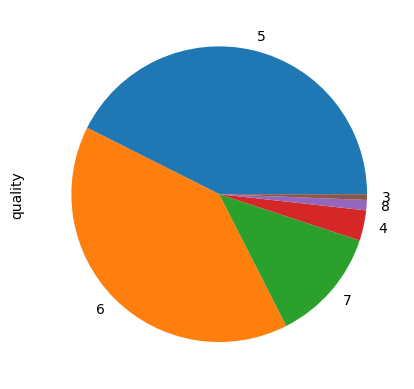

In [8]:
df['quality'].value_counts().plot.pie()
plt.savefig('value_count.png')

In [9]:
X.shape

(1599, 11)

In [2]:
# Show types of columns
X.dtypes

NameError: name 'X' is not defined

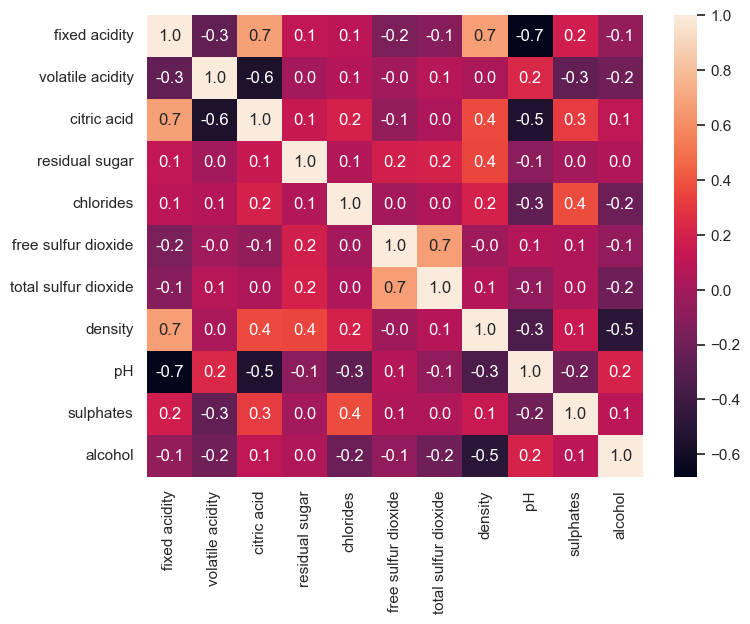

In [11]:
sb.set(rc={'figure.figsize':(8,6)})
sb.heatmap(X.corr(), annot=True, fmt='.1f')
plt.savefig('wine_correlation.png')

In [12]:
# Create the training/test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,)

In [13]:
sb.set(rc={'figure.figsize':(7,5)})

#### Decision Tree

In [29]:
param_range = range(2,30)

train_scores, validation_scores = validation_curve(
    DecisionTreeClassifier(), 
    X_train, 
    y_train,
    param_name='max_depth',
    param_range=range(2, 30),
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
)

Best Param: 13
Scores:
 training      0.965595
validation    0.586376
Name: 13, dtype: float64


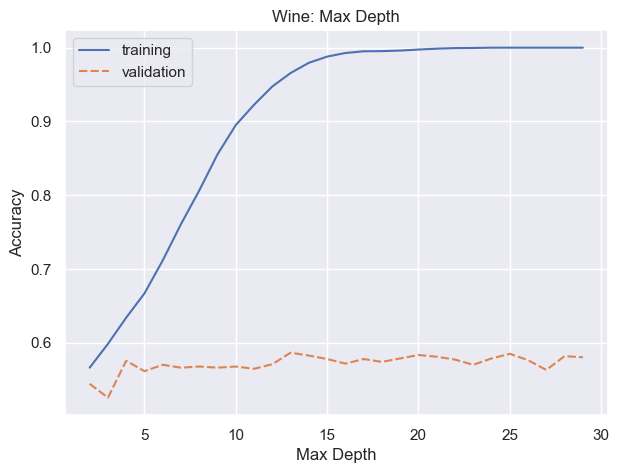

In [30]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])


plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Max Depth', ylabel='Accuracy', title='Wine: Max Depth');
plt.savefig('wine_dt_max_depth.png')

In [31]:
param_range = np.arange(1, 300, 2)

train_scores, validation_scores = validation_curve(
    DecisionTreeClassifier(), 
    X_train, 
    y_train,
    param_name='min_samples_leaf',
    param_range=param_range,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
)

Best Param: 31
Scores:
 training      0.658132
validation    0.595769
Name: 31, dtype: float64


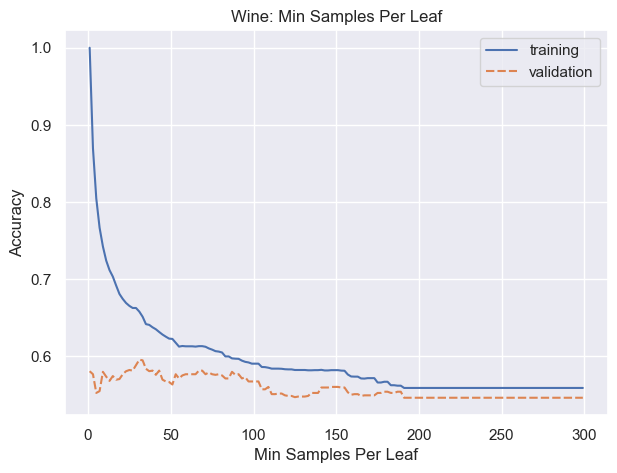

In [32]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])


plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Min Samples Per Leaf', ylabel='Accuracy', title='Wine: Min Samples Per Leaf');
plt.savefig('wine_dt_min_samples_per_leaf.png')

In [33]:
param_range = np.geomspace(1e-6, 1e-2, num=50)

train_scores, validation_scores = validation_curve(
    DecisionTreeClassifier(), 
    X_train, 
    y_train,
    param_name='ccp_alpha',
    param_range=param_range,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
)

Best Param: 0.00019306977288832496
Scores:
 training      1.00000
validation    0.59265
Name: 0.00019306977288832496, dtype: float64


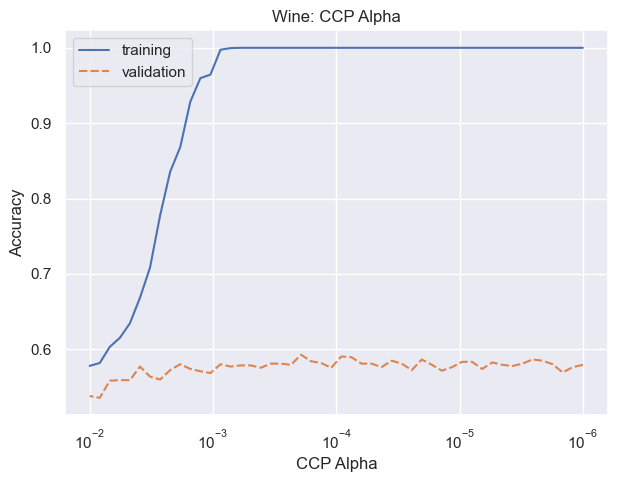

In [34]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])


plot = sb.lineplot(data=plot_df)
plot.set(xlabel='CCP Alpha', ylabel='Accuracy', title='Wine: CCP Alpha', xscale='log')
plot.invert_xaxis()
plt.savefig('wine_dt_ccp_alpha.png')

In [35]:
clf = DecisionTreeClassifier(min_samples_leaf=120)
train_sizes, train_scores, cv_scores = learning_curve(
    clf, 
    X_train, 
    y_train, 
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    train_sizes=np.linspace(.1, 1, num=20),
    n_jobs=-1
)

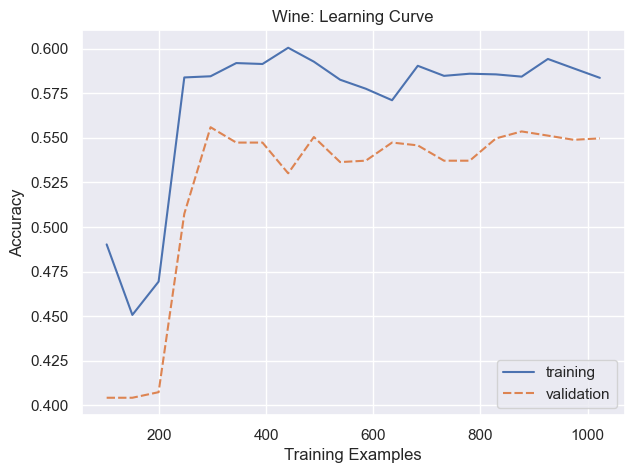

In [36]:
plot_df = pd.DataFrame()
plot_df.index = train_sizes
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = cv_scores.mean(axis=1)

plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Training Examples', ylabel='Accuracy', title='Wine: Learning Curve');
plt.savefig('wine_dt_learning_curve.png')

In [37]:
evaluate_model(DecisionTreeClassifier(min_samples_leaf=120), X_train, y_train)

Training Set Accuracy Score: 0.5834610596896384
CV Set Accuracy Score: 0.5496354166666666
Training Time: 0.0018015384674072265


{'train_score': 0.5834610596896384,
 'cv_score': 0.5496354166666666,
 'fit_time': 0.0018015384674072265}

Test Set Accuracy Score: 0.55


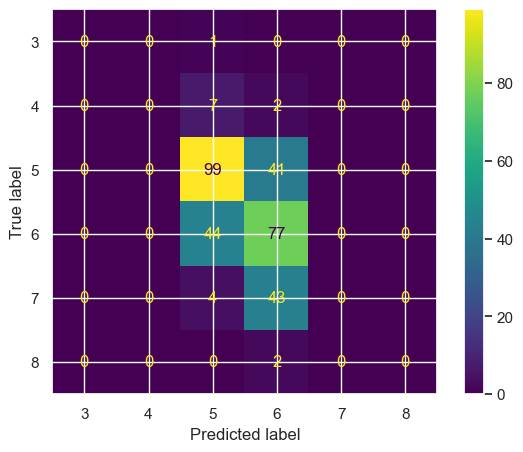

In [38]:
clf = DecisionTreeClassifier(min_samples_leaf=120)
clf.fit(X_train, y_train)

final_model_evaluation(clf, X_test, y_test)

#### AdaBoosting

In [39]:
param_range = np.arange(1, 1250, 10)

train_scores, validation_scores = validation_curve(
    AdaBoostClassifier(learning_rate=.015), 
    X_train, 
    y_train,
    param_name='n_estimators',
    param_range=param_range,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
)

Best Param: 61
Scores:
 training      0.583070
validation    0.558995
Name: 61, dtype: float64


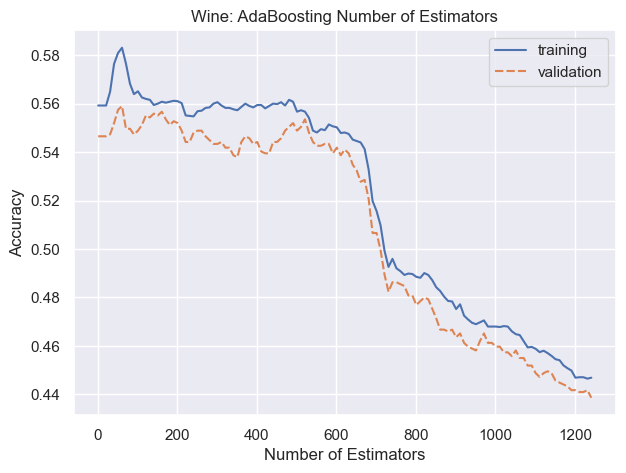

In [40]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])


plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Number of Estimators', ylabel='Accuracy', title='Wine: AdaBoosting Number of Estimators');
plt.savefig('wine_ada_estimators.png')

In [41]:
param_range = np.linspace(.00001, 1, num=100)

train_scores, validation_scores = validation_curve(
    AdaBoostClassifier(n_estimators=51), 
    X_train, 
    y_train,
    param_name='learning_rate',
    param_range=param_range,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
)

Best Param: 0.12122090909090909
Scores:
 training      0.567238
validation    0.555110
Name: 0.12122090909090909, dtype: float64


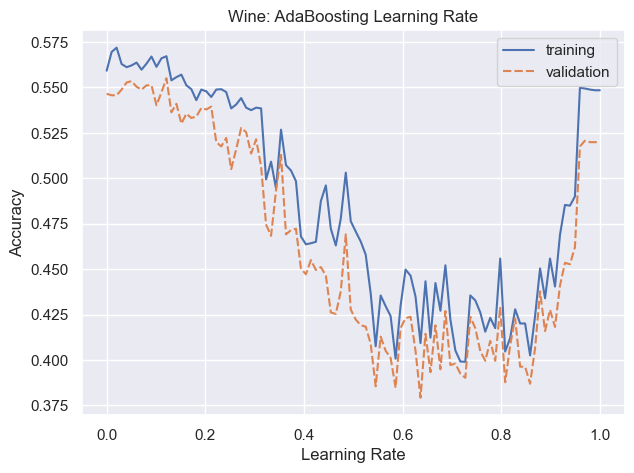

In [42]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])

plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Learning Rate', ylabel='Accuracy', title='Wine: AdaBoosting Learning Rate');
plt.savefig('wine_ada_learning_rate.png')

In [43]:
clf = AdaBoostClassifier(n_estimators=47, learning_rate=.045)
train_sizes, train_scores, cv_scores = learning_curve(
    clf, 
    X_train, 
    y_train, 
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    train_sizes=np.linspace(.1, 1, num=50),
    n_jobs=-1
)

Best Param: 0.38384454545454544
Scores:
 training      0.582353
validation    0.555101
Name: 816, dtype: float64


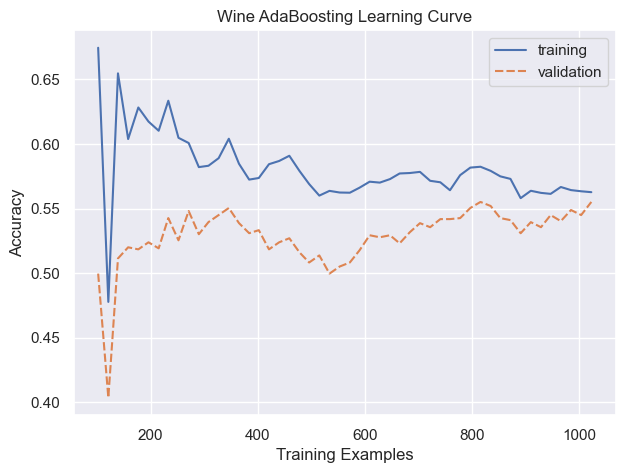

In [44]:
plot_df = pd.DataFrame()
plot_df.index = train_sizes
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = cv_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])


plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Training Examples', ylabel='Accuracy', title='Wine AdaBoosting Learning Curve');
plt.savefig('wine_ada_learning_curve.png')

In [23]:
evaluate_model(AdaBoostClassifier(n_estimators=47, learning_rate=.045), X_train, y_train)

Training Set Accuracy Score: 0.575449237842131
CV Set Accuracy Score: 0.5848253676470587
Training Time: 0.05645122528076172


{'train_score': 0.575449237842131,
 'cv_score': 0.5848253676470587,
 'fit_time': 0.05645122528076172}

Test Set Accuracy Score: 0.540625


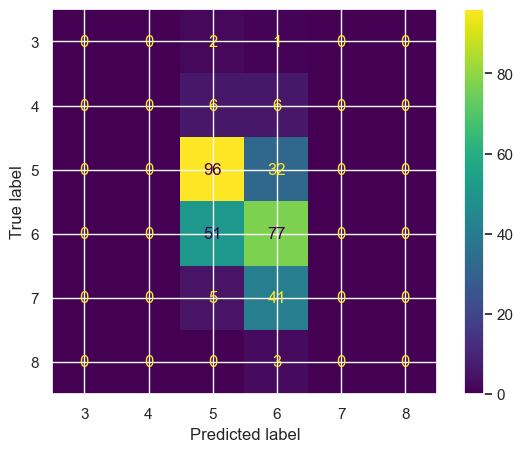

In [24]:
clf = AdaBoostClassifier(n_estimators=47, learning_rate=.045)
clf.fit(X_train, y_train)

final_model_evaluation(clf, X_test, y_test)

#### SVM

In [27]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

X = (X - X.mean()) / X.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [48]:
param_range = ['linear', 'poly', 'rbf', 'sigmoid']

train_scores, validation_scores = validation_curve(
    SVC(), 
    X_train, 
    y_train,
    param_name='kernel',
    param_range=param_range,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


Best Param: rbf
Scores:
 training      0.680999
validation    0.629384
Name: rbf, dtype: float64


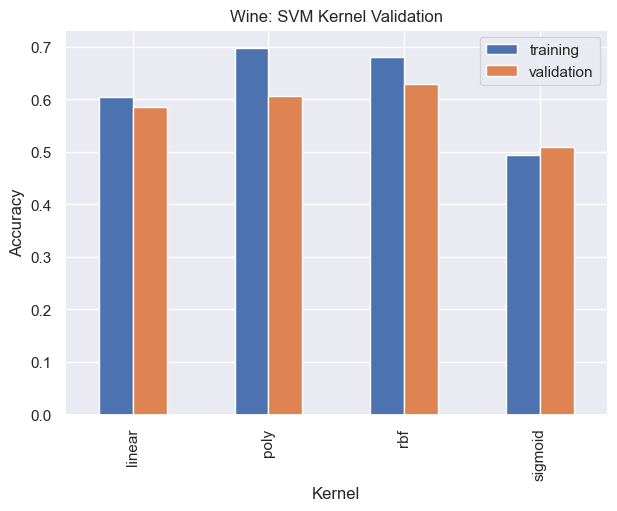

In [49]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])

plot_df.plot.bar(xlabel='Kernel', ylabel='Accuracy', title='Wine: SVM Kernel Validation')
plt.savefig('wine_svm_kernel.png')

In [21]:
param_range = np.linspace(.001, 2, num=10)

train_scores, validation_scores = validation_curve(
    SVC(kernel='rbf'), 
    X_train, 
    y_train,
    param_name='C',
    param_range=param_range,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best Param: 2.0
Scores:
 training      0.715990
validation    0.635674
Name: 2.0, dtype: float64


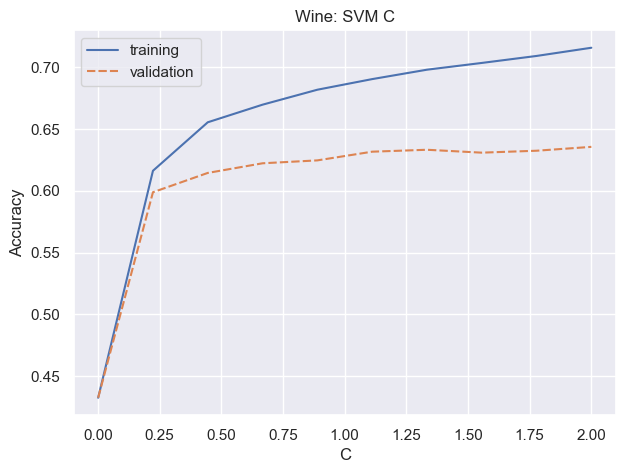

In [22]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])


plot = sb.lineplot(data=plot_df)
plot.set(xlabel='C', ylabel='Accuracy', title='Wine: SVM C');
plt.savefig('wine_svm_c.png')

In [54]:
clf = SVC(kernel='rbf', C=.25)
train_sizes, train_scores, cv_scores = learning_curve(
    clf, 
    X_train,
    y_train, 
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    train_sizes=np.linspace(.1, 1, num=10),
    n_jobs=-1,
    verbose=1
)

[learning_curve] Training set sizes: [ 102  204  306  409  511  613  716  818  920 1023]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Best Param: 20.0
Scores:
 training      0.630890
validation    0.606685
Name: 1023, dtype: float64


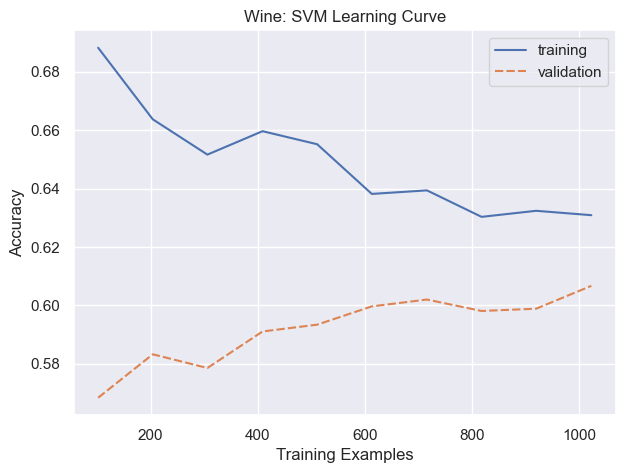

In [55]:
plot_df = pd.DataFrame()
plot_df.index = train_sizes
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = cv_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])


plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Training Examples', ylabel='Accuracy', title='Wine: SVM Learning Curve');
plt.savefig('wine_svm_learning_curve.png')

In [34]:
evaluate_model(SVC(kernel='rbf', C=.25), X_train, y_train)

Training Set Accuracy Score: 0.6225562072336266
CV Set Accuracy Score: 0.5973529411764706
Training Time: 0.029827022552490236


{'train_score': 0.6225562072336266,
 'cv_score': 0.5973529411764706,
 'fit_time': 0.029827022552490236}

Test Set Accuracy Score: 0.596875


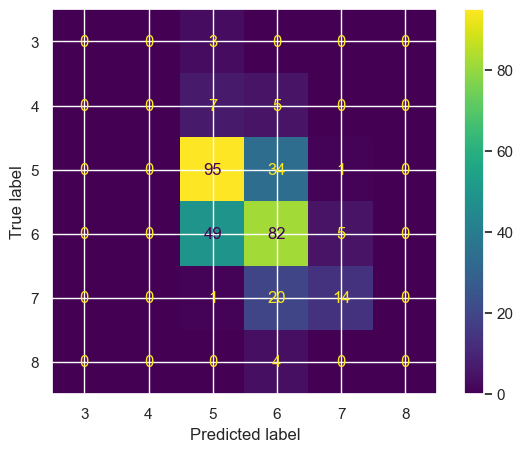

In [35]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

final_model_evaluation(clf, X_test, y_test)

#### KNN

In [58]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

X = (X - X.mean()) / X.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [59]:
param_range = np.arange(1, 40, 1)

train_scores, validation_scores = validation_curve(
    KNeighborsClassifier(), 
    X_train, 
    y_train,
    param_name='n_neighbors',
    param_range=param_range,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:    1.0s finished


Best Param: 1
Scores:
 training      1.000000
validation    0.618447
Name: 1, dtype: float64


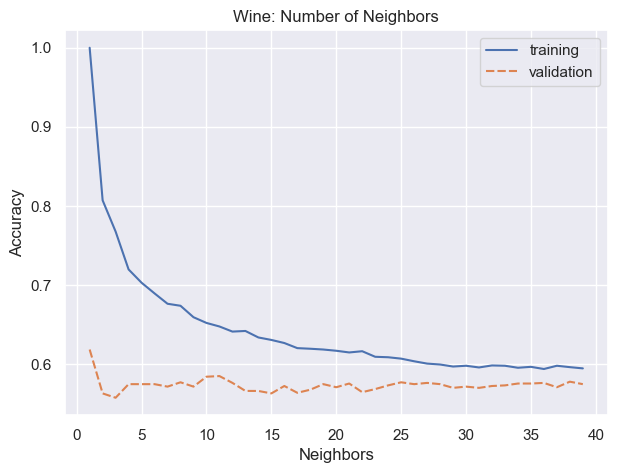

In [60]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])

plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Neighbors', ylabel='Accuracy', title='Wine: Number of Neighbors');
plt.savefig('wine_knn_neighbors.png')

In [61]:
param_range = ['uniform', 'distance']

train_scores, validation_scores = validation_curve(
    KNeighborsClassifier(n_neighbors=20), 
    X_train, 
    y_train,
    param_name='weights',
    param_range=param_range,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Best Param: distance
Scores:
 training      1.000000
validation    0.660686
Name: distance, dtype: float64


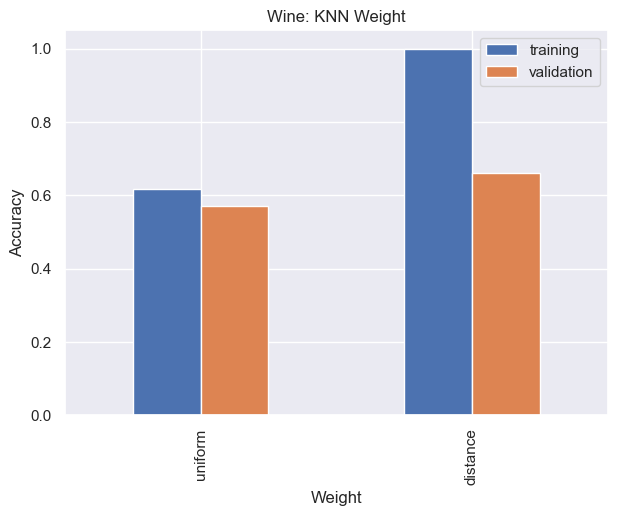

In [62]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])

plot_df.plot.bar(xlabel='Weight', ylabel='Accuracy', title='Wine: KNN Weight')
plt.savefig('wine_knn_weight.png')

In [63]:
clf = KNeighborsClassifier(n_neighbors=20, weights='distance')
train_sizes, train_scores, cv_scores = learning_curve(
    clf, 
    X_train, 
    y_train, 
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    train_sizes=np.linspace(.1, 1, num=20),
    n_jobs=-1,
)

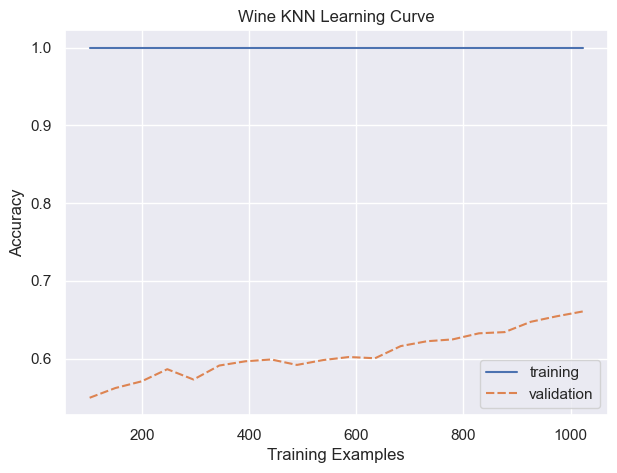

In [64]:
plot_df = pd.DataFrame()
plot_df.index = train_sizes
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = cv_scores.mean(axis=1)

plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Training Examples', ylabel='Accuracy', title='Wine KNN Learning Curve');
plt.savefig('wine_knn_learning_curve.png')

In [65]:
evaluate_model(KNeighborsClassifier(n_neighbors=20, weights='distance'), X_train, y_train)

Training Set Accuracy Score: 1.0
CV Set Accuracy Score: 0.660686274509804
Training Time: 0.003803253173828125


{'train_score': 1.0,
 'cv_score': 0.660686274509804,
 'fit_time': 0.003803253173828125}

Test Set Accuracy Score: 0.696875


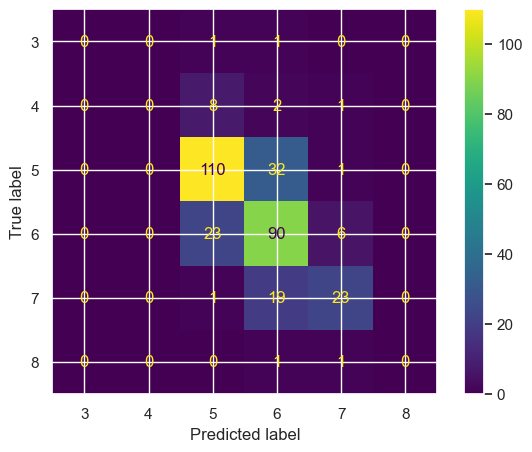

In [66]:
clf = KNeighborsClassifier(n_neighbors=20, weights='distance')
clf.fit(X_train, y_train)

final_model_evaluation(clf, X_test, y_test)

#### NN

In [67]:
import keras
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

In [68]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

encoded_Y = LabelEncoder().fit_transform(y)

y = to_categorical(encoded_Y)

X = (X - X.mean()) / X.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [69]:
def build_fn(hidden_layer_width=10, hidden_layer_depth=4, activation='relu', learning_rate=.001):
    nn = keras.Sequential()
    nn.add(keras.layers.Dense(hidden_layer_width, activation=activation, input_shape=(X_train.shape[1],)))
    
    for i in range(hidden_layer_depth):
        nn.add(keras.layers.Dense(hidden_layer_width, activation=activation))
        
    nn.add(keras.layers.Dense(y.shape[1], activation='softmax'))
    
    nn.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    
    return nn

In [70]:
param_range=np.arange(1, 15, 1)
train_scores, validation_scores = validation_curve(
    KerasClassifier(build_fn=build_fn, epochs=100, batch_size=256), 
    X_train,
    y_train,
    param_name='hidden_layer_depth',
    param_range=param_range,
    cv=5
)

C:\Users\legen\AppData\Local\Temp\ipykernel_20456\2168623324.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=build_fn, epochs=100, batch_size=256),


Epoch 1/100
4/4 [==============================] - 10s 772ms/step - loss: 1.7061 - accuracy: 0.3754
Epoch 2/100
4/4 [==============================] - 2s 570ms/step - loss: 1.6808 - accuracy: 0.3812
Epoch 3/100
4/4 [==============================] - 3s 723ms/step - loss: 1.6560 - accuracy: 0.3920
Epoch 4/100
4/4 [==============================] - 2s 639ms/step - loss: 1.6322 - accuracy: 0.3959
Epoch 5/100
4/4 [==============================] - 3s 624ms/step - loss: 1.6092 - accuracy: 0.3949
Epoch 6/100
4/4 [==============================] - 2s 377ms/step - loss: 1.5870 - accuracy: 0.4018
Epoch 7/100
4/4 [==============================] - 3s 654ms/step - loss: 1.5657 - accuracy: 0.4027
Epoch 8/100
4/4 [==============================] - 2s 507ms/step - loss: 1.5441 - accuracy: 0.4096
Epoch 9/100
4/4 [==============================] - 3s 762ms/step - loss: 1.5235 - accuracy: 0.4086
Epoch 10/100
4/4 [==============================] - 3s 756ms/step - loss: 1.5028 - accuracy: 0.4076
Epoch 11

4/4 [==============================] - 4s 878ms/step - loss: 1.0158 - accuracy: 0.5924
Epoch 84/100
4/4 [==============================] - 3s 769ms/step - loss: 1.0144 - accuracy: 0.5934
Epoch 85/100
4/4 [==============================] - 3s 790ms/step - loss: 1.0129 - accuracy: 0.5934
Epoch 86/100
4/4 [==============================] - 3s 815ms/step - loss: 1.0115 - accuracy: 0.5924
Epoch 87/100
4/4 [==============================] - 3s 823ms/step - loss: 1.0103 - accuracy: 0.5934
Epoch 88/100
4/4 [==============================] - 3s 814ms/step - loss: 1.0090 - accuracy: 0.5953
Epoch 89/100
4/4 [==============================] - 3s 768ms/step - loss: 1.0077 - accuracy: 0.5953
Epoch 90/100
4/4 [==============================] - 3s 710ms/step - loss: 1.0065 - accuracy: 0.5943
Epoch 91/100
4/4 [==============================] - 3s 608ms/step - loss: 1.0053 - accuracy: 0.5963
Epoch 92/100
4/4 [==============================] - 3s 856ms/step - loss: 1.0042 - accuracy: 0.5943
Epoch 93/100


4/4 [==============================] - 3s 863ms/step - loss: 1.1399 - accuracy: 0.4868
Epoch 44/100
4/4 [==============================] - 2s 465ms/step - loss: 1.1333 - accuracy: 0.4966
Epoch 45/100
4/4 [==============================] - 3s 722ms/step - loss: 1.1273 - accuracy: 0.5054
Epoch 46/100
4/4 [==============================] - 3s 568ms/step - loss: 1.1206 - accuracy: 0.5103
Epoch 47/100
4/4 [==============================] - 0s 14ms/step - loss: 1.1143 - accuracy: 0.5152
Epoch 48/100
4/4 [==============================] - 0s 21ms/step - loss: 1.1084 - accuracy: 0.5230
Epoch 49/100
4/4 [==============================] - 0s 14ms/step - loss: 1.1029 - accuracy: 0.5288
Epoch 50/100
4/4 [==============================] - 0s 20ms/step - loss: 1.0973 - accuracy: 0.5445
Epoch 51/100
4/4 [==============================] - 0s 117ms/step - loss: 1.0923 - accuracy: 0.5435
Epoch 52/100
4/4 [==============================] - 0s 32ms/step - loss: 1.0868 - accuracy: 0.5464
Epoch 53/100
4/4 [

4/4 [==============================] - 0s 7ms/step - loss: 0.9588 - accuracy: 0.6051
Epoch 94/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9571 - accuracy: 0.6051
Epoch 95/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9562 - accuracy: 0.6070
Epoch 96/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9550 - accuracy: 0.6061
Epoch 97/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9542 - accuracy: 0.6061
Epoch 98/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9529 - accuracy: 0.6022
Epoch 99/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9522 - accuracy: 0.6100
Epoch 100/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9497 - accuracy: 0.6109
Epoch 1/100
4/4 [==============================] - 0s 9ms/step - loss: 1.7969 - accuracy: 0.0430
Epoch 2/100
4/4 [==============================] - 0s 13ms/step - loss: 1.7902 - accuracy: 0.2004
Epoch 3/100
4/4 [================

4/4 [==============================] - 0s 8ms/step - loss: 0.9637 - accuracy: 0.6031
Epoch 76/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9616 - accuracy: 0.6041
Epoch 77/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9599 - accuracy: 0.6090
Epoch 78/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9574 - accuracy: 0.6139
Epoch 79/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9553 - accuracy: 0.6158
Epoch 80/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9538 - accuracy: 0.6070
Epoch 81/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9515 - accuracy: 0.6100
Epoch 82/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9491 - accuracy: 0.6119
Epoch 83/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9472 - accuracy: 0.6149
Epoch 84/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9454 - accuracy: 0.6188
Epoch 85/100
4/4 [==============

4/4 [==============================] - 0s 7ms/step - loss: 1.0729 - accuracy: 0.5650
Epoch 39/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0691 - accuracy: 0.5660
Epoch 40/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0652 - accuracy: 0.5718
Epoch 41/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0616 - accuracy: 0.5718
Epoch 42/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0575 - accuracy: 0.5758
Epoch 43/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0530 - accuracy: 0.5738
Epoch 44/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0494 - accuracy: 0.5767
Epoch 45/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0459 - accuracy: 0.5797
Epoch 46/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0424 - accuracy: 0.5816
Epoch 47/100
4/4 [==============================] - 0s 9ms/step - loss: 1.0383 - accuracy: 0.5865
Epoch 48/100
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 1.3064 - accuracy: 0.4213
Epoch 21/100
4/4 [==============================] - 0s 7ms/step - loss: 1.2889 - accuracy: 0.4213
Epoch 22/100
4/4 [==============================] - 0s 8ms/step - loss: 1.2727 - accuracy: 0.4213
Epoch 23/100
4/4 [==============================] - 0s 8ms/step - loss: 1.2580 - accuracy: 0.4213
Epoch 24/100
4/4 [==============================] - 0s 8ms/step - loss: 1.2458 - accuracy: 0.4213
Epoch 25/100
4/4 [==============================] - 0s 8ms/step - loss: 1.2350 - accuracy: 0.4213
Epoch 26/100
4/4 [==============================] - 0s 8ms/step - loss: 1.2253 - accuracy: 0.4213
Epoch 27/100
4/4 [==============================] - 0s 8ms/step - loss: 1.2172 - accuracy: 0.4213
Epoch 28/100
4/4 [==============================] - 0s 8ms/step - loss: 1.2099 - accuracy: 0.4213
Epoch 29/100
4/4 [==============================] - 0s 8ms/step - loss: 1.2037 - accuracy: 0.4213
Epoch 30/100
4/4 [===============

Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 1.7665 - accuracy: 0.4057
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 1.7492 - accuracy: 0.3881
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 1.7288 - accuracy: 0.3861
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 1.7047 - accuracy: 0.3871
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 1.6759 - accuracy: 0.3871
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 1.6391 - accuracy: 0.3871
Epoch 8/100
4/4 [==============================] - 0s 8ms/step - loss: 1.5973 - accuracy: 0.3861
Epoch 9/100
4/4 [==============================] - 0s 8ms/step - loss: 1.5469 - accuracy: 0.3861
Epoch 10/100
4/4 [==============================] - 0s 7ms/step - loss: 1.4904 - accuracy: 0.3959
Epoch 11/100
4/4 [==============================] - 0s 7ms/step - loss: 1.4297 - accuracy: 0.4233
Epoch 12/100
4/4 [==========

4/4 [==============================] - 0s 8ms/step - loss: 1.0794 - accuracy: 0.5122
Epoch 68/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0772 - accuracy: 0.5259
Epoch 69/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0735 - accuracy: 0.5327
Epoch 70/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0702 - accuracy: 0.5259
Epoch 71/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0664 - accuracy: 0.5367
Epoch 72/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0634 - accuracy: 0.5367
Epoch 73/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0592 - accuracy: 0.5367
Epoch 74/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0556 - accuracy: 0.5396
Epoch 75/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0521 - accuracy: 0.5406
Epoch 76/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0483 - accuracy: 0.5406
Epoch 77/100
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 1.1057 - accuracy: 0.5239
Epoch 50/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1030 - accuracy: 0.5200
Epoch 51/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1002 - accuracy: 0.5210
Epoch 52/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0970 - accuracy: 0.5279
Epoch 53/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0940 - accuracy: 0.5298
Epoch 54/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0919 - accuracy: 0.5308
Epoch 55/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0889 - accuracy: 0.5357
Epoch 56/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0861 - accuracy: 0.5435
Epoch 57/100
4/4 [==============================] - 0s 9ms/step - loss: 1.0833 - accuracy: 0.5386
Epoch 58/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0803 - accuracy: 0.5357
Epoch 59/100
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 1.1740 - accuracy: 0.4213
Epoch 32/100
4/4 [==============================] - 0s 10ms/step - loss: 1.1676 - accuracy: 0.4213
Epoch 33/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1589 - accuracy: 0.4790
Epoch 34/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1524 - accuracy: 0.5093
Epoch 35/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1458 - accuracy: 0.5054
Epoch 36/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1397 - accuracy: 0.5161
Epoch 37/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1345 - accuracy: 0.5269
Epoch 38/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1298 - accuracy: 0.5288
Epoch 39/100
4/4 [==============================] - 0s 9ms/step - loss: 1.1249 - accuracy: 0.5279
Epoch 40/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1198 - accuracy: 0.5435
Epoch 41/100
4/4 [==============

4/4 [==============================] - 0s 9ms/step - loss: 1.4460 - accuracy: 0.3871
Epoch 14/100
4/4 [==============================] - 0s 9ms/step - loss: 1.4148 - accuracy: 0.3871
Epoch 15/100
4/4 [==============================] - 0s 9ms/step - loss: 1.3886 - accuracy: 0.3871
Epoch 16/100
4/4 [==============================] - 0s 8ms/step - loss: 1.3616 - accuracy: 0.3871
Epoch 17/100
4/4 [==============================] - 0s 8ms/step - loss: 1.3357 - accuracy: 0.3871
Epoch 18/100
4/4 [==============================] - 0s 9ms/step - loss: 1.3160 - accuracy: 0.4340
Epoch 19/100
4/4 [==============================] - 0s 8ms/step - loss: 1.3032 - accuracy: 0.4213
Epoch 20/100
4/4 [==============================] - 0s 8ms/step - loss: 1.2919 - accuracy: 0.4213
Epoch 21/100
4/4 [==============================] - 0s 9ms/step - loss: 1.2821 - accuracy: 0.4213
Epoch 22/100
4/4 [==============================] - 0s 9ms/step - loss: 1.2720 - accuracy: 0.4213
Epoch 23/100
4/4 [===============

4/4 [==============================] - 0s 12ms/step - loss: 1.0572 - accuracy: 0.5699
Epoch 78/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0546 - accuracy: 0.5591
Epoch 79/100
4/4 [==============================] - 0s 32ms/step - loss: 1.0503 - accuracy: 0.5660
Epoch 80/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0475 - accuracy: 0.5758
Epoch 81/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0460 - accuracy: 0.5591
Epoch 82/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0400 - accuracy: 0.5728
Epoch 83/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0401 - accuracy: 0.5679
Epoch 84/100
4/4 [==============================] - 0s 10ms/step - loss: 1.0357 - accuracy: 0.5738
Epoch 85/100
4/4 [==============================] - 0s 12ms/step - loss: 1.0319 - accuracy: 0.5728
Epoch 86/100
4/4 [==============================] - 0s 11ms/step - loss: 1.0307 - accuracy: 0.5748
Epoch 87/100
4/4 [=====

4/4 [==============================] - 0s 5ms/step - loss: 1.1221 - accuracy: 0.5611
Epoch 41/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1131 - accuracy: 0.5660
Epoch 42/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1047 - accuracy: 0.5728
Epoch 43/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0968 - accuracy: 0.5767
Epoch 44/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0897 - accuracy: 0.5806
Epoch 45/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0822 - accuracy: 0.5777
Epoch 46/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0757 - accuracy: 0.5767
Epoch 47/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0695 - accuracy: 0.5787
Epoch 48/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0632 - accuracy: 0.5787
Epoch 49/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0574 - accuracy: 0.5797
Epoch 50/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.2277 - accuracy: 0.5367
Epoch 23/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2145 - accuracy: 0.5415
Epoch 24/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2030 - accuracy: 0.5455
Epoch 25/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1939 - accuracy: 0.5494
Epoch 26/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1849 - accuracy: 0.5513
Epoch 27/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1767 - accuracy: 0.5552
Epoch 28/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1688 - accuracy: 0.5611
Epoch 29/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1610 - accuracy: 0.5621
Epoch 30/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1533 - accuracy: 0.5591
Epoch 31/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1458 - accuracy: 0.5601
Epoch 32/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.9609 - accuracy: 0.5943
Epoch 87/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9596 - accuracy: 0.5953
Epoch 88/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9575 - accuracy: 0.5953
Epoch 89/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9561 - accuracy: 0.5992
Epoch 90/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9541 - accuracy: 0.5963
Epoch 91/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9525 - accuracy: 0.6012
Epoch 92/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9513 - accuracy: 0.5963
Epoch 93/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9492 - accuracy: 0.5992
Epoch 94/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9478 - accuracy: 0.5982
Epoch 95/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9467 - accuracy: 0.5982
Epoch 96/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 0.9335 - accuracy: 0.6237
Epoch 69/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9319 - accuracy: 0.6227
Epoch 70/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9303 - accuracy: 0.6237
Epoch 71/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9282 - accuracy: 0.6207
Epoch 72/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9271 - accuracy: 0.6246
Epoch 73/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9251 - accuracy: 0.6217
Epoch 74/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9234 - accuracy: 0.6256
Epoch 75/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9223 - accuracy: 0.6285
Epoch 76/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9204 - accuracy: 0.6285
Epoch 77/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9192 - accuracy: 0.6246
Epoch 78/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.1810 - accuracy: 0.4428
Epoch 51/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1744 - accuracy: 0.4506
Epoch 52/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1677 - accuracy: 0.4545
Epoch 53/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1620 - accuracy: 0.4555
Epoch 54/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1554 - accuracy: 0.4673
Epoch 55/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1500 - accuracy: 0.4692
Epoch 56/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1443 - accuracy: 0.4731
Epoch 57/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1384 - accuracy: 0.4907
Epoch 58/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1324 - accuracy: 0.5122
Epoch 59/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1261 - accuracy: 0.5161
Epoch 60/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.1510 - accuracy: 0.4467
Epoch 33/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1452 - accuracy: 0.4487
Epoch 34/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1405 - accuracy: 0.4790
Epoch 35/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1346 - accuracy: 0.4907
Epoch 36/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1306 - accuracy: 0.4800
Epoch 37/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1247 - accuracy: 0.4790
Epoch 38/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1194 - accuracy: 0.5093
Epoch 39/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1145 - accuracy: 0.5327
Epoch 40/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1098 - accuracy: 0.5308
Epoch 41/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1046 - accuracy: 0.5298
Epoch 42/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 1.4554 - accuracy: 0.4350
Epoch 15/100
4/4 [==============================] - 0s 7ms/step - loss: 1.4099 - accuracy: 0.4350
Epoch 16/100
4/4 [==============================] - 0s 7ms/step - loss: 1.3686 - accuracy: 0.4350
Epoch 17/100
4/4 [==============================] - 0s 6ms/step - loss: 1.3306 - accuracy: 0.4350
Epoch 18/100
4/4 [==============================] - 0s 7ms/step - loss: 1.2914 - accuracy: 0.4350
Epoch 19/100
4/4 [==============================] - 0s 7ms/step - loss: 1.2531 - accuracy: 0.4350
Epoch 20/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2204 - accuracy: 0.4350
Epoch 21/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1930 - accuracy: 0.4350
Epoch 22/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1791 - accuracy: 0.4350
Epoch 23/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1697 - accuracy: 0.4350
Epoch 24/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 0.9582 - accuracy: 0.5846
Epoch 80/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9555 - accuracy: 0.5806
Epoch 81/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9503 - accuracy: 0.5855
Epoch 82/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9473 - accuracy: 0.5797
Epoch 83/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9451 - accuracy: 0.5875
Epoch 84/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9432 - accuracy: 0.5855
Epoch 85/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9415 - accuracy: 0.5855
Epoch 86/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9383 - accuracy: 0.5924
Epoch 87/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9356 - accuracy: 0.5885
Epoch 88/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9354 - accuracy: 0.5885
Epoch 89/100
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 1.0273 - accuracy: 0.5513
Epoch 62/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0219 - accuracy: 0.5552
Epoch 63/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0176 - accuracy: 0.5503
Epoch 64/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0123 - accuracy: 0.5513
Epoch 65/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0075 - accuracy: 0.5523
Epoch 66/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0016 - accuracy: 0.5552
Epoch 67/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9966 - accuracy: 0.5552
Epoch 68/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9915 - accuracy: 0.5562
Epoch 69/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9861 - accuracy: 0.5640
Epoch 70/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9805 - accuracy: 0.5572
Epoch 71/100
4/4 [===============

4/4 [==============================] - 0s 7ms/step - loss: 1.0550 - accuracy: 0.5533
Epoch 44/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0481 - accuracy: 0.5630
Epoch 45/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0391 - accuracy: 0.5670
Epoch 46/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0315 - accuracy: 0.5709
Epoch 47/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0231 - accuracy: 0.5709
Epoch 48/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0152 - accuracy: 0.5767
Epoch 49/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0102 - accuracy: 0.5728
Epoch 50/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0022 - accuracy: 0.5758
Epoch 51/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9954 - accuracy: 0.5787
Epoch 52/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9894 - accuracy: 0.5777
Epoch 53/100
4/4 [===============

Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 1.6925 - accuracy: 0.4350
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 1.6563 - accuracy: 0.4350
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 1.6103 - accuracy: 0.4350
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 1.5542 - accuracy: 0.4350
Epoch 10/100
4/4 [==============================] - 0s 12ms/step - loss: 1.4919 - accuracy: 0.4350
Epoch 11/100
4/4 [==============================] - 0s 11ms/step - loss: 1.4264 - accuracy: 0.4350
Epoch 12/100
4/4 [==============================] - 0s 10ms/step - loss: 1.3690 - accuracy: 0.4350
Epoch 13/100
4/4 [==============================] - 0s 10ms/step - loss: 1.3372 - accuracy: 0.4350
Epoch 14/100
4/4 [==============================] - 0s 9ms/step - loss: 1.3233 - accuracy: 0.4350
Epoch 15/100
4/4 [==============================] - 0s 11ms/step - loss: 1.3056 - accuracy: 0.4350
Epoch 16/100
4/4

4/4 [==============================] - 0s 8ms/step - loss: 1.0745 - accuracy: 0.5327
Epoch 70/100
4/4 [==============================] - 0s 9ms/step - loss: 1.0728 - accuracy: 0.5357
Epoch 71/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0702 - accuracy: 0.5386
Epoch 72/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0680 - accuracy: 0.5396
Epoch 73/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0655 - accuracy: 0.5376
Epoch 74/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0635 - accuracy: 0.5376
Epoch 75/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0612 - accuracy: 0.5464
Epoch 76/100
4/4 [==============================] - 0s 9ms/step - loss: 1.0593 - accuracy: 0.5503
Epoch 77/100
4/4 [==============================] - 0s 9ms/step - loss: 1.0574 - accuracy: 0.5474
Epoch 78/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0549 - accuracy: 0.5513
Epoch 79/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.0829 - accuracy: 0.5846
Epoch 52/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0778 - accuracy: 0.5865
Epoch 53/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0733 - accuracy: 0.5904
Epoch 54/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0690 - accuracy: 0.5904
Epoch 55/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0651 - accuracy: 0.5904
Epoch 56/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0611 - accuracy: 0.5934
Epoch 57/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0573 - accuracy: 0.5982
Epoch 58/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0538 - accuracy: 0.5992
Epoch 59/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0502 - accuracy: 0.6041
Epoch 60/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0468 - accuracy: 0.6051
Epoch 61/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.0377 - accuracy: 0.5894
Epoch 34/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0324 - accuracy: 0.5904
Epoch 35/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0275 - accuracy: 0.5904
Epoch 36/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0223 - accuracy: 0.5875
Epoch 37/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0181 - accuracy: 0.5904
Epoch 38/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0141 - accuracy: 0.5973
Epoch 39/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0101 - accuracy: 0.5973
Epoch 40/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0064 - accuracy: 0.5992
Epoch 41/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0033 - accuracy: 0.5982
Epoch 42/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0003 - accuracy: 0.6022
Epoch 43/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.4989 - accuracy: 0.4692
Epoch 16/100
4/4 [==============================] - 0s 6ms/step - loss: 1.4649 - accuracy: 0.4741
Epoch 17/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4309 - accuracy: 0.4751
Epoch 18/100
4/4 [==============================] - 0s 6ms/step - loss: 1.3960 - accuracy: 0.4741
Epoch 19/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3615 - accuracy: 0.4761
Epoch 20/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3300 - accuracy: 0.4761
Epoch 21/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3013 - accuracy: 0.4761
Epoch 22/100
4/4 [==============================] - 0s 6ms/step - loss: 1.2737 - accuracy: 0.4761
Epoch 23/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2495 - accuracy: 0.4809
Epoch 24/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2283 - accuracy: 0.4848
Epoch 25/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.9248 - accuracy: 0.6266
Epoch 81/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9227 - accuracy: 0.6276
Epoch 82/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9213 - accuracy: 0.6276
Epoch 83/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9195 - accuracy: 0.6285
Epoch 84/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9180 - accuracy: 0.6305
Epoch 85/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9162 - accuracy: 0.6295
Epoch 86/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9153 - accuracy: 0.6285
Epoch 87/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9135 - accuracy: 0.6325
Epoch 88/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9118 - accuracy: 0.6393
Epoch 89/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9105 - accuracy: 0.6422
Epoch 90/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.9429 - accuracy: 0.6373
Epoch 63/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9376 - accuracy: 0.6364
Epoch 64/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9331 - accuracy: 0.6364
Epoch 65/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9290 - accuracy: 0.6373
Epoch 66/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9249 - accuracy: 0.6393
Epoch 67/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9212 - accuracy: 0.6413
Epoch 68/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9178 - accuracy: 0.6442
Epoch 69/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9150 - accuracy: 0.6442
Epoch 70/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9115 - accuracy: 0.6442
Epoch 71/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9088 - accuracy: 0.6442
Epoch 72/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.0853 - accuracy: 0.5445
Epoch 45/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0808 - accuracy: 0.5435
Epoch 46/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0766 - accuracy: 0.5435
Epoch 47/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0722 - accuracy: 0.5484
Epoch 48/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0675 - accuracy: 0.5513
Epoch 49/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0635 - accuracy: 0.5503
Epoch 50/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0593 - accuracy: 0.5562
Epoch 51/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0557 - accuracy: 0.5582
Epoch 52/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0510 - accuracy: 0.5621
Epoch 53/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0474 - accuracy: 0.5621
Epoch 54/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.2295 - accuracy: 0.4008
Epoch 27/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2184 - accuracy: 0.4008
Epoch 28/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2100 - accuracy: 0.4018
Epoch 29/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2036 - accuracy: 0.4242
Epoch 30/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1979 - accuracy: 0.4702
Epoch 31/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1930 - accuracy: 0.5064
Epoch 32/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1892 - accuracy: 0.5249
Epoch 33/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1856 - accuracy: 0.4995
Epoch 34/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1806 - accuracy: 0.5044
Epoch 35/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1777 - accuracy: 0.5220
Epoch 36/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.7254 - accuracy: 0.4340
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7108 - accuracy: 0.4340
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6934 - accuracy: 0.4340
Epoch 11/100
4/4 [==============================] - 0s 6ms/step - loss: 1.6724 - accuracy: 0.4340
Epoch 12/100
4/4 [==============================] - 0s 6ms/step - loss: 1.6473 - accuracy: 0.4340
Epoch 13/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6162 - accuracy: 0.4340
Epoch 14/100
4/4 [==============================] - 0s 6ms/step - loss: 1.5794 - accuracy: 0.4340
Epoch 15/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5350 - accuracy: 0.4340
Epoch 16/100
4/4 [==============================] - 0s 6ms/step - loss: 1.4841 - accuracy: 0.4340
Epoch 17/100
4/4 [==============================] - 0s 6ms/step - loss: 1.4279 - accuracy: 0.4340
Epoch 18/100
4/4 [================

4/4 [==============================] - 0s 8ms/step - loss: 0.9822 - accuracy: 0.5963
Epoch 74/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9798 - accuracy: 0.5982
Epoch 75/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9772 - accuracy: 0.5973
Epoch 76/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9724 - accuracy: 0.6022
Epoch 77/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9714 - accuracy: 0.6022
Epoch 78/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9674 - accuracy: 0.6041
Epoch 79/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9645 - accuracy: 0.6070
Epoch 80/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9650 - accuracy: 0.6119
Epoch 81/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9574 - accuracy: 0.6109
Epoch 82/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9577 - accuracy: 0.6051
Epoch 83/100
4/4 [===============

4/4 [==============================] - 0s 7ms/step - loss: 0.9446 - accuracy: 0.6041
Epoch 56/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9413 - accuracy: 0.6041
Epoch 57/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9382 - accuracy: 0.6061
Epoch 58/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9344 - accuracy: 0.6070
Epoch 59/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9312 - accuracy: 0.6061
Epoch 60/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9299 - accuracy: 0.6061
Epoch 61/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9278 - accuracy: 0.6061
Epoch 62/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9263 - accuracy: 0.6109
Epoch 63/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9236 - accuracy: 0.6080
Epoch 64/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9238 - accuracy: 0.6100
Epoch 65/100
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 1.0215 - accuracy: 0.5836
Epoch 38/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0125 - accuracy: 0.5777
Epoch 39/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0056 - accuracy: 0.5806
Epoch 40/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9985 - accuracy: 0.5924
Epoch 41/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9914 - accuracy: 0.5934
Epoch 42/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9850 - accuracy: 0.5992
Epoch 43/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9802 - accuracy: 0.6041
Epoch 44/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9739 - accuracy: 0.6061
Epoch 45/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9690 - accuracy: 0.6100
Epoch 46/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9631 - accuracy: 0.6207
Epoch 47/100
4/4 [===============

4/4 [==============================] - 7s 2s/step - loss: 1.2690 - accuracy: 0.4340
Epoch 20/100
4/4 [==============================] - 7s 2s/step - loss: 1.2504 - accuracy: 0.4340
Epoch 21/100
4/4 [==============================] - 6s 1s/step - loss: 1.2361 - accuracy: 0.4340
Epoch 22/100
4/4 [==============================] - 8s 2s/step - loss: 1.2231 - accuracy: 0.4340
Epoch 23/100
4/4 [==============================] - 7s 2s/step - loss: 1.2129 - accuracy: 0.4340
Epoch 24/100
4/4 [==============================] - 8s 2s/step - loss: 1.2045 - accuracy: 0.4340
Epoch 25/100
4/4 [==============================] - 7s 2s/step - loss: 1.1964 - accuracy: 0.4340
Epoch 26/100
4/4 [==============================] - 7s 2s/step - loss: 1.1895 - accuracy: 0.4340
Epoch 27/100
4/4 [==============================] - 5s 982ms/step - loss: 1.1828 - accuracy: 0.4340
Epoch 28/100
4/4 [==============================] - 0s 21ms/step - loss: 1.1768 - accuracy: 0.4340
Epoch 29/100
4/4 [====================

4/4 [==============================] - 0s 8ms/step - loss: 0.9556 - accuracy: 0.6119
Epoch 84/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9504 - accuracy: 0.6100
Epoch 85/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9482 - accuracy: 0.6149
Epoch 86/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9492 - accuracy: 0.6129
Epoch 87/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9384 - accuracy: 0.6217
Epoch 88/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9376 - accuracy: 0.6168
Epoch 89/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9364 - accuracy: 0.6197
Epoch 90/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9316 - accuracy: 0.6197
Epoch 91/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9265 - accuracy: 0.6276
Epoch 92/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9280 - accuracy: 0.6295
Epoch 93/100
4/4 [==============

4/4 [==============================] - 0s 9ms/step - loss: 0.9739 - accuracy: 0.6022
Epoch 66/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9706 - accuracy: 0.5973
Epoch 67/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9654 - accuracy: 0.6002
Epoch 68/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9624 - accuracy: 0.6061
Epoch 69/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9583 - accuracy: 0.5973
Epoch 70/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9553 - accuracy: 0.6002
Epoch 71/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9516 - accuracy: 0.6002
Epoch 72/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9484 - accuracy: 0.6041
Epoch 73/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9453 - accuracy: 0.6070
Epoch 74/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9429 - accuracy: 0.6041
Epoch 75/100
4/4 [===============

4/4 [==============================] - 0s 3ms/step - loss: 1.1625 - accuracy: 0.5533
Epoch 48/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1542 - accuracy: 0.5552
Epoch 49/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1468 - accuracy: 0.5562
Epoch 50/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1392 - accuracy: 0.5611
Epoch 51/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1323 - accuracy: 0.5640
Epoch 52/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1258 - accuracy: 0.5660
Epoch 53/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1196 - accuracy: 0.5640
Epoch 54/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1135 - accuracy: 0.5650
Epoch 55/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1079 - accuracy: 0.5679
Epoch 56/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1026 - accuracy: 0.5679
Epoch 57/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.2970 - accuracy: 0.5181
Epoch 30/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2801 - accuracy: 0.5249
Epoch 31/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2646 - accuracy: 0.5220
Epoch 32/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2496 - accuracy: 0.5269
Epoch 33/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2350 - accuracy: 0.5288
Epoch 34/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2216 - accuracy: 0.5318
Epoch 35/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2090 - accuracy: 0.5386
Epoch 36/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1971 - accuracy: 0.5455
Epoch 37/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1852 - accuracy: 0.5523
Epoch 38/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1742 - accuracy: 0.5543
Epoch 39/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.5313 - accuracy: 0.4291
Epoch 12/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5054 - accuracy: 0.4350
Epoch 13/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4785 - accuracy: 0.4370
Epoch 14/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4533 - accuracy: 0.4370
Epoch 15/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4272 - accuracy: 0.4379
Epoch 16/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4019 - accuracy: 0.4438
Epoch 17/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3779 - accuracy: 0.4457
Epoch 18/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3543 - accuracy: 0.4497
Epoch 19/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3330 - accuracy: 0.4594
Epoch 20/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3132 - accuracy: 0.4614
Epoch 21/100
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 0.9810 - accuracy: 0.5816
Epoch 76/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9794 - accuracy: 0.5797
Epoch 77/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9778 - accuracy: 0.5777
Epoch 78/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9767 - accuracy: 0.5787
Epoch 79/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9750 - accuracy: 0.5787
Epoch 80/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9737 - accuracy: 0.5797
Epoch 81/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9720 - accuracy: 0.5826
Epoch 82/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9714 - accuracy: 0.5836
Epoch 83/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9696 - accuracy: 0.5855
Epoch 84/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9683 - accuracy: 0.5826
Epoch 85/100
4/4 [==============

4/4 [==============================] - 0s 5ms/step - loss: 0.9896 - accuracy: 0.5934
Epoch 58/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9874 - accuracy: 0.5924
Epoch 59/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9857 - accuracy: 0.5924
Epoch 60/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9833 - accuracy: 0.5865
Epoch 61/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9812 - accuracy: 0.5885
Epoch 62/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9790 - accuracy: 0.5924
Epoch 63/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9768 - accuracy: 0.5963
Epoch 64/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9750 - accuracy: 0.5943
Epoch 65/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9734 - accuracy: 0.5904
Epoch 66/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9712 - accuracy: 0.5924
Epoch 67/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.1912 - accuracy: 0.4203
Epoch 40/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1862 - accuracy: 0.4203
Epoch 41/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1807 - accuracy: 0.4233
Epoch 42/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1759 - accuracy: 0.4194
Epoch 43/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1706 - accuracy: 0.4154
Epoch 44/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1649 - accuracy: 0.4242
Epoch 45/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1590 - accuracy: 0.4184
Epoch 46/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1540 - accuracy: 0.4233
Epoch 47/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1487 - accuracy: 0.4614
Epoch 48/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1426 - accuracy: 0.4878
Epoch 49/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 1.2358 - accuracy: 0.5367
Epoch 22/100
4/4 [==============================] - 0s 7ms/step - loss: 1.2205 - accuracy: 0.5103
Epoch 23/100
4/4 [==============================] - 0s 6ms/step - loss: 1.2081 - accuracy: 0.5044
Epoch 24/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1967 - accuracy: 0.5122
Epoch 25/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1873 - accuracy: 0.5611
Epoch 26/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1789 - accuracy: 0.5572
Epoch 27/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1704 - accuracy: 0.5621
Epoch 28/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1618 - accuracy: 0.5630
Epoch 29/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1529 - accuracy: 0.5679
Epoch 30/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1440 - accuracy: 0.5640
Epoch 31/100
4/4 [===============

Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 1.7686 - accuracy: 0.4487
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 1.7577 - accuracy: 0.4321
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 1.7459 - accuracy: 0.4262
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 1.7319 - accuracy: 0.4272
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 1.7158 - accuracy: 0.4262
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 1.6969 - accuracy: 0.4252
Epoch 9/100
4/4 [==============================] - 0s 8ms/step - loss: 1.6740 - accuracy: 0.4213
Epoch 10/100
4/4 [==============================] - 0s 7ms/step - loss: 1.6468 - accuracy: 0.4194
Epoch 11/100
4/4 [==============================] - 0s 6ms/step - loss: 1.6152 - accuracy: 0.4194
Epoch 12/100
4/4 [==============================] - 0s 6ms/step - loss: 1.5778 - accuracy: 0.4194
Epoch 13/100
4/4 [=========

4/4 [==============================] - 0s 6ms/step - loss: 0.9926 - accuracy: 0.5767
Epoch 69/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9893 - accuracy: 0.5787
Epoch 70/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9894 - accuracy: 0.5806
Epoch 71/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9858 - accuracy: 0.5797
Epoch 72/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9835 - accuracy: 0.5826
Epoch 73/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9816 - accuracy: 0.5914
Epoch 74/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9787 - accuracy: 0.5943
Epoch 75/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9785 - accuracy: 0.5904
Epoch 76/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9748 - accuracy: 0.6031
Epoch 77/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9727 - accuracy: 0.6022
Epoch 78/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 1.1580 - accuracy: 0.4194
Epoch 51/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1546 - accuracy: 0.4194
Epoch 52/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1510 - accuracy: 0.4194
Epoch 53/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1477 - accuracy: 0.4242
Epoch 54/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1438 - accuracy: 0.4350
Epoch 55/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1405 - accuracy: 0.4418
Epoch 56/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1375 - accuracy: 0.4565
Epoch 57/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1336 - accuracy: 0.4712
Epoch 58/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1311 - accuracy: 0.4761
Epoch 59/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1277 - accuracy: 0.4761
Epoch 60/100
4/4 [===============

4/4 [==============================] - 0s 7ms/step - loss: 1.1600 - accuracy: 0.4223
Epoch 33/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1551 - accuracy: 0.4282
Epoch 34/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1511 - accuracy: 0.4370
Epoch 35/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1469 - accuracy: 0.4506
Epoch 36/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1426 - accuracy: 0.4526
Epoch 37/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1387 - accuracy: 0.4633
Epoch 38/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1348 - accuracy: 0.4741
Epoch 39/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1313 - accuracy: 0.4790
Epoch 40/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1269 - accuracy: 0.4868
Epoch 41/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1201 - accuracy: 0.5132
Epoch 42/100
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 1.6505 - accuracy: 0.4800
Epoch 15/100
4/4 [==============================] - 0s 8ms/step - loss: 1.6293 - accuracy: 0.4809
Epoch 16/100
4/4 [==============================] - 0s 9ms/step - loss: 1.6058 - accuracy: 0.4956
Epoch 17/100
4/4 [==============================] - 0s 8ms/step - loss: 1.5779 - accuracy: 0.5132
Epoch 18/100
4/4 [==============================] - 0s 8ms/step - loss: 1.5469 - accuracy: 0.5112
Epoch 19/100
4/4 [==============================] - 0s 8ms/step - loss: 1.5133 - accuracy: 0.5259
Epoch 20/100
4/4 [==============================] - 0s 8ms/step - loss: 1.4799 - accuracy: 0.5288
Epoch 21/100
4/4 [==============================] - 0s 8ms/step - loss: 1.4478 - accuracy: 0.5210
Epoch 22/100
4/4 [==============================] - 0s 8ms/step - loss: 1.4229 - accuracy: 0.5064
Epoch 23/100
4/4 [==============================] - 0s 8ms/step - loss: 1.3981 - accuracy: 0.5064
Epoch 24/100
4/4 [===============

4/4 [==============================] - 0s 7ms/step - loss: 1.0125 - accuracy: 0.5728
Epoch 80/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0098 - accuracy: 0.5679
Epoch 81/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0078 - accuracy: 0.5709
Epoch 82/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0047 - accuracy: 0.5738
Epoch 83/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0030 - accuracy: 0.5709
Epoch 84/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9996 - accuracy: 0.5709
Epoch 85/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9974 - accuracy: 0.5777
Epoch 86/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9942 - accuracy: 0.5777
Epoch 87/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9920 - accuracy: 0.5777
Epoch 88/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9888 - accuracy: 0.5758
Epoch 89/100
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 1.1372 - accuracy: 0.4154
Epoch 62/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1342 - accuracy: 0.4154
Epoch 63/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1305 - accuracy: 0.4184
Epoch 64/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1279 - accuracy: 0.4203
Epoch 65/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1250 - accuracy: 0.4203
Epoch 66/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1228 - accuracy: 0.4223
Epoch 67/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1196 - accuracy: 0.4291
Epoch 68/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1160 - accuracy: 0.4223
Epoch 69/100
4/4 [==============================] - 0s 11ms/step - loss: 1.1133 - accuracy: 0.4516
Epoch 70/100
4/4 [==============================] - 0s 9ms/step - loss: 1.1091 - accuracy: 0.4663
Epoch 71/100
4/4 [==============

4/4 [==============================] - 0s 3ms/step - loss: 1.6020 - accuracy: 0.4512
Epoch 44/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5954 - accuracy: 0.4912
Epoch 45/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5888 - accuracy: 0.4902
Epoch 46/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5817 - accuracy: 0.4922
Epoch 47/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5746 - accuracy: 0.4941
Epoch 48/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5674 - accuracy: 0.4912
Epoch 49/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5605 - accuracy: 0.4922
Epoch 50/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5531 - accuracy: 0.4902
Epoch 51/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5453 - accuracy: 0.4863
Epoch 52/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5374 - accuracy: 0.4883
Epoch 53/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.2558 - accuracy: 0.5166
Epoch 26/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2419 - accuracy: 0.5166
Epoch 27/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2285 - accuracy: 0.5176
Epoch 28/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2153 - accuracy: 0.5273
Epoch 29/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2035 - accuracy: 0.5332
Epoch 30/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1924 - accuracy: 0.5303
Epoch 31/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1816 - accuracy: 0.5332
Epoch 32/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1708 - accuracy: 0.5420
Epoch 33/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1610 - accuracy: 0.5430
Epoch 34/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1514 - accuracy: 0.5420
Epoch 35/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.7053 - accuracy: 0.4160
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6873 - accuracy: 0.4238
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6678 - accuracy: 0.4316
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6482 - accuracy: 0.4209
Epoch 11/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6269 - accuracy: 0.4180
Epoch 12/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6036 - accuracy: 0.4180
Epoch 13/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5792 - accuracy: 0.4170
Epoch 14/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5528 - accuracy: 0.4180
Epoch 15/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5259 - accuracy: 0.4229
Epoch 16/100
4/4 [==============================] - 0s 3ms/step - loss: 1.4967 - accuracy: 0.4307
Epoch 17/100
4/4 [=================

4/4 [==============================] - 0s 4ms/step - loss: 0.9153 - accuracy: 0.6260
Epoch 73/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9143 - accuracy: 0.6279
Epoch 74/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9127 - accuracy: 0.6260
Epoch 75/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9111 - accuracy: 0.6279
Epoch 76/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9099 - accuracy: 0.6289
Epoch 77/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9084 - accuracy: 0.6309
Epoch 78/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9072 - accuracy: 0.6318
Epoch 79/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9059 - accuracy: 0.6328
Epoch 80/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9046 - accuracy: 0.6338
Epoch 81/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9036 - accuracy: 0.6309
Epoch 82/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.0036 - accuracy: 0.5889
Epoch 55/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9981 - accuracy: 0.5947
Epoch 56/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9934 - accuracy: 0.5938
Epoch 57/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9884 - accuracy: 0.5938
Epoch 58/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9843 - accuracy: 0.5947
Epoch 59/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9799 - accuracy: 0.5967
Epoch 60/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9756 - accuracy: 0.6006
Epoch 61/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9717 - accuracy: 0.6045
Epoch 62/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9677 - accuracy: 0.6055
Epoch 63/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9646 - accuracy: 0.6006
Epoch 64/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.1228 - accuracy: 0.4893
Epoch 37/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1198 - accuracy: 0.4961
Epoch 38/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1164 - accuracy: 0.5010
Epoch 39/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1132 - accuracy: 0.5039
Epoch 40/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1102 - accuracy: 0.5088
Epoch 41/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1071 - accuracy: 0.5244
Epoch 42/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1045 - accuracy: 0.5322
Epoch 43/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1014 - accuracy: 0.5400
Epoch 44/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0983 - accuracy: 0.5410
Epoch 45/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0955 - accuracy: 0.5410
Epoch 46/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 1.6687 - accuracy: 0.4316
Epoch 19/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6523 - accuracy: 0.4229
Epoch 20/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6324 - accuracy: 0.4248
Epoch 21/100
4/4 [==============================] - 0s 7ms/step - loss: 1.6075 - accuracy: 0.4170
Epoch 22/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5779 - accuracy: 0.4043
Epoch 23/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5402 - accuracy: 0.4082
Epoch 24/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4959 - accuracy: 0.4229
Epoch 25/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4423 - accuracy: 0.4307
Epoch 26/100
4/4 [==============================] - 0s 6ms/step - loss: 1.3869 - accuracy: 0.4570
Epoch 27/100
4/4 [==============================] - 0s 6ms/step - loss: 1.3315 - accuracy: 0.4736
Epoch 28/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 0.9218 - accuracy: 0.6211
Epoch 83/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9183 - accuracy: 0.6201
Epoch 84/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9142 - accuracy: 0.6211
Epoch 85/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9104 - accuracy: 0.6230
Epoch 86/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9087 - accuracy: 0.6221
Epoch 87/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9051 - accuracy: 0.6240
Epoch 88/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8998 - accuracy: 0.6270
Epoch 89/100
4/4 [==============================] - 0s 6ms/step - loss: 0.8964 - accuracy: 0.6250
Epoch 90/100
4/4 [==============================] - 0s 6ms/step - loss: 0.8932 - accuracy: 0.6250
Epoch 91/100
4/4 [==============================] - 0s 6ms/step - loss: 0.8897 - accuracy: 0.6279
Epoch 92/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 0.9988 - accuracy: 0.5938
Epoch 65/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9945 - accuracy: 0.5977
Epoch 66/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9924 - accuracy: 0.5977
Epoch 67/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9886 - accuracy: 0.5947
Epoch 68/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9863 - accuracy: 0.5977
Epoch 69/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9840 - accuracy: 0.5977
Epoch 70/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9813 - accuracy: 0.5957
Epoch 71/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9782 - accuracy: 0.5986
Epoch 72/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9762 - accuracy: 0.5977
Epoch 73/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9740 - accuracy: 0.5977
Epoch 74/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 1.1078 - accuracy: 0.5166
Epoch 47/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1040 - accuracy: 0.5254
Epoch 48/100
4/4 [==============================] - 0s 6ms/step - loss: 1.1007 - accuracy: 0.5352
Epoch 49/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0964 - accuracy: 0.5420
Epoch 50/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0920 - accuracy: 0.5439
Epoch 51/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0882 - accuracy: 0.5459
Epoch 52/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0841 - accuracy: 0.5508
Epoch 53/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0788 - accuracy: 0.5479
Epoch 54/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0744 - accuracy: 0.5547
Epoch 55/100
4/4 [==============================] - 0s 8ms/step - loss: 1.0697 - accuracy: 0.5557
Epoch 56/100
4/4 [===============

4/4 [==============================] - 0s 7ms/step - loss: 1.1842 - accuracy: 0.4248
Epoch 29/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1807 - accuracy: 0.4248
Epoch 30/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1771 - accuracy: 0.4248
Epoch 31/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1737 - accuracy: 0.4248
Epoch 32/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1706 - accuracy: 0.4248
Epoch 33/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1670 - accuracy: 0.4248
Epoch 34/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1642 - accuracy: 0.4248
Epoch 35/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1603 - accuracy: 0.4248
Epoch 36/100
4/4 [==============================] - 0s 7ms/step - loss: 1.1572 - accuracy: 0.4248
Epoch 37/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1540 - accuracy: 0.4248
Epoch 38/100
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 1.6551 - accuracy: 0.4004
Epoch 11/100
4/4 [==============================] - 0s 7ms/step - loss: 1.6289 - accuracy: 0.4004
Epoch 12/100
4/4 [==============================] - 0s 7ms/step - loss: 1.5980 - accuracy: 0.4004
Epoch 13/100
4/4 [==============================] - 0s 7ms/step - loss: 1.5610 - accuracy: 0.4004
Epoch 14/100
4/4 [==============================] - 0s 8ms/step - loss: 1.5214 - accuracy: 0.4004
Epoch 15/100
4/4 [==============================] - 0s 8ms/step - loss: 1.4765 - accuracy: 0.4004
Epoch 16/100
4/4 [==============================] - 0s 8ms/step - loss: 1.4343 - accuracy: 0.4004
Epoch 17/100
4/4 [==============================] - 0s 8ms/step - loss: 1.3988 - accuracy: 0.4004
Epoch 18/100
4/4 [==============================] - 0s 8ms/step - loss: 1.3769 - accuracy: 0.4072
Epoch 19/100
4/4 [==============================] - 0s 8ms/step - loss: 1.3621 - accuracy: 0.4219
Epoch 20/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 1.0425 - accuracy: 0.5732
Epoch 76/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0374 - accuracy: 0.5830
Epoch 77/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0350 - accuracy: 0.5781
Epoch 78/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0324 - accuracy: 0.5771
Epoch 79/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0274 - accuracy: 0.5889
Epoch 80/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0258 - accuracy: 0.5830
Epoch 81/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0226 - accuracy: 0.5840
Epoch 82/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0178 - accuracy: 0.5830
Epoch 83/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0136 - accuracy: 0.5850
Epoch 84/100
4/4 [==============================] - 0s 7ms/step - loss: 1.0107 - accuracy: 0.5830
Epoch 85/100
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 1.1261 - accuracy: 0.4424
Epoch 58/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1238 - accuracy: 0.4365
Epoch 59/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1211 - accuracy: 0.4414
Epoch 60/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1194 - accuracy: 0.4551
Epoch 61/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1167 - accuracy: 0.4736
Epoch 62/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1142 - accuracy: 0.4785
Epoch 63/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1117 - accuracy: 0.4746
Epoch 64/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1110 - accuracy: 0.4648
Epoch 65/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1076 - accuracy: 0.4824
Epoch 66/100
4/4 [==============================] - 0s 8ms/step - loss: 1.1052 - accuracy: 0.4893
Epoch 67/100
4/4 [===============

Best Param: 5
Scores:
 training      0.631159
validation    0.607472
Name: 5, dtype: float64


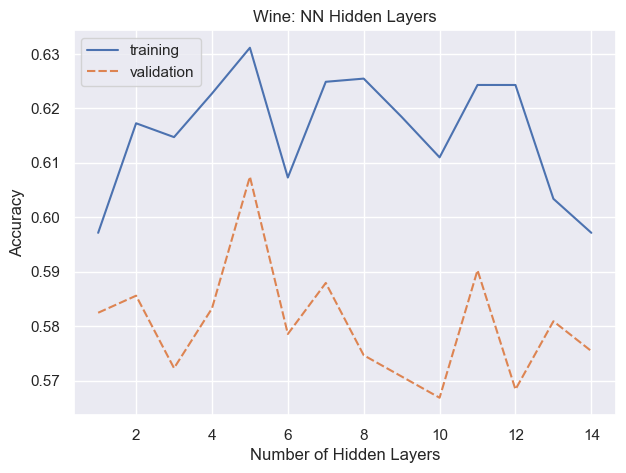

In [71]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])


plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Number of Hidden Layers', ylabel='Accuracy', title='Wine: NN Hidden Layers');
plt.savefig('wine_nn_hidden_layers.png')

In [72]:
param_range = np.arange(32, 1024, 75)

train_scores, validation_scores = validation_curve(
    KerasClassifier(build_fn=build_fn, epochs=100), 
    X_train,
    y_train,
    param_name='batch_size',
    param_range=param_range,
    cv=5,
)

Epoch 1/100


C:\Users\legen\AppData\Local\Temp\ipykernel_20456\836360356.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=build_fn, epochs=100),


32/32 [==============================] - 1s 4ms/step - loss: 1.7671 - accuracy: 0.2649
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 1.6126 - accuracy: 0.4194
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 1.4807 - accuracy: 0.4213
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 1.3816 - accuracy: 0.4213
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 1.3171 - accuracy: 0.4213
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 1.2765 - accuracy: 0.4272
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 1.2455 - accuracy: 0.4457
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 1.2187 - accuracy: 0.4692
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 1.1962 - accuracy: 0.5005
Epoch 10/100
32/32 [==============================] - 0s 4ms/step - loss: 1.1807 - accuracy: 0.5054
Epoch 11/100
32/32 [=

10/10 [==============================] - 0s 4ms/step - loss: 0.9314 - accuracy: 0.6217
Epoch 64/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9294 - accuracy: 0.6237
Epoch 65/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9276 - accuracy: 0.6246
Epoch 66/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9241 - accuracy: 0.6276
Epoch 67/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9229 - accuracy: 0.6276
Epoch 68/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9205 - accuracy: 0.6256
Epoch 69/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9194 - accuracy: 0.6276
Epoch 70/100
10/10 [==============================] - 0s 6ms/step - loss: 0.9163 - accuracy: 0.6285
Epoch 71/100
10/10 [==============================] - 0s 6ms/step - loss: 0.9151 - accuracy: 0.6276
Epoch 72/100
10/10 [==============================] - 0s 5ms/step - loss: 0.9134 - accuracy: 0.6266
Epoch 73/100


4/4 [==============================] - 0s 5ms/step - loss: 1.6076 - accuracy: 0.4340
Epoch 27/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5888 - accuracy: 0.4389
Epoch 28/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5677 - accuracy: 0.4428
Epoch 29/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5456 - accuracy: 0.4457
Epoch 30/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5195 - accuracy: 0.4555
Epoch 31/100
4/4 [==============================] - 0s 6ms/step - loss: 1.4924 - accuracy: 0.4575
Epoch 32/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4638 - accuracy: 0.4653
Epoch 33/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4345 - accuracy: 0.4721
Epoch 34/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4038 - accuracy: 0.4936
Epoch 35/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3732 - accuracy: 0.5171
Epoch 36/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.6389 - accuracy: 0.2082
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6123 - accuracy: 0.2229
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5839 - accuracy: 0.2825
Epoch 11/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5530 - accuracy: 0.3763
Epoch 12/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5189 - accuracy: 0.4526
Epoch 13/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4835 - accuracy: 0.4839
Epoch 14/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4451 - accuracy: 0.5034
Epoch 15/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4059 - accuracy: 0.5024
Epoch 16/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3696 - accuracy: 0.5181
Epoch 17/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3363 - accuracy: 0.5249
Epoch 18/100
4/4 [================

3/3 [==============================] - 0s 5ms/step - loss: 1.0799 - accuracy: 0.5758
Epoch 74/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0756 - accuracy: 0.5758
Epoch 75/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0715 - accuracy: 0.5767
Epoch 76/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0678 - accuracy: 0.5787
Epoch 77/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0642 - accuracy: 0.5806
Epoch 78/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0609 - accuracy: 0.5797
Epoch 79/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0578 - accuracy: 0.5787
Epoch 80/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0549 - accuracy: 0.5787
Epoch 81/100
3/3 [==============================] - 0s 7ms/step - loss: 1.0521 - accuracy: 0.5806
Epoch 82/100
3/3 [==============================] - 0s 8ms/step - loss: 1.0499 - accuracy: 0.5826
Epoch 83/100
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 1.1352 - accuracy: 0.5582
Epoch 56/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1312 - accuracy: 0.5601
Epoch 57/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1265 - accuracy: 0.5582
Epoch 58/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1226 - accuracy: 0.5777
Epoch 59/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1197 - accuracy: 0.5660
Epoch 60/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1165 - accuracy: 0.5679
Epoch 61/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1118 - accuracy: 0.5650
Epoch 62/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1077 - accuracy: 0.5777
Epoch 63/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1039 - accuracy: 0.5767
Epoch 64/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1004 - accuracy: 0.5797
Epoch 65/100
3/3 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.5394 - accuracy: 0.3871
Epoch 38/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5297 - accuracy: 0.3871
Epoch 39/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5198 - accuracy: 0.3871
Epoch 40/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5099 - accuracy: 0.3871
Epoch 41/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4995 - accuracy: 0.3871
Epoch 42/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4884 - accuracy: 0.3871
Epoch 43/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4763 - accuracy: 0.3871
Epoch 44/100
2/2 [==============================] - 0s 7ms/step - loss: 1.4628 - accuracy: 0.3871
Epoch 45/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4491 - accuracy: 0.3871
Epoch 46/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4356 - accuracy: 0.3871
Epoch 47/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.7124 - accuracy: 0.3851
Epoch 20/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7057 - accuracy: 0.3861
Epoch 21/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6990 - accuracy: 0.3871
Epoch 22/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6917 - accuracy: 0.3871
Epoch 23/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6848 - accuracy: 0.3871
Epoch 24/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6775 - accuracy: 0.3871
Epoch 25/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6700 - accuracy: 0.3871
Epoch 26/100
2/2 [==============================] - 0s 6ms/step - loss: 1.6631 - accuracy: 0.3871
Epoch 27/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6556 - accuracy: 0.3871
Epoch 28/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6483 - accuracy: 0.3871
Epoch 29/100
2/2 [===============

Epoch 1/100
2/2 [==============================] - 0s 8ms/step - loss: 1.7923 - accuracy: 0.3490
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7768 - accuracy: 0.3871
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7621 - accuracy: 0.3871
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 1.7479 - accuracy: 0.3871
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7346 - accuracy: 0.3871
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7215 - accuracy: 0.3871
Epoch 7/100
2/2 [==============================] - 0s 6ms/step - loss: 1.7082 - accuracy: 0.3871
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6952 - accuracy: 0.3871
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6819 - accuracy: 0.3871
Epoch 10/100
2/2 [==============================] - 0s 6ms/step - loss: 1.6685 - accuracy: 0.3871
Epoch 11/100
2/2 [===========

2/2 [==============================] - 0s 6ms/step - loss: 1.4043 - accuracy: 0.3871
Epoch 67/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3967 - accuracy: 0.3871
Epoch 68/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3895 - accuracy: 0.3871
Epoch 69/100
2/2 [==============================] - 0s 7ms/step - loss: 1.3817 - accuracy: 0.3871
Epoch 70/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3744 - accuracy: 0.3871
Epoch 71/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3670 - accuracy: 0.3871
Epoch 72/100
2/2 [==============================] - 0s 7ms/step - loss: 1.3594 - accuracy: 0.3871
Epoch 73/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3521 - accuracy: 0.3871
Epoch 74/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3447 - accuracy: 0.3871
Epoch 75/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3375 - accuracy: 0.3871
Epoch 76/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.4884 - accuracy: 0.3871
Epoch 49/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4815 - accuracy: 0.3871
Epoch 50/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4745 - accuracy: 0.3871
Epoch 51/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4676 - accuracy: 0.3871
Epoch 52/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4608 - accuracy: 0.3871
Epoch 53/100
2/2 [==============================] - 0s 8ms/step - loss: 1.4539 - accuracy: 0.3871
Epoch 54/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4470 - accuracy: 0.3871
Epoch 55/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4399 - accuracy: 0.3871
Epoch 56/100
2/2 [==============================] - 0s 6ms/step - loss: 1.4329 - accuracy: 0.3871
Epoch 57/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4260 - accuracy: 0.3871
Epoch 58/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.5911 - accuracy: 0.4418
Epoch 31/100
2/2 [==============================] - 0s 5ms/step - loss: 1.5770 - accuracy: 0.4438
Epoch 32/100
2/2 [==============================] - 0s 5ms/step - loss: 1.5629 - accuracy: 0.4467
Epoch 33/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5484 - accuracy: 0.4467
Epoch 34/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5335 - accuracy: 0.4506
Epoch 35/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5185 - accuracy: 0.4536
Epoch 36/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5030 - accuracy: 0.4673
Epoch 37/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4872 - accuracy: 0.4829
Epoch 38/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4714 - accuracy: 0.4917
Epoch 39/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4559 - accuracy: 0.4907
Epoch 40/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.7518 - accuracy: 0.3617
Epoch 13/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7451 - accuracy: 0.3803
Epoch 14/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7387 - accuracy: 0.3822
Epoch 15/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7325 - accuracy: 0.3978
Epoch 16/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7264 - accuracy: 0.4027
Epoch 17/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7204 - accuracy: 0.4106
Epoch 18/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7146 - accuracy: 0.4145
Epoch 19/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7086 - accuracy: 0.4154
Epoch 20/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7021 - accuracy: 0.4184
Epoch 21/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6956 - accuracy: 0.4154
Epoch 22/100
2/2 [===============

32/32 [==============================] - 0s 4ms/step - loss: 0.8185 - accuracy: 0.6500
Epoch 76/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8181 - accuracy: 0.6403
Epoch 77/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8168 - accuracy: 0.6422
Epoch 78/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8152 - accuracy: 0.6452
Epoch 79/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8117 - accuracy: 0.6471
Epoch 80/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8108 - accuracy: 0.6461
Epoch 81/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8099 - accuracy: 0.6520
Epoch 82/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8085 - accuracy: 0.6461
Epoch 83/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8097 - accuracy: 0.6422
Epoch 84/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8049 - accuracy: 0.6461
Epoch 85/100


6/6 [==============================] - 0s 4ms/step - loss: 1.1565 - accuracy: 0.4721
Epoch 37/100
6/6 [==============================] - 0s 4ms/step - loss: 1.1522 - accuracy: 0.4653
Epoch 38/100
6/6 [==============================] - 0s 4ms/step - loss: 1.1485 - accuracy: 0.4692
Epoch 39/100
6/6 [==============================] - 0s 4ms/step - loss: 1.1447 - accuracy: 0.4682
Epoch 40/100
6/6 [==============================] - 0s 4ms/step - loss: 1.1406 - accuracy: 0.4751
Epoch 41/100
6/6 [==============================] - 0s 4ms/step - loss: 1.1365 - accuracy: 0.4790
Epoch 42/100
6/6 [==============================] - 0s 4ms/step - loss: 1.1323 - accuracy: 0.4761
Epoch 43/100
6/6 [==============================] - 0s 4ms/step - loss: 1.1274 - accuracy: 0.4761
Epoch 44/100
6/6 [==============================] - 0s 4ms/step - loss: 1.1230 - accuracy: 0.4790
Epoch 45/100
6/6 [==============================] - 0s 4ms/step - loss: 1.1190 - accuracy: 0.4848
Epoch 46/100
6/6 [===============

4/4 [==============================] - 0s 2ms/step - loss: 0.9264 - accuracy: 0.6119
Epoch 1/100
4/4 [==============================] - 0s 8ms/step - loss: 1.7839 - accuracy: 0.2923
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 1.7639 - accuracy: 0.3822
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 1.7455 - accuracy: 0.3949
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7274 - accuracy: 0.4282
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7084 - accuracy: 0.4526
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6896 - accuracy: 0.4702
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6704 - accuracy: 0.4633
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 1.6499 - accuracy: 0.4624
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 1.6284 - accuracy: 0.4751
Epoch 10/100
4/4 [========================

4/4 [==============================] - 4s 933ms/step - loss: 0.9582 - accuracy: 0.6012
Epoch 83/100
4/4 [==============================] - 3s 908ms/step - loss: 0.9561 - accuracy: 0.5973
Epoch 84/100
4/4 [==============================] - 0s 9ms/step - loss: 0.9547 - accuracy: 0.6012
Epoch 85/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9528 - accuracy: 0.6002
Epoch 86/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9518 - accuracy: 0.6012
Epoch 87/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9543 - accuracy: 0.6061
Epoch 88/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9526 - accuracy: 0.6051
Epoch 89/100
4/4 [==============================] - 0s 7ms/step - loss: 0.9479 - accuracy: 0.6080
Epoch 90/100
4/4 [==============================] - 0s 8ms/step - loss: 0.9460 - accuracy: 0.6041
Epoch 91/100
4/4 [==============================] - 0s 10ms/step - loss: 0.9457 - accuracy: 0.6022
Epoch 92/100
4/4 [=========

Epoch 64/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0597 - accuracy: 0.5249
Epoch 65/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0558 - accuracy: 0.5279
Epoch 66/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0528 - accuracy: 0.5279
Epoch 67/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0491 - accuracy: 0.5269
Epoch 68/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0453 - accuracy: 0.5269
Epoch 69/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0417 - accuracy: 0.5279
Epoch 70/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0383 - accuracy: 0.5259
Epoch 71/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0350 - accuracy: 0.5279
Epoch 72/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0315 - accuracy: 0.5308
Epoch 73/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0282 - accuracy: 0.5308
Epoch 74/100
3/3 [==

2/2 [==============================] - 0s 4ms/step - loss: 1.3123 - accuracy: 0.5591
Epoch 28/100
2/2 [==============================] - 0s 3ms/step - loss: 1.2925 - accuracy: 0.5611
Epoch 29/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2739 - accuracy: 0.5611
Epoch 30/100
2/2 [==============================] - 0s 3ms/step - loss: 1.2558 - accuracy: 0.5591
Epoch 31/100
2/2 [==============================] - 0s 3ms/step - loss: 1.2397 - accuracy: 0.5601
Epoch 32/100
2/2 [==============================] - 0s 3ms/step - loss: 1.2236 - accuracy: 0.5650
Epoch 33/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2092 - accuracy: 0.5679
Epoch 34/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1951 - accuracy: 0.5650
Epoch 35/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1825 - accuracy: 0.5591
Epoch 36/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1709 - accuracy: 0.5582
Epoch 37/100
2/2 [===============

2/2 [==============================] - 0s 3ms/step - loss: 1.7386 - accuracy: 0.1085
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 1.7301 - accuracy: 0.1339
Epoch 11/100
2/2 [==============================] - 0s 3ms/step - loss: 1.7213 - accuracy: 0.1584
Epoch 12/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7125 - accuracy: 0.1769
Epoch 13/100
2/2 [==============================] - 0s 3ms/step - loss: 1.7037 - accuracy: 0.2063
Epoch 14/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6944 - accuracy: 0.2278
Epoch 15/100
2/2 [==============================] - 0s 3ms/step - loss: 1.6850 - accuracy: 0.2473
Epoch 16/100
2/2 [==============================] - 0s 3ms/step - loss: 1.6752 - accuracy: 0.2620
Epoch 17/100
2/2 [==============================] - 0s 3ms/step - loss: 1.6649 - accuracy: 0.2825
Epoch 18/100
2/2 [==============================] - 0s 3ms/step - loss: 1.6542 - accuracy: 0.2981
Epoch 19/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.1609 - accuracy: 0.4350
Epoch 75/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1586 - accuracy: 0.4350
Epoch 76/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1564 - accuracy: 0.4350
Epoch 77/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1542 - accuracy: 0.4350
Epoch 78/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1520 - accuracy: 0.4350
Epoch 79/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1497 - accuracy: 0.4350
Epoch 80/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1475 - accuracy: 0.4350
Epoch 81/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1454 - accuracy: 0.4350
Epoch 82/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1433 - accuracy: 0.4350
Epoch 83/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1411 - accuracy: 0.4350
Epoch 84/100
2/2 [===============

2/2 [==============================] - 0s 3ms/step - loss: 1.1437 - accuracy: 0.5347
Epoch 57/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1353 - accuracy: 0.5415
Epoch 58/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1272 - accuracy: 0.5406
Epoch 59/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1193 - accuracy: 0.5435
Epoch 60/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1115 - accuracy: 0.5474
Epoch 61/100
2/2 [==============================] - 0s 3ms/step - loss: 1.1044 - accuracy: 0.5464
Epoch 62/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0972 - accuracy: 0.5494
Epoch 63/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0905 - accuracy: 0.5503
Epoch 64/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0844 - accuracy: 0.5523
Epoch 65/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0783 - accuracy: 0.5523
Epoch 66/100
2/2 [===============

2/2 [==============================] - 0s 3ms/step - loss: 1.4487 - accuracy: 0.3930
Epoch 39/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4328 - accuracy: 0.3930
Epoch 40/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4165 - accuracy: 0.3930
Epoch 41/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4006 - accuracy: 0.3930
Epoch 42/100
2/2 [==============================] - 0s 3ms/step - loss: 1.3843 - accuracy: 0.3930
Epoch 43/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3685 - accuracy: 0.3930
Epoch 44/100
2/2 [==============================] - 0s 3ms/step - loss: 1.3528 - accuracy: 0.3930
Epoch 45/100
2/2 [==============================] - 0s 3ms/step - loss: 1.3376 - accuracy: 0.3930
Epoch 46/100
2/2 [==============================] - 0s 3ms/step - loss: 1.3228 - accuracy: 0.3930
Epoch 47/100
2/2 [==============================] - 0s 3ms/step - loss: 1.3083 - accuracy: 0.3930
Epoch 48/100
2/2 [===============

2/2 [==============================] - 0s 3ms/step - loss: 1.5420 - accuracy: 0.3930
Epoch 21/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5277 - accuracy: 0.3930
Epoch 22/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5134 - accuracy: 0.3930
Epoch 23/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4988 - accuracy: 0.3930
Epoch 24/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4845 - accuracy: 0.3930
Epoch 25/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4701 - accuracy: 0.3930
Epoch 26/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4557 - accuracy: 0.3930
Epoch 27/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4420 - accuracy: 0.3930
Epoch 28/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4285 - accuracy: 0.3930
Epoch 29/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4158 - accuracy: 0.3930
Epoch 30/100
2/2 [===============

Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 1.8201 - accuracy: 0.1036
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 1.8116 - accuracy: 0.1505
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 1.8041 - accuracy: 0.2004
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 1.7972 - accuracy: 0.2356
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7911 - accuracy: 0.2717
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7855 - accuracy: 0.3138
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 1.7802 - accuracy: 0.3304
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7752 - accuracy: 0.3460
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 1.7702 - accuracy: 0.3607
Epoch 11/100
2/2 [==============================] - 0s 3ms/step - loss: 1.7653 - accuracy: 0.3763
Epoch 12/100
2/2 [==========

32/32 [==============================] - 0s 3ms/step - loss: 0.8103 - accuracy: 0.6510
Epoch 66/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8053 - accuracy: 0.6559
Epoch 67/100
32/32 [==============================] - 2s 59ms/step - loss: 0.8104 - accuracy: 0.6569
Epoch 68/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8041 - accuracy: 0.6588
Epoch 69/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7997 - accuracy: 0.6618
Epoch 70/100
32/32 [==============================] - 0s 3ms/step - loss: 0.8000 - accuracy: 0.6647
Epoch 71/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7949 - accuracy: 0.6725
Epoch 72/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7935 - accuracy: 0.6686
Epoch 73/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7971 - accuracy: 0.6637
Epoch 74/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7964 - accuracy: 0.6706
Epoch 75/100

6/6 [==============================] - 0s 3ms/step - loss: 1.1279 - accuracy: 0.5670
Epoch 26/100
6/6 [==============================] - 0s 3ms/step - loss: 1.1153 - accuracy: 0.5787
Epoch 27/100
6/6 [==============================] - 0s 3ms/step - loss: 1.1028 - accuracy: 0.5816
Epoch 28/100
6/6 [==============================] - 0s 3ms/step - loss: 1.0919 - accuracy: 0.5816
Epoch 29/100
6/6 [==============================] - 0s 3ms/step - loss: 1.0812 - accuracy: 0.5885
Epoch 30/100
6/6 [==============================] - 0s 3ms/step - loss: 1.0711 - accuracy: 0.5855
Epoch 31/100
6/6 [==============================] - 0s 3ms/step - loss: 1.0622 - accuracy: 0.5924
Epoch 32/100
6/6 [==============================] - 0s 3ms/step - loss: 1.0527 - accuracy: 0.5934
Epoch 33/100
6/6 [==============================] - 0s 3ms/step - loss: 1.0435 - accuracy: 0.5963
Epoch 34/100
6/6 [==============================] - 0s 3ms/step - loss: 1.0351 - accuracy: 0.5943
Epoch 35/100
6/6 [===============

4/4 [==============================] - 0s 3ms/step - loss: 1.5694 - accuracy: 0.4418
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5408 - accuracy: 0.4370
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5122 - accuracy: 0.4340
Epoch 10/100
4/4 [==============================] - 0s 3ms/step - loss: 1.4830 - accuracy: 0.4340
Epoch 11/100
4/4 [==============================] - 0s 3ms/step - loss: 1.4539 - accuracy: 0.4340
Epoch 12/100
4/4 [==============================] - 0s 3ms/step - loss: 1.4255 - accuracy: 0.4340
Epoch 13/100
4/4 [==============================] - 0s 3ms/step - loss: 1.3963 - accuracy: 0.4340
Epoch 14/100
4/4 [==============================] - 0s 3ms/step - loss: 1.3682 - accuracy: 0.4340
Epoch 15/100
4/4 [==============================] - 0s 3ms/step - loss: 1.3397 - accuracy: 0.4340
Epoch 16/100
4/4 [==============================] - 0s 3ms/step - loss: 1.3127 - accuracy: 0.4340
Epoch 17/100
4/4 [=================

4/4 [==============================] - 0s 4ms/step - loss: 0.9564 - accuracy: 0.6237
Epoch 73/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9542 - accuracy: 0.6188
Epoch 74/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9541 - accuracy: 0.6139
Epoch 75/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9524 - accuracy: 0.6188
Epoch 76/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9495 - accuracy: 0.6256
Epoch 77/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9472 - accuracy: 0.6237
Epoch 78/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9476 - accuracy: 0.6168
Epoch 79/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9476 - accuracy: 0.6149
Epoch 80/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9446 - accuracy: 0.6188
Epoch 81/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9415 - accuracy: 0.6217
Epoch 82/100
4/4 [===============

3/3 [==============================] - 0s 4ms/step - loss: 0.9900 - accuracy: 0.6207
Epoch 55/100
3/3 [==============================] - 0s 4ms/step - loss: 0.9874 - accuracy: 0.6227
Epoch 56/100
3/3 [==============================] - 0s 4ms/step - loss: 0.9850 - accuracy: 0.6285
Epoch 57/100
3/3 [==============================] - 0s 4ms/step - loss: 0.9827 - accuracy: 0.6305
Epoch 58/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9804 - accuracy: 0.6285
Epoch 59/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9783 - accuracy: 0.6285
Epoch 60/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9764 - accuracy: 0.6256
Epoch 61/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9741 - accuracy: 0.6227
Epoch 62/100
3/3 [==============================] - 0s 4ms/step - loss: 0.9720 - accuracy: 0.6246
Epoch 63/100
3/3 [==============================] - 0s 4ms/step - loss: 0.9701 - accuracy: 0.6285
Epoch 64/100
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 1.2853 - accuracy: 0.4761
Epoch 37/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2684 - accuracy: 0.4878
Epoch 38/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2520 - accuracy: 0.4917
Epoch 39/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2370 - accuracy: 0.5103
Epoch 40/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2221 - accuracy: 0.5161
Epoch 41/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2083 - accuracy: 0.5269
Epoch 42/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1948 - accuracy: 0.5308
Epoch 43/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1825 - accuracy: 0.5406
Epoch 44/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1706 - accuracy: 0.5503
Epoch 45/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1588 - accuracy: 0.5503
Epoch 46/100
3/3 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.6751 - accuracy: 0.1505
Epoch 19/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6671 - accuracy: 0.1505
Epoch 20/100
2/2 [==============================] - 0s 7ms/step - loss: 1.6592 - accuracy: 0.1505
Epoch 21/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6509 - accuracy: 0.1505
Epoch 22/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6426 - accuracy: 0.1515
Epoch 23/100
2/2 [==============================] - 0s 7ms/step - loss: 1.6342 - accuracy: 0.1515
Epoch 24/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6258 - accuracy: 0.1515
Epoch 25/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6173 - accuracy: 0.1515
Epoch 26/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6086 - accuracy: 0.1496
Epoch 27/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5999 - accuracy: 0.1496
Epoch 28/100
2/2 [===============

2/2 [==============================] - 0s 6ms/step - loss: 1.1185 - accuracy: 0.5191
Epoch 83/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1142 - accuracy: 0.5288
Epoch 84/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1100 - accuracy: 0.5337
Epoch 85/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1057 - accuracy: 0.5406
Epoch 86/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1017 - accuracy: 0.5494
Epoch 87/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0973 - accuracy: 0.5543
Epoch 88/100
2/2 [==============================] - 0s 7ms/step - loss: 1.0932 - accuracy: 0.5572
Epoch 89/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0888 - accuracy: 0.5562
Epoch 90/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0845 - accuracy: 0.5543
Epoch 91/100
2/2 [==============================] - 0s 7ms/step - loss: 1.0803 - accuracy: 0.5523
Epoch 92/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.1874 - accuracy: 0.4956
Epoch 65/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1766 - accuracy: 0.5015
Epoch 66/100
2/2 [==============================] - 0s 10ms/step - loss: 1.1657 - accuracy: 0.5122
Epoch 67/100
2/2 [==============================] - 0s 9ms/step - loss: 1.1555 - accuracy: 0.5259
Epoch 68/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1463 - accuracy: 0.5327
Epoch 69/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1368 - accuracy: 0.5337
Epoch 70/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1278 - accuracy: 0.5347
Epoch 71/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1186 - accuracy: 0.5357
Epoch 72/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1094 - accuracy: 0.5435
Epoch 73/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1007 - accuracy: 0.5513
Epoch 74/100
2/2 [==============

2/2 [==============================] - 0s 4ms/step - loss: 1.6267 - accuracy: 0.4370
Epoch 47/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6184 - accuracy: 0.4379
Epoch 48/100
2/2 [==============================] - 0s 6ms/step - loss: 1.6096 - accuracy: 0.4370
Epoch 49/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6001 - accuracy: 0.4379
Epoch 50/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5901 - accuracy: 0.4389
Epoch 51/100
2/2 [==============================] - 0s 5ms/step - loss: 1.5796 - accuracy: 0.4379
Epoch 52/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5680 - accuracy: 0.4379
Epoch 53/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5564 - accuracy: 0.4350
Epoch 54/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5445 - accuracy: 0.4340
Epoch 55/100
2/2 [==============================] - 0s 7ms/step - loss: 1.5317 - accuracy: 0.4340
Epoch 56/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.6714 - accuracy: 0.4340
Epoch 29/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6622 - accuracy: 0.4340
Epoch 30/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6525 - accuracy: 0.4340
Epoch 31/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6424 - accuracy: 0.4340
Epoch 32/100
2/2 [==============================] - 0s 7ms/step - loss: 1.6320 - accuracy: 0.4340
Epoch 33/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6212 - accuracy: 0.4340
Epoch 34/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6103 - accuracy: 0.4340
Epoch 35/100
2/2 [==============================] - 0s 5ms/step - loss: 1.5988 - accuracy: 0.4340
Epoch 36/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5871 - accuracy: 0.4340
Epoch 37/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5755 - accuracy: 0.4340
Epoch 38/100
2/2 [===============

2/2 [==============================] - 0s 6ms/step - loss: 1.7452 - accuracy: 0.2805
Epoch 11/100
2/2 [==============================] - 0s 6ms/step - loss: 1.7386 - accuracy: 0.3060
Epoch 12/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7320 - accuracy: 0.3128
Epoch 13/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7252 - accuracy: 0.3275
Epoch 14/100
2/2 [==============================] - 0s 7ms/step - loss: 1.7183 - accuracy: 0.3451
Epoch 15/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7113 - accuracy: 0.3607
Epoch 16/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7041 - accuracy: 0.3783
Epoch 17/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6965 - accuracy: 0.3871
Epoch 18/100
2/2 [==============================] - 0s 7ms/step - loss: 1.6889 - accuracy: 0.3910
Epoch 19/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6812 - accuracy: 0.3959
Epoch 20/100
2/2 [===============

2/2 [==============================] - 0s 6ms/step - loss: 1.1221 - accuracy: 0.5699
Epoch 76/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1139 - accuracy: 0.5660
Epoch 77/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1053 - accuracy: 0.5670
Epoch 78/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0963 - accuracy: 0.5660
Epoch 79/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0873 - accuracy: 0.5650
Epoch 80/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0794 - accuracy: 0.5689
Epoch 81/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0727 - accuracy: 0.5767
Epoch 82/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0655 - accuracy: 0.5787
Epoch 83/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0584 - accuracy: 0.5797
Epoch 84/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0525 - accuracy: 0.5767
Epoch 85/100
2/2 [===============

10/10 [==============================] - 0s 4ms/step - loss: 1.0049 - accuracy: 0.5787
Epoch 36/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9983 - accuracy: 0.5885
Epoch 37/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9901 - accuracy: 0.5836
Epoch 38/100
10/10 [==============================] - 0s 5ms/step - loss: 0.9841 - accuracy: 0.5816
Epoch 39/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9782 - accuracy: 0.5904
Epoch 40/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9728 - accuracy: 0.5924
Epoch 41/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9683 - accuracy: 0.5924
Epoch 42/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9628 - accuracy: 0.5816
Epoch 43/100
10/10 [==============================] - 0s 5ms/step - loss: 0.9585 - accuracy: 0.5943
Epoch 44/100
10/10 [==============================] - 0s 4ms/step - loss: 0.9541 - accuracy: 0.5992
Epoch 45/100


6/6 [==============================] - 0s 4ms/step - loss: 0.8997 - accuracy: 0.6217
Epoch 99/100
6/6 [==============================] - 0s 4ms/step - loss: 0.8969 - accuracy: 0.6237
Epoch 100/100
6/6 [==============================] - 0s 3ms/step - loss: 0.8940 - accuracy: 0.6325
Epoch 1/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7696 - accuracy: 0.3304
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7580 - accuracy: 0.4008
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7459 - accuracy: 0.4027
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7330 - accuracy: 0.4037
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7190 - accuracy: 0.4076
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7043 - accuracy: 0.4106
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6883 - accuracy: 0.4047
Epoch 8/100
4/4 [======================

4/4 [==============================] - 0s 4ms/step - loss: 0.9877 - accuracy: 0.5748
Epoch 81/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9855 - accuracy: 0.5758
Epoch 82/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9834 - accuracy: 0.5738
Epoch 83/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9812 - accuracy: 0.5728
Epoch 84/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9791 - accuracy: 0.5758
Epoch 85/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9771 - accuracy: 0.5767
Epoch 86/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9748 - accuracy: 0.5875
Epoch 87/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9729 - accuracy: 0.5885
Epoch 88/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9714 - accuracy: 0.5836
Epoch 89/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9694 - accuracy: 0.5885
Epoch 90/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.0241 - accuracy: 0.5543
Epoch 63/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0221 - accuracy: 0.5503
Epoch 64/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0218 - accuracy: 0.5513
Epoch 65/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0200 - accuracy: 0.5484
Epoch 66/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0179 - accuracy: 0.5513
Epoch 67/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0156 - accuracy: 0.5543
Epoch 68/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0140 - accuracy: 0.5582
Epoch 69/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0119 - accuracy: 0.5591
Epoch 70/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0097 - accuracy: 0.5611
Epoch 71/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0073 - accuracy: 0.5640
Epoch 72/100
4/4 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.1812 - accuracy: 0.4819
Epoch 45/100
3/3 [==============================] - 0s 7ms/step - loss: 1.1766 - accuracy: 0.4927
Epoch 46/100
3/3 [==============================] - 0s 6ms/step - loss: 1.1723 - accuracy: 0.4995
Epoch 47/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1679 - accuracy: 0.5005
Epoch 48/100
3/3 [==============================] - 0s 6ms/step - loss: 1.1634 - accuracy: 0.5015
Epoch 49/100
3/3 [==============================] - 0s 6ms/step - loss: 1.1584 - accuracy: 0.5024
Epoch 50/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1534 - accuracy: 0.5132
Epoch 51/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1484 - accuracy: 0.5122
Epoch 52/100
3/3 [==============================] - 0s 6ms/step - loss: 1.1436 - accuracy: 0.5122
Epoch 53/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1382 - accuracy: 0.5103
Epoch 54/100
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.3345 - accuracy: 0.4633
Epoch 27/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3234 - accuracy: 0.4633
Epoch 28/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3127 - accuracy: 0.4545
Epoch 29/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3024 - accuracy: 0.4545
Epoch 30/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2924 - accuracy: 0.4516
Epoch 31/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2832 - accuracy: 0.4594
Epoch 32/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2739 - accuracy: 0.4624
Epoch 33/100
3/3 [==============================] - 0s 7ms/step - loss: 1.2658 - accuracy: 0.4624
Epoch 34/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2581 - accuracy: 0.4663
Epoch 35/100
3/3 [==============================] - 0s 6ms/step - loss: 1.2509 - accuracy: 0.4731
Epoch 36/100
3/3 [===============

2/2 [==============================] - 0s 7ms/step - loss: 1.7218 - accuracy: 0.4018
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7132 - accuracy: 0.4057
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7041 - accuracy: 0.4125
Epoch 11/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6940 - accuracy: 0.4145
Epoch 12/100
2/2 [==============================] - 0s 6ms/step - loss: 1.6833 - accuracy: 0.4125
Epoch 13/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6713 - accuracy: 0.4213
Epoch 14/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6582 - accuracy: 0.4115
Epoch 15/100
2/2 [==============================] - 0s 8ms/step - loss: 1.6446 - accuracy: 0.4203
Epoch 16/100
2/2 [==============================] - 0s 8ms/step - loss: 1.6298 - accuracy: 0.4066
Epoch 17/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6150 - accuracy: 0.4057
Epoch 18/100
2/2 [================

2/2 [==============================] - 0s 5ms/step - loss: 1.1881 - accuracy: 0.4194
Epoch 74/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1830 - accuracy: 0.4194
Epoch 75/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1784 - accuracy: 0.4194
Epoch 76/100
2/2 [==============================] - 0s 8ms/step - loss: 1.1737 - accuracy: 0.4194
Epoch 77/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1692 - accuracy: 0.4194
Epoch 78/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1648 - accuracy: 0.4194
Epoch 79/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1607 - accuracy: 0.4194
Epoch 80/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1561 - accuracy: 0.4194
Epoch 81/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1518 - accuracy: 0.4194
Epoch 82/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1478 - accuracy: 0.4194
Epoch 83/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.2214 - accuracy: 0.5464
Epoch 56/100
2/2 [==============================] - 0s 6ms/step - loss: 1.2145 - accuracy: 0.5445
Epoch 57/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2076 - accuracy: 0.5455
Epoch 58/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2012 - accuracy: 0.5494
Epoch 59/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1952 - accuracy: 0.5494
Epoch 60/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1895 - accuracy: 0.5523
Epoch 61/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1839 - accuracy: 0.5582
Epoch 62/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1788 - accuracy: 0.5562
Epoch 63/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1738 - accuracy: 0.5572
Epoch 64/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1691 - accuracy: 0.5591
Epoch 65/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.4026 - accuracy: 0.3910
Epoch 38/100
2/2 [==============================] - 0s 6ms/step - loss: 1.3920 - accuracy: 0.4037
Epoch 39/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3815 - accuracy: 0.4203
Epoch 40/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3712 - accuracy: 0.4330
Epoch 41/100
2/2 [==============================] - 0s 6ms/step - loss: 1.3612 - accuracy: 0.4653
Epoch 42/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3513 - accuracy: 0.4907
Epoch 43/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3417 - accuracy: 0.5024
Epoch 44/100
2/2 [==============================] - 0s 6ms/step - loss: 1.3321 - accuracy: 0.5122
Epoch 45/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3228 - accuracy: 0.5230
Epoch 46/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3141 - accuracy: 0.5269
Epoch 47/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.5932 - accuracy: 0.3617
Epoch 20/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5782 - accuracy: 0.3666
Epoch 21/100
2/2 [==============================] - 0s 7ms/step - loss: 1.5631 - accuracy: 0.3734
Epoch 22/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5484 - accuracy: 0.3773
Epoch 23/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5333 - accuracy: 0.3783
Epoch 24/100
2/2 [==============================] - 0s 9ms/step - loss: 1.5185 - accuracy: 0.3724
Epoch 25/100
2/2 [==============================] - 0s 8ms/step - loss: 1.5040 - accuracy: 0.3783
Epoch 26/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4895 - accuracy: 0.3861
Epoch 27/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4756 - accuracy: 0.3900
Epoch 28/100
2/2 [==============================] - 0s 7ms/step - loss: 1.4622 - accuracy: 0.3949
Epoch 29/100
2/2 [===============

Epoch 1/100
2/2 [==============================] - 0s 5ms/step - loss: 1.8459 - accuracy: 0.0362
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 1.8354 - accuracy: 0.0362
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 1.8259 - accuracy: 0.0371
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 1.8173 - accuracy: 0.0440
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 1.8097 - accuracy: 0.0606
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 1.8028 - accuracy: 0.0841
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7966 - accuracy: 0.1114
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7911 - accuracy: 0.1505
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 1.7861 - accuracy: 0.1887
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7816 - accuracy: 0.2346
Epoch 11/100
2/2 [===========

2/2 [==============================] - 0s 4ms/step - loss: 1.2645 - accuracy: 0.5269
Epoch 67/100
2/2 [==============================] - 0s 6ms/step - loss: 1.2608 - accuracy: 0.5318
Epoch 68/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2572 - accuracy: 0.5318
Epoch 69/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2537 - accuracy: 0.5337
Epoch 70/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2504 - accuracy: 0.5347
Epoch 71/100
2/2 [==============================] - 0s 7ms/step - loss: 1.2471 - accuracy: 0.5357
Epoch 72/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2441 - accuracy: 0.5347
Epoch 73/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2413 - accuracy: 0.5337
Epoch 74/100
2/2 [==============================] - 0s 7ms/step - loss: 1.2386 - accuracy: 0.5337
Epoch 75/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2358 - accuracy: 0.5337
Epoch 76/100
2/2 [===============

32/32 [==============================] - 0s 4ms/step - loss: 0.8715 - accuracy: 0.6299
Epoch 48/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8752 - accuracy: 0.6328
Epoch 49/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8684 - accuracy: 0.6309
Epoch 50/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8684 - accuracy: 0.6309
Epoch 51/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8673 - accuracy: 0.6338
Epoch 52/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8674 - accuracy: 0.6338
Epoch 53/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8670 - accuracy: 0.6279
Epoch 54/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8623 - accuracy: 0.6328
Epoch 55/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8635 - accuracy: 0.6357
Epoch 56/100
32/32 [==============================] - 0s 4ms/step - loss: 0.8651 - accuracy: 0.6348
Epoch 57/100


6/6 [==============================] - 0s 4ms/step - loss: 1.6903 - accuracy: 0.3857
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 1.6666 - accuracy: 0.4023
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 1.6393 - accuracy: 0.4189
Epoch 10/100
6/6 [==============================] - 0s 4ms/step - loss: 1.6078 - accuracy: 0.4209
Epoch 11/100
6/6 [==============================] - 0s 4ms/step - loss: 1.5727 - accuracy: 0.4238
Epoch 12/100
6/6 [==============================] - 0s 4ms/step - loss: 1.5332 - accuracy: 0.4238
Epoch 13/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4899 - accuracy: 0.4238
Epoch 14/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4433 - accuracy: 0.4258
Epoch 15/100
6/6 [==============================] - 0s 5ms/step - loss: 1.3950 - accuracy: 0.4258
Epoch 16/100
6/6 [==============================] - 0s 4ms/step - loss: 1.3466 - accuracy: 0.4258
Epoch 17/100
6/6 [=================

4/4 [==============================] - 0s 4ms/step - loss: 0.9393 - accuracy: 0.6084
Epoch 73/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9374 - accuracy: 0.6074
Epoch 74/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9362 - accuracy: 0.6084
Epoch 75/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9349 - accuracy: 0.6143
Epoch 76/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9334 - accuracy: 0.6172
Epoch 77/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9319 - accuracy: 0.6143
Epoch 78/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9313 - accuracy: 0.6152
Epoch 79/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9293 - accuracy: 0.6162
Epoch 80/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9284 - accuracy: 0.6162
Epoch 81/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9264 - accuracy: 0.6182
Epoch 82/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.0920 - accuracy: 0.5684
Epoch 55/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0810 - accuracy: 0.5703
Epoch 56/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0707 - accuracy: 0.5732
Epoch 57/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0620 - accuracy: 0.5723
Epoch 58/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0534 - accuracy: 0.5752
Epoch 59/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0444 - accuracy: 0.5830
Epoch 60/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0379 - accuracy: 0.5859
Epoch 61/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0316 - accuracy: 0.5850
Epoch 62/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0258 - accuracy: 0.5840
Epoch 63/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0209 - accuracy: 0.5840
Epoch 64/100
4/4 [===============

3/3 [==============================] - 0s 4ms/step - loss: 1.5794 - accuracy: 0.5762
Epoch 37/100
3/3 [==============================] - 0s 5ms/step - loss: 1.5653 - accuracy: 0.5732
Epoch 38/100
3/3 [==============================] - 0s 6ms/step - loss: 1.5501 - accuracy: 0.5713
Epoch 39/100
3/3 [==============================] - 0s 6ms/step - loss: 1.5338 - accuracy: 0.5703
Epoch 40/100
3/3 [==============================] - 0s 5ms/step - loss: 1.5162 - accuracy: 0.5723
Epoch 41/100
3/3 [==============================] - 0s 5ms/step - loss: 1.4973 - accuracy: 0.5723
Epoch 42/100
3/3 [==============================] - 0s 5ms/step - loss: 1.4768 - accuracy: 0.5732
Epoch 43/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4553 - accuracy: 0.5801
Epoch 44/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4330 - accuracy: 0.5830
Epoch 45/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4085 - accuracy: 0.5811
Epoch 46/100
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.5841 - accuracy: 0.4482
Epoch 19/100
3/3 [==============================] - 0s 4ms/step - loss: 1.5618 - accuracy: 0.4551
Epoch 20/100
3/3 [==============================] - 0s 4ms/step - loss: 1.5378 - accuracy: 0.4502
Epoch 21/100
3/3 [==============================] - 0s 4ms/step - loss: 1.5128 - accuracy: 0.4473
Epoch 22/100
3/3 [==============================] - 0s 5ms/step - loss: 1.4871 - accuracy: 0.4463
Epoch 23/100
3/3 [==============================] - 0s 5ms/step - loss: 1.4605 - accuracy: 0.4482
Epoch 24/100
3/3 [==============================] - 0s 5ms/step - loss: 1.4339 - accuracy: 0.4492
Epoch 25/100
3/3 [==============================] - 0s 5ms/step - loss: 1.4089 - accuracy: 0.4482
Epoch 26/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3847 - accuracy: 0.4473
Epoch 27/100
3/3 [==============================] - 0s 5ms/step - loss: 1.3626 - accuracy: 0.4492
Epoch 28/100
3/3 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.0542 - accuracy: 0.5557
Epoch 83/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0500 - accuracy: 0.5615
Epoch 84/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0465 - accuracy: 0.5645
Epoch 85/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0427 - accuracy: 0.5625
Epoch 86/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0391 - accuracy: 0.5625
Epoch 87/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0357 - accuracy: 0.5635
Epoch 88/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0324 - accuracy: 0.5635
Epoch 89/100
2/2 [==============================] - 0s 7ms/step - loss: 1.0291 - accuracy: 0.5645
Epoch 90/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0258 - accuracy: 0.5674
Epoch 91/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0226 - accuracy: 0.5713
Epoch 92/100
2/2 [===============

2/2 [==============================] - 0s 6ms/step - loss: 1.1379 - accuracy: 0.4863
Epoch 65/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1362 - accuracy: 0.4951
Epoch 66/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1345 - accuracy: 0.5059
Epoch 67/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1329 - accuracy: 0.5107
Epoch 68/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1311 - accuracy: 0.5254
Epoch 69/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1296 - accuracy: 0.5332
Epoch 70/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1278 - accuracy: 0.5420
Epoch 71/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1262 - accuracy: 0.5459
Epoch 72/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1246 - accuracy: 0.5479
Epoch 73/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1229 - accuracy: 0.5469
Epoch 74/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.3459 - accuracy: 0.4248
Epoch 47/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3338 - accuracy: 0.4248
Epoch 48/100
2/2 [==============================] - 0s 6ms/step - loss: 1.3221 - accuracy: 0.4248
Epoch 49/100
2/2 [==============================] - 0s 6ms/step - loss: 1.3109 - accuracy: 0.4248
Epoch 50/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3000 - accuracy: 0.4248
Epoch 51/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2891 - accuracy: 0.4248
Epoch 52/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2791 - accuracy: 0.4248
Epoch 53/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2695 - accuracy: 0.4248
Epoch 54/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2607 - accuracy: 0.4248
Epoch 55/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2525 - accuracy: 0.4248
Epoch 56/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.4222 - accuracy: 0.3994
Epoch 29/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4028 - accuracy: 0.3994
Epoch 30/100
2/2 [==============================] - 0s 6ms/step - loss: 1.3839 - accuracy: 0.3916
Epoch 31/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3642 - accuracy: 0.3867
Epoch 32/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3450 - accuracy: 0.3789
Epoch 33/100
2/2 [==============================] - 0s 6ms/step - loss: 1.3262 - accuracy: 0.4023
Epoch 34/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3083 - accuracy: 0.4238
Epoch 35/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2907 - accuracy: 0.4336
Epoch 36/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2749 - accuracy: 0.4463
Epoch 37/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2603 - accuracy: 0.4561
Epoch 38/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.6374 - accuracy: 0.4004
Epoch 11/100
2/2 [==============================] - 0s 6ms/step - loss: 1.6277 - accuracy: 0.4004
Epoch 12/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6182 - accuracy: 0.4004
Epoch 13/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6090 - accuracy: 0.4004
Epoch 14/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5995 - accuracy: 0.4004
Epoch 15/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5903 - accuracy: 0.4004
Epoch 16/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5812 - accuracy: 0.4004
Epoch 17/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5722 - accuracy: 0.4004
Epoch 18/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5631 - accuracy: 0.4004
Epoch 19/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5543 - accuracy: 0.4004
Epoch 20/100
2/2 [===============

2/2 [==============================] - 0s 6ms/step - loss: 1.2020 - accuracy: 0.4854
Epoch 76/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2000 - accuracy: 0.4834
Epoch 77/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1978 - accuracy: 0.4902
Epoch 78/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1956 - accuracy: 0.4922
Epoch 79/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1934 - accuracy: 0.4941
Epoch 80/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1914 - accuracy: 0.4932
Epoch 81/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1892 - accuracy: 0.4902
Epoch 82/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1870 - accuracy: 0.4893
Epoch 83/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1850 - accuracy: 0.4883
Epoch 84/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1830 - accuracy: 0.4834
Epoch 85/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.2443 - accuracy: 0.4248
Epoch 58/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2406 - accuracy: 0.4248
Epoch 59/100
2/2 [==============================] - 0s 7ms/step - loss: 1.2367 - accuracy: 0.4248
Epoch 60/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2328 - accuracy: 0.4248
Epoch 61/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2287 - accuracy: 0.4248
Epoch 62/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2249 - accuracy: 0.4248
Epoch 63/100
2/2 [==============================] - 0s 7ms/step - loss: 1.2213 - accuracy: 0.4248
Epoch 64/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2179 - accuracy: 0.4248
Epoch 65/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2146 - accuracy: 0.4248
Epoch 66/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2111 - accuracy: 0.4248
Epoch 67/100
2/2 [===============

Best Param: 107
Scores:
 training      0.641711
validation    0.602806
Name: 107, dtype: float64


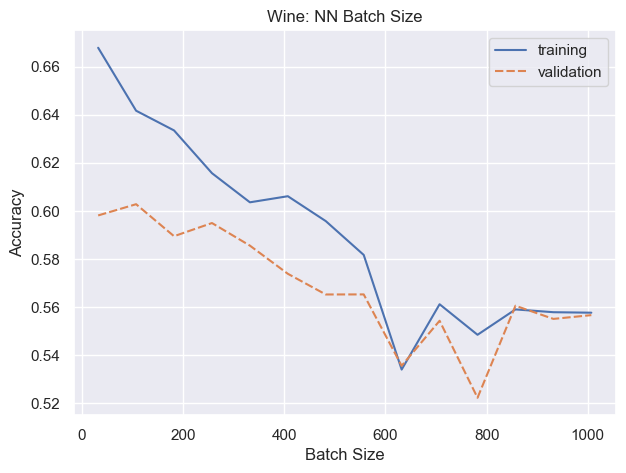

In [73]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])


plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Batch Size', ylabel='Accuracy', title='Wine: NN Batch Size');
plt.savefig('wine_nn_batch_size.png')

In [74]:
param_range = np.geomspace(1e-6, 1, num=10)

train_scores, validation_scores = validation_curve(
    KerasClassifier(build_fn=build_fn, epochs=100, batch_size=256), 
    X_train,
    y_train,
    param_name='learning_rate',
    param_range=param_range,
    cv=KFold(n_splits=5)
)

Epoch 1/100


C:\Users\legen\AppData\Local\Temp\ipykernel_20456\3724485107.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=build_fn, epochs=100, batch_size=256),


4/4 [==============================] - 0s 5ms/step - loss: 1.7883 - accuracy: 0.0811
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 1.7883 - accuracy: 0.0821
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7883 - accuracy: 0.0821
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7883 - accuracy: 0.0821
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7883 - accuracy: 0.0821
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7882 - accuracy: 0.0821
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 1.7882 - accuracy: 0.0821
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7882 - accuracy: 0.0821
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7882 - accuracy: 0.0821
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7882 - accuracy: 0.0821
Epoch 11/100
4/4 [=======================

4/4 [==============================] - 0s 4ms/step - loss: 1.7946 - accuracy: 0.0577
Epoch 67/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7946 - accuracy: 0.0577
Epoch 68/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7945 - accuracy: 0.0587
Epoch 69/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7945 - accuracy: 0.0587
Epoch 70/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7944 - accuracy: 0.0587
Epoch 71/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7944 - accuracy: 0.0587
Epoch 72/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7943 - accuracy: 0.0587
Epoch 73/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7942 - accuracy: 0.0596
Epoch 74/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7942 - accuracy: 0.0596
Epoch 75/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7941 - accuracy: 0.0596
Epoch 76/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.7495 - accuracy: 0.3236
Epoch 49/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7491 - accuracy: 0.3236
Epoch 50/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7486 - accuracy: 0.3265
Epoch 51/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7482 - accuracy: 0.3314
Epoch 52/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7478 - accuracy: 0.3392
Epoch 53/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7473 - accuracy: 0.3431
Epoch 54/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7469 - accuracy: 0.3451
Epoch 55/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7465 - accuracy: 0.3480
Epoch 56/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7461 - accuracy: 0.3548
Epoch 57/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7456 - accuracy: 0.3607
Epoch 58/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.8035 - accuracy: 0.1065
Epoch 31/100
4/4 [==============================] - 0s 5ms/step - loss: 1.8021 - accuracy: 0.1153
Epoch 32/100
4/4 [==============================] - 0s 5ms/step - loss: 1.8006 - accuracy: 0.1300
Epoch 33/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7992 - accuracy: 0.1378
Epoch 34/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7978 - accuracy: 0.1457
Epoch 35/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7964 - accuracy: 0.1613
Epoch 36/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7949 - accuracy: 0.1681
Epoch 37/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7935 - accuracy: 0.1789
Epoch 38/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7920 - accuracy: 0.1887
Epoch 39/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7906 - accuracy: 0.1945
Epoch 40/100
4/4 [===============

4/4 [==============================] - 0s 3ms/step - loss: 1.5960 - accuracy: 0.3666
Epoch 13/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5819 - accuracy: 0.3724
Epoch 14/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5668 - accuracy: 0.3763
Epoch 15/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5512 - accuracy: 0.3705
Epoch 16/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5353 - accuracy: 0.3685
Epoch 17/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5193 - accuracy: 0.3656
Epoch 18/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5032 - accuracy: 0.3548
Epoch 19/100
4/4 [==============================] - 0s 3ms/step - loss: 1.4869 - accuracy: 0.3666
Epoch 20/100
4/4 [==============================] - 0s 3ms/step - loss: 1.4697 - accuracy: 0.3871
Epoch 21/100
4/4 [==============================] - 0s 3ms/step - loss: 1.4535 - accuracy: 0.4174
Epoch 22/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.9257 - accuracy: 0.6256
Epoch 78/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9247 - accuracy: 0.6256
Epoch 79/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9228 - accuracy: 0.6256
Epoch 80/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9222 - accuracy: 0.6344
Epoch 81/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9225 - accuracy: 0.6354
Epoch 82/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9201 - accuracy: 0.6285
Epoch 83/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9197 - accuracy: 0.6305
Epoch 84/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9195 - accuracy: 0.6295
Epoch 85/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9173 - accuracy: 0.6344
Epoch 86/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9177 - accuracy: 0.6364
Epoch 87/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.8126 - accuracy: 0.6373
Epoch 60/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8106 - accuracy: 0.6403
Epoch 61/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8096 - accuracy: 0.6383
Epoch 62/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8055 - accuracy: 0.6393
Epoch 63/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8043 - accuracy: 0.6393
Epoch 64/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7998 - accuracy: 0.6432
Epoch 65/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7961 - accuracy: 0.6500
Epoch 66/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8011 - accuracy: 0.6422
Epoch 67/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7966 - accuracy: 0.6481
Epoch 68/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8042 - accuracy: 0.6422
Epoch 69/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.8075 - accuracy: 0.6637
Epoch 42/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8073 - accuracy: 0.6628
Epoch 43/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8122 - accuracy: 0.6696
Epoch 44/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8114 - accuracy: 0.6598
Epoch 45/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7973 - accuracy: 0.6716
Epoch 46/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8111 - accuracy: 0.6745
Epoch 47/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7831 - accuracy: 0.6921
Epoch 48/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7927 - accuracy: 0.6872
Epoch 49/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7893 - accuracy: 0.6891
Epoch 50/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7936 - accuracy: 0.6979
Epoch 51/100
4/4 [===============

4/4 [==============================] - 0s 3ms/step - loss: 1.2252 - accuracy: 0.4213
Epoch 24/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2252 - accuracy: 0.4213
Epoch 25/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2248 - accuracy: 0.4213
Epoch 26/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2252 - accuracy: 0.4213
Epoch 27/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2251 - accuracy: 0.4213
Epoch 28/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2250 - accuracy: 0.4213
Epoch 29/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2256 - accuracy: 0.4213
Epoch 30/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2254 - accuracy: 0.4213
Epoch 31/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2249 - accuracy: 0.4213
Epoch 32/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2254 - accuracy: 0.4213
Epoch 33/100
4/4 [===============

4/4 [==============================] - 0s 3ms/step - loss: 1.2570 - accuracy: 0.4213
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2541 - accuracy: 0.4213
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2383 - accuracy: 0.4027
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2357 - accuracy: 0.4213
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2284 - accuracy: 0.4213
Epoch 10/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2257 - accuracy: 0.4213
Epoch 11/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2312 - accuracy: 0.3861
Epoch 12/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2303 - accuracy: 0.4213
Epoch 13/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2298 - accuracy: 0.3871
Epoch 14/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2271 - accuracy: 0.4213
Epoch 15/100
4/4 [===================

4/4 [==============================] - 0s 4ms/step - loss: 1.8444 - accuracy: 0.0068
Epoch 71/100
4/4 [==============================] - 0s 3ms/step - loss: 1.8444 - accuracy: 0.0068
Epoch 72/100
4/4 [==============================] - 0s 3ms/step - loss: 1.8444 - accuracy: 0.0068
Epoch 73/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8443 - accuracy: 0.0068
Epoch 74/100
4/4 [==============================] - 0s 3ms/step - loss: 1.8443 - accuracy: 0.0068
Epoch 75/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8443 - accuracy: 0.0068
Epoch 76/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8442 - accuracy: 0.0068
Epoch 77/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8442 - accuracy: 0.0068
Epoch 78/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8442 - accuracy: 0.0068
Epoch 79/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8442 - accuracy: 0.0068
Epoch 80/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.7654 - accuracy: 0.3216
Epoch 53/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7653 - accuracy: 0.3206
Epoch 54/100
4/4 [==============================] - 0s 6ms/step - loss: 1.7651 - accuracy: 0.3206
Epoch 55/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7650 - accuracy: 0.3226
Epoch 56/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7649 - accuracy: 0.3245
Epoch 57/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7648 - accuracy: 0.3255
Epoch 58/100
4/4 [==============================] - 0s 6ms/step - loss: 1.7647 - accuracy: 0.3265
Epoch 59/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7646 - accuracy: 0.3265
Epoch 60/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7644 - accuracy: 0.3255
Epoch 61/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7643 - accuracy: 0.3265
Epoch 62/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.8359 - accuracy: 0.1623
Epoch 35/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8354 - accuracy: 0.1623
Epoch 36/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8349 - accuracy: 0.1603
Epoch 37/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8345 - accuracy: 0.1613
Epoch 38/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8340 - accuracy: 0.1623
Epoch 39/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8335 - accuracy: 0.1652
Epoch 40/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8330 - accuracy: 0.1652
Epoch 41/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8326 - accuracy: 0.1642
Epoch 42/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8321 - accuracy: 0.1652
Epoch 43/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8317 - accuracy: 0.1652
Epoch 44/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.7873 - accuracy: 0.2287
Epoch 17/100
4/4 [==============================] - 0s 3ms/step - loss: 1.7860 - accuracy: 0.2385
Epoch 18/100
4/4 [==============================] - 0s 3ms/step - loss: 1.7847 - accuracy: 0.2493
Epoch 19/100
4/4 [==============================] - 0s 3ms/step - loss: 1.7835 - accuracy: 0.2571
Epoch 20/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7822 - accuracy: 0.2669
Epoch 21/100
4/4 [==============================] - 0s 3ms/step - loss: 1.7810 - accuracy: 0.2766
Epoch 22/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7798 - accuracy: 0.2805
Epoch 23/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7786 - accuracy: 0.2874
Epoch 24/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7775 - accuracy: 0.2933
Epoch 25/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7763 - accuracy: 0.2972
Epoch 26/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.1065 - accuracy: 0.4966
Epoch 82/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1042 - accuracy: 0.5054
Epoch 83/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1018 - accuracy: 0.5112
Epoch 84/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0994 - accuracy: 0.5132
Epoch 85/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0971 - accuracy: 0.5122
Epoch 86/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0949 - accuracy: 0.5191
Epoch 87/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0926 - accuracy: 0.5220
Epoch 88/100
4/4 [==============================] - 0s 3ms/step - loss: 1.0903 - accuracy: 0.5239
Epoch 89/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0879 - accuracy: 0.5298
Epoch 90/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0858 - accuracy: 0.5318
Epoch 91/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.8875 - accuracy: 0.6158
Epoch 64/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8862 - accuracy: 0.6217
Epoch 65/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8837 - accuracy: 0.6178
Epoch 66/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8816 - accuracy: 0.6168
Epoch 67/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8802 - accuracy: 0.6158
Epoch 68/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8784 - accuracy: 0.6207
Epoch 69/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8773 - accuracy: 0.6207
Epoch 70/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8750 - accuracy: 0.6217
Epoch 71/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8739 - accuracy: 0.6197
Epoch 72/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8718 - accuracy: 0.6237
Epoch 73/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.8230 - accuracy: 0.6393
Epoch 46/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8162 - accuracy: 0.6608
Epoch 47/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8124 - accuracy: 0.6579
Epoch 48/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8065 - accuracy: 0.6706
Epoch 49/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8044 - accuracy: 0.6657
Epoch 50/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7993 - accuracy: 0.6657
Epoch 51/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7989 - accuracy: 0.6706
Epoch 52/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8003 - accuracy: 0.6823
Epoch 53/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7929 - accuracy: 0.6823
Epoch 54/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7925 - accuracy: 0.6745
Epoch 55/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.9129 - accuracy: 0.6031
Epoch 28/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9093 - accuracy: 0.6109
Epoch 29/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9071 - accuracy: 0.6139
Epoch 30/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9049 - accuracy: 0.6168
Epoch 31/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9098 - accuracy: 0.6002
Epoch 32/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9131 - accuracy: 0.5914
Epoch 33/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9096 - accuracy: 0.6109
Epoch 34/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9009 - accuracy: 0.6090
Epoch 35/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9102 - accuracy: 0.5982
Epoch 36/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9128 - accuracy: 0.5943
Epoch 37/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 0.9707 - accuracy: 0.5660
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9674 - accuracy: 0.5855
Epoch 11/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9594 - accuracy: 0.5865
Epoch 12/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9603 - accuracy: 0.5738
Epoch 13/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9608 - accuracy: 0.5738
Epoch 14/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9709 - accuracy: 0.5767
Epoch 15/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9439 - accuracy: 0.5875
Epoch 16/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9294 - accuracy: 0.5953
Epoch 17/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9239 - accuracy: 0.5728
Epoch 18/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9236 - accuracy: 0.5934
Epoch 19/100
4/4 [===============

4/4 [==============================] - 0s 3ms/step - loss: 1.1820 - accuracy: 0.4350
Epoch 75/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1865 - accuracy: 0.4066
Epoch 76/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1892 - accuracy: 0.4350
Epoch 77/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1876 - accuracy: 0.3900
Epoch 78/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1845 - accuracy: 0.4350
Epoch 79/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1838 - accuracy: 0.3939
Epoch 80/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1828 - accuracy: 0.4106
Epoch 81/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1898 - accuracy: 0.4125
Epoch 82/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1906 - accuracy: 0.3900
Epoch 83/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1971 - accuracy: 0.4350
Epoch 84/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.8025 - accuracy: 0.3294
Epoch 57/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8025 - accuracy: 0.3294
Epoch 58/100
4/4 [==============================] - 0s 5ms/step - loss: 1.8025 - accuracy: 0.3294
Epoch 59/100
4/4 [==============================] - 0s 5ms/step - loss: 1.8024 - accuracy: 0.3304
Epoch 60/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8024 - accuracy: 0.3314
Epoch 61/100
4/4 [==============================] - 0s 5ms/step - loss: 1.8024 - accuracy: 0.3314
Epoch 62/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8023 - accuracy: 0.3314
Epoch 63/100
4/4 [==============================] - 0s 5ms/step - loss: 1.8023 - accuracy: 0.3314
Epoch 64/100
4/4 [==============================] - 0s 5ms/step - loss: 1.8023 - accuracy: 0.3314
Epoch 65/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8022 - accuracy: 0.3314
Epoch 66/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.7644 - accuracy: 0.3939
Epoch 39/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7643 - accuracy: 0.3939
Epoch 40/100
4/4 [==============================] - 0s 3ms/step - loss: 1.7642 - accuracy: 0.3949
Epoch 41/100
4/4 [==============================] - 0s 3ms/step - loss: 1.7640 - accuracy: 0.3949
Epoch 42/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7639 - accuracy: 0.3949
Epoch 43/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7638 - accuracy: 0.3949
Epoch 44/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7637 - accuracy: 0.3949
Epoch 45/100
4/4 [==============================] - 0s 3ms/step - loss: 1.7636 - accuracy: 0.3949
Epoch 46/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7635 - accuracy: 0.3949
Epoch 47/100
4/4 [==============================] - 0s 3ms/step - loss: 1.7634 - accuracy: 0.3949
Epoch 48/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.7961 - accuracy: 0.1114
Epoch 21/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7955 - accuracy: 0.1114
Epoch 22/100
4/4 [==============================] - 0s 6ms/step - loss: 1.7950 - accuracy: 0.1114
Epoch 23/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7945 - accuracy: 0.1114
Epoch 24/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7939 - accuracy: 0.1114
Epoch 25/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7934 - accuracy: 0.1124
Epoch 26/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7929 - accuracy: 0.1124
Epoch 27/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7924 - accuracy: 0.1124
Epoch 28/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7919 - accuracy: 0.1134
Epoch 29/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7914 - accuracy: 0.1144
Epoch 30/100
4/4 [===============

Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7630 - accuracy: 0.3558
Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7610 - accuracy: 0.3646
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7592 - accuracy: 0.3705
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7572 - accuracy: 0.3832
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7552 - accuracy: 0.3978
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7532 - accuracy: 0.4125
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7511 - accuracy: 0.4233
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7489 - accuracy: 0.4272
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 1.7468 - accuracy: 0.4321
Epoch 11/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7446 - accuracy: 0.4340
Epoch 12/100
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 1.0261 - accuracy: 0.5885
Epoch 68/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0240 - accuracy: 0.5904
Epoch 69/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0215 - accuracy: 0.5934
Epoch 70/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0194 - accuracy: 0.5943
Epoch 71/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0169 - accuracy: 0.5934
Epoch 72/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0150 - accuracy: 0.5953
Epoch 73/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0131 - accuracy: 0.5973
Epoch 74/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0108 - accuracy: 0.5973
Epoch 75/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0087 - accuracy: 0.5982
Epoch 76/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0065 - accuracy: 0.5943
Epoch 77/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.8813 - accuracy: 0.6442
Epoch 50/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8802 - accuracy: 0.6432
Epoch 51/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8783 - accuracy: 0.6471
Epoch 52/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8770 - accuracy: 0.6471
Epoch 53/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8768 - accuracy: 0.6442
Epoch 54/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8732 - accuracy: 0.6491
Epoch 55/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8719 - accuracy: 0.6461
Epoch 56/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8704 - accuracy: 0.6540
Epoch 57/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8684 - accuracy: 0.6500
Epoch 58/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8673 - accuracy: 0.6500
Epoch 59/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.8383 - accuracy: 0.6618
Epoch 32/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8344 - accuracy: 0.6598
Epoch 33/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8289 - accuracy: 0.6637
Epoch 34/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8210 - accuracy: 0.6725
Epoch 35/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8177 - accuracy: 0.6774
Epoch 36/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8140 - accuracy: 0.6833
Epoch 37/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8039 - accuracy: 0.6833
Epoch 38/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8050 - accuracy: 0.6706
Epoch 39/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8005 - accuracy: 0.6784
Epoch 40/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8040 - accuracy: 0.6706
Epoch 41/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.8876 - accuracy: 0.6373
Epoch 14/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8790 - accuracy: 0.6305
Epoch 15/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8954 - accuracy: 0.6266
Epoch 16/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8633 - accuracy: 0.6530
Epoch 17/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8635 - accuracy: 0.6354
Epoch 18/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8617 - accuracy: 0.6520
Epoch 19/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8476 - accuracy: 0.6461
Epoch 20/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8434 - accuracy: 0.6608
Epoch 21/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8411 - accuracy: 0.6588
Epoch 22/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8403 - accuracy: 0.6676
Epoch 23/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.8597 - accuracy: 0.6285
Epoch 79/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8526 - accuracy: 0.6403
Epoch 80/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8483 - accuracy: 0.6432
Epoch 81/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8466 - accuracy: 0.6569
Epoch 82/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8366 - accuracy: 0.6413
Epoch 83/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8684 - accuracy: 0.6344
Epoch 84/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8375 - accuracy: 0.6598
Epoch 85/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8456 - accuracy: 0.6530
Epoch 86/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8611 - accuracy: 0.6452
Epoch 87/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8535 - accuracy: 0.6393
Epoch 88/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.1653 - accuracy: 0.4340
Epoch 61/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1616 - accuracy: 0.4340
Epoch 62/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1627 - accuracy: 0.4340
Epoch 63/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1617 - accuracy: 0.4340
Epoch 64/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1633 - accuracy: 0.4340
Epoch 65/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1605 - accuracy: 0.4340
Epoch 66/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1630 - accuracy: 0.4086
Epoch 67/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1619 - accuracy: 0.4340
Epoch 68/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1669 - accuracy: 0.4340
Epoch 69/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1635 - accuracy: 0.4106
Epoch 70/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.8038 - accuracy: 0.1281
Epoch 43/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8038 - accuracy: 0.1281
Epoch 44/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8038 - accuracy: 0.1281
Epoch 45/100
4/4 [==============================] - 0s 5ms/step - loss: 1.8038 - accuracy: 0.1281
Epoch 46/100
4/4 [==============================] - 0s 5ms/step - loss: 1.8037 - accuracy: 0.1281
Epoch 47/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8037 - accuracy: 0.1281
Epoch 48/100
4/4 [==============================] - 0s 5ms/step - loss: 1.8037 - accuracy: 0.1281
Epoch 49/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8037 - accuracy: 0.1281
Epoch 50/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8037 - accuracy: 0.1281
Epoch 51/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8037 - accuracy: 0.1281
Epoch 52/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.7922 - accuracy: 0.4125
Epoch 25/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7921 - accuracy: 0.4125
Epoch 26/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7920 - accuracy: 0.4125
Epoch 27/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7919 - accuracy: 0.4125
Epoch 28/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7918 - accuracy: 0.4125
Epoch 29/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7917 - accuracy: 0.4125
Epoch 30/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7916 - accuracy: 0.4125
Epoch 31/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7915 - accuracy: 0.4125
Epoch 32/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7914 - accuracy: 0.4125
Epoch 33/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7913 - accuracy: 0.4125
Epoch 34/100
4/4 [===============

4/4 [==============================] - 0s 3ms/step - loss: 1.8452 - accuracy: 0.0694
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8447 - accuracy: 0.0694
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8441 - accuracy: 0.0694
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8435 - accuracy: 0.0704
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8429 - accuracy: 0.0704
Epoch 11/100
4/4 [==============================] - 0s 3ms/step - loss: 1.8423 - accuracy: 0.0714
Epoch 12/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8417 - accuracy: 0.0714
Epoch 13/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8412 - accuracy: 0.0714
Epoch 14/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8406 - accuracy: 0.0714
Epoch 15/100
4/4 [==============================] - 0s 4ms/step - loss: 1.8400 - accuracy: 0.0714
Epoch 16/100
4/4 [==================

4/4 [==============================] - 0s 4ms/step - loss: 1.7125 - accuracy: 0.4340
Epoch 72/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7105 - accuracy: 0.4340
Epoch 73/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7086 - accuracy: 0.4321
Epoch 74/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7066 - accuracy: 0.4311
Epoch 75/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7045 - accuracy: 0.4311
Epoch 76/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7025 - accuracy: 0.4311
Epoch 77/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7004 - accuracy: 0.4311
Epoch 78/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6983 - accuracy: 0.4301
Epoch 79/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6962 - accuracy: 0.4311
Epoch 80/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6939 - accuracy: 0.4301
Epoch 81/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.4804 - accuracy: 0.4194
Epoch 54/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4716 - accuracy: 0.4194
Epoch 55/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4637 - accuracy: 0.4194
Epoch 56/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4556 - accuracy: 0.4194
Epoch 57/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4479 - accuracy: 0.4194
Epoch 58/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4410 - accuracy: 0.4194
Epoch 59/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4334 - accuracy: 0.4194
Epoch 60/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4266 - accuracy: 0.4194
Epoch 61/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4196 - accuracy: 0.4194
Epoch 62/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4127 - accuracy: 0.4194
Epoch 63/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.9956 - accuracy: 0.5650
Epoch 36/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9903 - accuracy: 0.5709
Epoch 37/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9860 - accuracy: 0.5836
Epoch 38/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9812 - accuracy: 0.5875
Epoch 39/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9762 - accuracy: 0.5826
Epoch 40/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9718 - accuracy: 0.5826
Epoch 41/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9679 - accuracy: 0.5855
Epoch 42/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9633 - accuracy: 0.5885
Epoch 43/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9598 - accuracy: 0.5963
Epoch 44/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9549 - accuracy: 0.6051
Epoch 45/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.9679 - accuracy: 0.5982
Epoch 18/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9537 - accuracy: 0.5953
Epoch 19/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9419 - accuracy: 0.6051
Epoch 20/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9462 - accuracy: 0.6002
Epoch 21/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9285 - accuracy: 0.6188
Epoch 22/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9240 - accuracy: 0.6168
Epoch 23/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9127 - accuracy: 0.6276
Epoch 24/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9103 - accuracy: 0.6256
Epoch 25/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9075 - accuracy: 0.6315
Epoch 26/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8999 - accuracy: 0.6197
Epoch 27/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.7722 - accuracy: 0.6628
Epoch 83/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7808 - accuracy: 0.6540
Epoch 84/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7620 - accuracy: 0.6725
Epoch 85/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7521 - accuracy: 0.6804
Epoch 86/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7425 - accuracy: 0.6784
Epoch 87/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7451 - accuracy: 0.6784
Epoch 88/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7403 - accuracy: 0.6725
Epoch 89/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7505 - accuracy: 0.6735
Epoch 90/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7510 - accuracy: 0.6764
Epoch 91/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7422 - accuracy: 0.6862
Epoch 92/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.2142 - accuracy: 0.4194
Epoch 65/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2149 - accuracy: 0.4145
Epoch 66/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2143 - accuracy: 0.4194
Epoch 67/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2144 - accuracy: 0.4194
Epoch 68/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2153 - accuracy: 0.3998
Epoch 69/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2145 - accuracy: 0.4194
Epoch 70/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2152 - accuracy: 0.4194
Epoch 71/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2150 - accuracy: 0.4194
Epoch 72/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2152 - accuracy: 0.4194
Epoch 73/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2147 - accuracy: 0.4194
Epoch 74/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.2181 - accuracy: 0.4194
Epoch 47/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2221 - accuracy: 0.4037
Epoch 48/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2188 - accuracy: 0.4096
Epoch 49/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2243 - accuracy: 0.3920
Epoch 50/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2167 - accuracy: 0.4076
Epoch 51/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2213 - accuracy: 0.4066
Epoch 52/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2222 - accuracy: 0.3803
Epoch 53/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2228 - accuracy: 0.3900
Epoch 54/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2254 - accuracy: 0.4194
Epoch 55/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2191 - accuracy: 0.3930
Epoch 56/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.9161 - accuracy: 0.0146
Epoch 29/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9160 - accuracy: 0.0146
Epoch 30/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9160 - accuracy: 0.0146
Epoch 31/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9159 - accuracy: 0.0146
Epoch 32/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9159 - accuracy: 0.0146
Epoch 33/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9158 - accuracy: 0.0146
Epoch 34/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9157 - accuracy: 0.0146
Epoch 35/100
4/4 [==============================] - 0s 5ms/step - loss: 1.9157 - accuracy: 0.0146
Epoch 36/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9157 - accuracy: 0.0146
Epoch 37/100
4/4 [==============================] - 0s 3ms/step - loss: 1.9156 - accuracy: 0.0146
Epoch 38/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.9752 - accuracy: 0.3799
Epoch 11/100
4/4 [==============================] - 0s 5ms/step - loss: 1.9749 - accuracy: 0.3799
Epoch 12/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9747 - accuracy: 0.3799
Epoch 13/100
4/4 [==============================] - 0s 5ms/step - loss: 1.9745 - accuracy: 0.3799
Epoch 14/100
4/4 [==============================] - 0s 5ms/step - loss: 1.9743 - accuracy: 0.3799
Epoch 15/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9741 - accuracy: 0.3799
Epoch 16/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9739 - accuracy: 0.3799
Epoch 17/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9737 - accuracy: 0.3799
Epoch 18/100
4/4 [==============================] - 0s 5ms/step - loss: 1.9734 - accuracy: 0.3799
Epoch 19/100
4/4 [==============================] - 0s 4ms/step - loss: 1.9731 - accuracy: 0.3799
Epoch 20/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.7764 - accuracy: 0.0977
Epoch 76/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7760 - accuracy: 0.0977
Epoch 77/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7757 - accuracy: 0.0967
Epoch 78/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7753 - accuracy: 0.0967
Epoch 79/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7749 - accuracy: 0.0967
Epoch 80/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7746 - accuracy: 0.0986
Epoch 81/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7742 - accuracy: 0.0996
Epoch 82/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7739 - accuracy: 0.1006
Epoch 83/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7735 - accuracy: 0.1006
Epoch 84/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7732 - accuracy: 0.1006
Epoch 85/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.7138 - accuracy: 0.4082
Epoch 58/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7114 - accuracy: 0.4102
Epoch 59/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7091 - accuracy: 0.4131
Epoch 60/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7067 - accuracy: 0.4111
Epoch 61/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7043 - accuracy: 0.4150
Epoch 62/100
4/4 [==============================] - 0s 4ms/step - loss: 1.7019 - accuracy: 0.4150
Epoch 63/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6994 - accuracy: 0.4189
Epoch 64/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6970 - accuracy: 0.4189
Epoch 65/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6945 - accuracy: 0.4180
Epoch 66/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6920 - accuracy: 0.4189
Epoch 67/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.5636 - accuracy: 0.4248
Epoch 40/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5552 - accuracy: 0.4248
Epoch 41/100
4/4 [==============================] - 0s 3ms/step - loss: 1.5465 - accuracy: 0.4248
Epoch 42/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5381 - accuracy: 0.4248
Epoch 43/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5291 - accuracy: 0.4248
Epoch 44/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5211 - accuracy: 0.4248
Epoch 45/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5125 - accuracy: 0.4248
Epoch 46/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5040 - accuracy: 0.4248
Epoch 47/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4952 - accuracy: 0.4248
Epoch 48/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4862 - accuracy: 0.4248
Epoch 49/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.0289 - accuracy: 0.5742
Epoch 22/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0159 - accuracy: 0.5723
Epoch 23/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0052 - accuracy: 0.5820
Epoch 24/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9949 - accuracy: 0.5869
Epoch 25/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9854 - accuracy: 0.5938
Epoch 26/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9785 - accuracy: 0.5918
Epoch 27/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9730 - accuracy: 0.5889
Epoch 28/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9665 - accuracy: 0.5928
Epoch 29/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9618 - accuracy: 0.5947
Epoch 30/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9578 - accuracy: 0.5977
Epoch 31/100
4/4 [===============

Epoch 3/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4334 - accuracy: 0.4648
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2677 - accuracy: 0.5059
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2588 - accuracy: 0.5127
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2264 - accuracy: 0.5225
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1805 - accuracy: 0.5215
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1441 - accuracy: 0.5527
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1116 - accuracy: 0.5693
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0900 - accuracy: 0.5830
Epoch 11/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0715 - accuracy: 0.5879
Epoch 12/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0537 - accuracy: 0.5938
Epoch 13/100
4/4 [=========

4/4 [==============================] - 0s 4ms/step - loss: 0.7721 - accuracy: 0.6406
Epoch 69/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7745 - accuracy: 0.6680
Epoch 70/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7926 - accuracy: 0.6562
Epoch 71/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7679 - accuracy: 0.6533
Epoch 72/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7651 - accuracy: 0.6631
Epoch 73/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7602 - accuracy: 0.6602
Epoch 74/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7613 - accuracy: 0.6729
Epoch 75/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7571 - accuracy: 0.6631
Epoch 76/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7631 - accuracy: 0.6670
Epoch 77/100
4/4 [==============================] - 0s 4ms/step - loss: 0.7571 - accuracy: 0.6602
Epoch 78/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.1905 - accuracy: 0.4082
Epoch 51/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1897 - accuracy: 0.4102
Epoch 52/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1899 - accuracy: 0.4248
Epoch 53/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1908 - accuracy: 0.3965
Epoch 54/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1900 - accuracy: 0.4053
Epoch 55/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1900 - accuracy: 0.4248
Epoch 56/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1897 - accuracy: 0.4248
Epoch 57/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1898 - accuracy: 0.3984
Epoch 58/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1897 - accuracy: 0.4111
Epoch 59/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1896 - accuracy: 0.4248
Epoch 60/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.1953 - accuracy: 0.4248
Epoch 33/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1936 - accuracy: 0.4111
Epoch 34/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1965 - accuracy: 0.4248
Epoch 35/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1901 - accuracy: 0.4102
Epoch 36/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1917 - accuracy: 0.4111
Epoch 37/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1914 - accuracy: 0.4248
Epoch 38/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1948 - accuracy: 0.3789
Epoch 39/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2001 - accuracy: 0.4248
Epoch 40/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1982 - accuracy: 0.4014
Epoch 41/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1901 - accuracy: 0.4424
Epoch 42/100
4/4 [===============

Best Param: 0.002154434690031882
Scores:
 training      0.649140
validation    0.598885
Name: 0.002154434690031882, dtype: float64


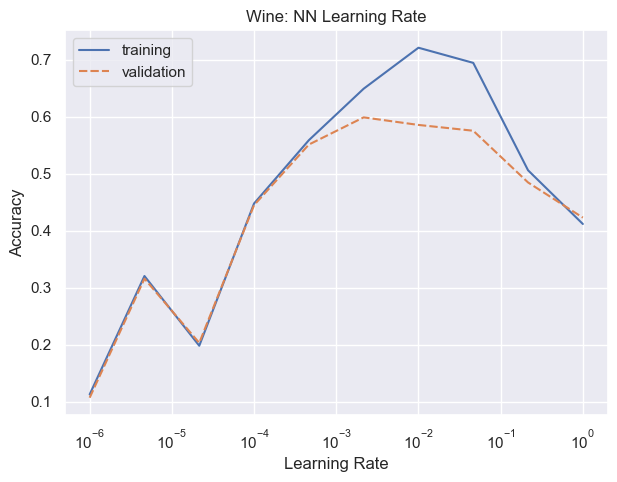

In [75]:
plot_df = pd.DataFrame()
plot_df.index = param_range
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = validation_scores.mean(axis=1)

argmax = plot_df['validation'].argmax()
print('Best Param:', param_range[argmax])
print('Scores:\n', plot_df.iloc[argmax])


plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Learning Rate', ylabel='Accuracy', title='Wine: NN Learning Rate', xscale='log');
plt.savefig('wine_nn_learning_rate.png')

In [76]:
train_sizes, train_scores, cv_scores = learning_curve(
    KerasClassifier(build_fn=build_fn, epochs=100, batch_size=256), 
    X_train, 
    y_train, 
    cv=5,
    train_sizes=np.linspace(.1, 1, num=20),
)

Epoch 1/100


C:\Users\legen\AppData\Local\Temp\ipykernel_20456\3542602006.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=build_fn, epochs=100, batch_size=256),


1/1 [==============================] - 0s 232ms/step - loss: 1.8143 - accuracy: 0.0196
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 1.8053 - accuracy: 0.0196
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 1.7966 - accuracy: 0.0196
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7883 - accuracy: 0.0196
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7802 - accuracy: 0.0294
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7725 - accuracy: 0.0490
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 1.7652 - accuracy: 0.0588
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7579 - accuracy: 0.0686
Epoch 9/100
1/1 [==============================] - 0s 9ms/step - loss: 1.7507 - accuracy: 0.1176
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7438 - accuracy: 0.1961
Epoch 11/100
1/1 [=====================

1/1 [==============================] - 0s 5ms/step - loss: 1.5892 - accuracy: 0.3800
Epoch 67/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5836 - accuracy: 0.3800
Epoch 68/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5779 - accuracy: 0.3800
Epoch 69/100
1/1 [==============================] - 0s 7ms/step - loss: 1.5721 - accuracy: 0.3800
Epoch 70/100
1/1 [==============================] - 0s 4ms/step - loss: 1.5663 - accuracy: 0.3800
Epoch 71/100
1/1 [==============================] - 0s 8ms/step - loss: 1.5604 - accuracy: 0.3800
Epoch 72/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5544 - accuracy: 0.3800
Epoch 73/100
1/1 [==============================] - 0s 6ms/step - loss: 1.5485 - accuracy: 0.3867
Epoch 74/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5424 - accuracy: 0.4000
Epoch 75/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5364 - accuracy: 0.4200
Epoch 76/100
1/1 [===============

1/1 [==============================] - 0s 6ms/step - loss: 1.5528 - accuracy: 0.3869
Epoch 49/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5451 - accuracy: 0.3869
Epoch 50/100
1/1 [==============================] - 0s 8ms/step - loss: 1.5376 - accuracy: 0.3869
Epoch 51/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5300 - accuracy: 0.3869
Epoch 52/100
1/1 [==============================] - 0s 8ms/step - loss: 1.5225 - accuracy: 0.3869
Epoch 53/100
1/1 [==============================] - 0s 4ms/step - loss: 1.5151 - accuracy: 0.3869
Epoch 54/100
1/1 [==============================] - 0s 4ms/step - loss: 1.5076 - accuracy: 0.3869
Epoch 55/100
1/1 [==============================] - 0s 5ms/step - loss: 1.5004 - accuracy: 0.3869
Epoch 56/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4931 - accuracy: 0.3869
Epoch 57/100
1/1 [==============================] - 0s 8ms/step - loss: 1.4861 - accuracy: 0.3869
Epoch 58/100
1/1 [===============

1/1 [==============================] - 0s 8ms/step - loss: 1.6611 - accuracy: 0.4008
Epoch 31/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6549 - accuracy: 0.4008
Epoch 32/100
1/1 [==============================] - 0s 7ms/step - loss: 1.6487 - accuracy: 0.4008
Epoch 33/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6425 - accuracy: 0.4008
Epoch 34/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6364 - accuracy: 0.4008
Epoch 35/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6302 - accuracy: 0.4008
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6240 - accuracy: 0.4008
Epoch 37/100
1/1 [==============================] - 0s 9ms/step - loss: 1.6179 - accuracy: 0.4008
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6118 - accuracy: 0.4008
Epoch 39/100
1/1 [==============================] - 0s 8ms/step - loss: 1.6056 - accuracy: 0.4008
Epoch 40/100
1/1 [===============

2/2 [==============================] - 0s 6ms/step - loss: 1.8028 - accuracy: 0.0507
Epoch 13/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7977 - accuracy: 0.0608
Epoch 14/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7929 - accuracy: 0.0845
Epoch 15/100
2/2 [==============================] - 0s 6ms/step - loss: 1.7886 - accuracy: 0.1115
Epoch 16/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7843 - accuracy: 0.1351
Epoch 17/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7804 - accuracy: 0.1554
Epoch 18/100
2/2 [==============================] - 0s 6ms/step - loss: 1.7768 - accuracy: 0.1655
Epoch 19/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7733 - accuracy: 0.2095
Epoch 20/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7700 - accuracy: 0.2297
Epoch 21/100
2/2 [==============================] - 0s 6ms/step - loss: 1.7667 - accuracy: 0.2500
Epoch 22/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.1471 - accuracy: 0.5465
Epoch 78/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1412 - accuracy: 0.5552
Epoch 79/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1354 - accuracy: 0.5552
Epoch 80/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1297 - accuracy: 0.5581
Epoch 81/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1241 - accuracy: 0.5523
Epoch 82/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1184 - accuracy: 0.5581
Epoch 83/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1127 - accuracy: 0.5610
Epoch 84/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1076 - accuracy: 0.5640
Epoch 85/100
2/2 [==============================] - 0s 8ms/step - loss: 1.1018 - accuracy: 0.5756
Epoch 86/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0962 - accuracy: 0.5756
Epoch 87/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.1290 - accuracy: 0.5674
Epoch 60/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1231 - accuracy: 0.5725
Epoch 61/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1167 - accuracy: 0.5751
Epoch 62/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1110 - accuracy: 0.5725
Epoch 63/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1050 - accuracy: 0.5725
Epoch 64/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0992 - accuracy: 0.5751
Epoch 65/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0934 - accuracy: 0.5827
Epoch 66/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0876 - accuracy: 0.5852
Epoch 67/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0816 - accuracy: 0.5903
Epoch 68/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0754 - accuracy: 0.5954
Epoch 69/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.1832 - accuracy: 0.5533
Epoch 42/100
2/2 [==============================] - 0s 8ms/step - loss: 1.1748 - accuracy: 0.5510
Epoch 43/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1662 - accuracy: 0.5556
Epoch 44/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1589 - accuracy: 0.5601
Epoch 45/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1516 - accuracy: 0.5624
Epoch 46/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1450 - accuracy: 0.5601
Epoch 47/100
2/2 [==============================] - 0s 10ms/step - loss: 1.1388 - accuracy: 0.5601
Epoch 48/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1331 - accuracy: 0.5601
Epoch 49/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1281 - accuracy: 0.5624
Epoch 50/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1234 - accuracy: 0.5669
Epoch 51/100
2/2 [==============

2/2 [==============================] - 0s 6ms/step - loss: 1.6739 - accuracy: 0.3885
Epoch 24/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6647 - accuracy: 0.3947
Epoch 25/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6548 - accuracy: 0.3947
Epoch 26/100
2/2 [==============================] - 0s 7ms/step - loss: 1.6447 - accuracy: 0.3947
Epoch 27/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6343 - accuracy: 0.3947
Epoch 28/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6233 - accuracy: 0.3967
Epoch 29/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6126 - accuracy: 0.3967
Epoch 30/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6017 - accuracy: 0.3967
Epoch 31/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5897 - accuracy: 0.3967
Epoch 32/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5780 - accuracy: 0.3967
Epoch 33/100
2/2 [===============

3/3 [==============================] - 0s 6ms/step - loss: 1.5237 - accuracy: 0.4033
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 1.5083 - accuracy: 0.4033
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 1.4927 - accuracy: 0.4033
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 1.4777 - accuracy: 0.4033
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4632 - accuracy: 0.4033
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4497 - accuracy: 0.4033
Epoch 11/100
3/3 [==============================] - 0s 5ms/step - loss: 1.4360 - accuracy: 0.4033
Epoch 12/100
3/3 [==============================] - 0s 5ms/step - loss: 1.4228 - accuracy: 0.4033
Epoch 13/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4095 - accuracy: 0.4033
Epoch 14/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3967 - accuracy: 0.4033
Epoch 15/100
3/3 [===================

3/3 [==============================] - 0s 5ms/step - loss: 1.1035 - accuracy: 0.5785
Epoch 71/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0996 - accuracy: 0.5700
Epoch 72/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0953 - accuracy: 0.5734
Epoch 73/100
3/3 [==============================] - 0s 7ms/step - loss: 1.0912 - accuracy: 0.5751
Epoch 74/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0873 - accuracy: 0.5734
Epoch 75/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0836 - accuracy: 0.5717
Epoch 76/100
3/3 [==============================] - 0s 10ms/step - loss: 1.0801 - accuracy: 0.5717
Epoch 77/100
3/3 [==============================] - 0s 8ms/step - loss: 1.0760 - accuracy: 0.5768
Epoch 78/100
3/3 [==============================] - 0s 8ms/step - loss: 1.0725 - accuracy: 0.5785
Epoch 79/100
3/3 [==============================] - 0s 8ms/step - loss: 1.0690 - accuracy: 0.5785
Epoch 80/100
3/3 [==============

3/3 [==============================] - 0s 4ms/step - loss: 1.0717 - accuracy: 0.5669
Epoch 53/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0680 - accuracy: 0.5701
Epoch 54/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0644 - accuracy: 0.5717
Epoch 55/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0612 - accuracy: 0.5764
Epoch 56/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0575 - accuracy: 0.5795
Epoch 57/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0540 - accuracy: 0.5811
Epoch 58/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0503 - accuracy: 0.5827
Epoch 59/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0473 - accuracy: 0.5890
Epoch 60/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0436 - accuracy: 0.5921
Epoch 61/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0404 - accuracy: 0.5906
Epoch 62/100
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.2478 - accuracy: 0.5124
Epoch 35/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2424 - accuracy: 0.5154
Epoch 36/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2371 - accuracy: 0.5183
Epoch 37/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2318 - accuracy: 0.5227
Epoch 38/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2269 - accuracy: 0.5154
Epoch 39/100
3/3 [==============================] - 0s 6ms/step - loss: 1.2221 - accuracy: 0.5168
Epoch 40/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2174 - accuracy: 0.5198
Epoch 41/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2127 - accuracy: 0.5227
Epoch 42/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2080 - accuracy: 0.5300
Epoch 43/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2039 - accuracy: 0.5315
Epoch 44/100
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.7032 - accuracy: 0.3716
Epoch 17/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6951 - accuracy: 0.3730
Epoch 18/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6867 - accuracy: 0.3730
Epoch 19/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6778 - accuracy: 0.3730
Epoch 20/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6685 - accuracy: 0.3784
Epoch 21/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6586 - accuracy: 0.3784
Epoch 22/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6481 - accuracy: 0.3784
Epoch 23/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6368 - accuracy: 0.3784
Epoch 24/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6239 - accuracy: 0.3839
Epoch 25/100
3/3 [==============================] - 0s 6ms/step - loss: 1.6101 - accuracy: 0.3866
Epoch 26/100
3/3 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.0590 - accuracy: 0.5667
Epoch 82/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0570 - accuracy: 0.5679
Epoch 83/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0560 - accuracy: 0.5718
Epoch 84/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0552 - accuracy: 0.5731
Epoch 85/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0540 - accuracy: 0.5705
Epoch 86/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0524 - accuracy: 0.5718
Epoch 87/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0491 - accuracy: 0.5731
Epoch 88/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0463 - accuracy: 0.5718
Epoch 89/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0477 - accuracy: 0.5731
Epoch 90/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0485 - accuracy: 0.5718
Epoch 91/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.1547 - accuracy: 0.5054
Epoch 64/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1507 - accuracy: 0.5054
Epoch 65/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1466 - accuracy: 0.5090
Epoch 66/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1420 - accuracy: 0.5163
Epoch 67/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1374 - accuracy: 0.5175
Epoch 68/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1326 - accuracy: 0.5175
Epoch 69/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1270 - accuracy: 0.5223
Epoch 70/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1212 - accuracy: 0.5308
Epoch 71/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1152 - accuracy: 0.5404
Epoch 72/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1095 - accuracy: 0.5476
Epoch 73/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.1184 - accuracy: 0.5644
Epoch 46/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1155 - accuracy: 0.5621
Epoch 47/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1127 - accuracy: 0.5667
Epoch 48/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1100 - accuracy: 0.5656
Epoch 49/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1076 - accuracy: 0.5690
Epoch 50/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1052 - accuracy: 0.5633
Epoch 51/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1023 - accuracy: 0.5678
Epoch 52/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1000 - accuracy: 0.5701
Epoch 53/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0975 - accuracy: 0.5724
Epoch 54/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0952 - accuracy: 0.5770
Epoch 55/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.2068 - accuracy: 0.5605
Epoch 28/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1937 - accuracy: 0.5659
Epoch 29/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1809 - accuracy: 0.5702
Epoch 30/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1692 - accuracy: 0.5734
Epoch 31/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1580 - accuracy: 0.5756
Epoch 32/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1491 - accuracy: 0.5778
Epoch 33/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1401 - accuracy: 0.5799
Epoch 34/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1314 - accuracy: 0.5821
Epoch 35/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1236 - accuracy: 0.5810
Epoch 36/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1168 - accuracy: 0.5821
Epoch 37/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.6570 - accuracy: 0.4230
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6379 - accuracy: 0.4230
Epoch 11/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6181 - accuracy: 0.4230
Epoch 12/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5968 - accuracy: 0.4230
Epoch 13/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5758 - accuracy: 0.4230
Epoch 14/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5542 - accuracy: 0.4230
Epoch 15/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5317 - accuracy: 0.4230
Epoch 16/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5088 - accuracy: 0.4230
Epoch 17/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4856 - accuracy: 0.4230
Epoch 18/100
4/4 [==============================] - 0s 4ms/step - loss: 1.4625 - accuracy: 0.4230
Epoch 19/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.9806 - accuracy: 0.6041
Epoch 75/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9788 - accuracy: 0.6022
Epoch 76/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9773 - accuracy: 0.6031
Epoch 77/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9757 - accuracy: 0.6070
Epoch 78/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9747 - accuracy: 0.6041
Epoch 79/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9730 - accuracy: 0.6051
Epoch 80/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9718 - accuracy: 0.6051
Epoch 81/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9699 - accuracy: 0.6051
Epoch 82/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9687 - accuracy: 0.6051
Epoch 83/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9670 - accuracy: 0.6061
Epoch 84/100
4/4 [===============

1/1 [==============================] - 0s 5ms/step - loss: 1.4022 - accuracy: 0.4608
Epoch 57/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3903 - accuracy: 0.4706
Epoch 58/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3783 - accuracy: 0.4804
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3663 - accuracy: 0.4804
Epoch 60/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3541 - accuracy: 0.4804
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3417 - accuracy: 0.4804
Epoch 62/100
1/1 [==============================] - 0s 4ms/step - loss: 1.3295 - accuracy: 0.4804
Epoch 63/100
1/1 [==============================] - 0s 7ms/step - loss: 1.3173 - accuracy: 0.4804
Epoch 64/100
1/1 [==============================] - 0s 4ms/step - loss: 1.3051 - accuracy: 0.4804
Epoch 65/100
1/1 [==============================] - 0s 7ms/step - loss: 1.2928 - accuracy: 0.4902
Epoch 66/100
1/1 [===============

1/1 [==============================] - 0s 5ms/step - loss: 1.3653 - accuracy: 0.5200
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3537 - accuracy: 0.5200
Epoch 40/100
1/1 [==============================] - 0s 4ms/step - loss: 1.3422 - accuracy: 0.5200
Epoch 41/100
1/1 [==============================] - 0s 7ms/step - loss: 1.3308 - accuracy: 0.5400
Epoch 42/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3194 - accuracy: 0.5600
Epoch 43/100
1/1 [==============================] - 0s 9ms/step - loss: 1.3081 - accuracy: 0.5667
Epoch 44/100
1/1 [==============================] - 0s 4ms/step - loss: 1.2969 - accuracy: 0.5733
Epoch 45/100
1/1 [==============================] - 0s 8ms/step - loss: 1.2859 - accuracy: 0.5667
Epoch 46/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2750 - accuracy: 0.5800
Epoch 47/100
1/1 [==============================] - 0s 8ms/step - loss: 1.2642 - accuracy: 0.5800
Epoch 48/100
1/1 [===============

1/1 [==============================] - 0s 6ms/step - loss: 1.7668 - accuracy: 0.1809
Epoch 21/100
1/1 [==============================] - 0s 4ms/step - loss: 1.7637 - accuracy: 0.2060
Epoch 22/100
1/1 [==============================] - 0s 4ms/step - loss: 1.7606 - accuracy: 0.2111
Epoch 23/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7575 - accuracy: 0.2312
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7543 - accuracy: 0.2312
Epoch 25/100
1/1 [==============================] - 0s 8ms/step - loss: 1.7510 - accuracy: 0.2462
Epoch 26/100
1/1 [==============================] - 0s 4ms/step - loss: 1.7477 - accuracy: 0.2864
Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7444 - accuracy: 0.3065
Epoch 28/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7409 - accuracy: 0.3116
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7373 - accuracy: 0.3065
Epoch 30/100
1/1 [===============

Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6827 - accuracy: 0.2915
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 1.6744 - accuracy: 0.3320
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6662 - accuracy: 0.3563
Epoch 5/100
1/1 [==============================] - 0s 8ms/step - loss: 1.6581 - accuracy: 0.3684
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6501 - accuracy: 0.3725
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: 1.6420 - accuracy: 0.3846
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6340 - accuracy: 0.3887
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 1.6259 - accuracy: 0.3968
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6179 - accuracy: 0.3968
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 1.6101 - accuracy: 0.4049
Epoch 12/100
1/1 [=========

2/2 [==============================] - 0s 5ms/step - loss: 1.0477 - accuracy: 0.5169
Epoch 68/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0429 - accuracy: 0.5135
Epoch 69/100
2/2 [==============================] - 0s 7ms/step - loss: 1.0383 - accuracy: 0.5169
Epoch 70/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0337 - accuracy: 0.5304
Epoch 71/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0291 - accuracy: 0.5338
Epoch 72/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0241 - accuracy: 0.5473
Epoch 73/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0192 - accuracy: 0.5574
Epoch 74/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0143 - accuracy: 0.5507
Epoch 75/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0092 - accuracy: 0.5642
Epoch 76/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0036 - accuracy: 0.5743
Epoch 77/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.0807 - accuracy: 0.4448
Epoch 50/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0782 - accuracy: 0.4448
Epoch 51/100
2/2 [==============================] - 0s 7ms/step - loss: 1.0756 - accuracy: 0.4477
Epoch 52/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0731 - accuracy: 0.4477
Epoch 53/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0707 - accuracy: 0.4593
Epoch 54/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0687 - accuracy: 0.4767
Epoch 55/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0663 - accuracy: 0.4826
Epoch 56/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0639 - accuracy: 0.4738
Epoch 57/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0613 - accuracy: 0.4622
Epoch 58/100
2/2 [==============================] - 0s 10ms/step - loss: 1.0591 - accuracy: 0.4564
Epoch 59/100
2/2 [==============

2/2 [==============================] - 0s 6ms/step - loss: 1.5123 - accuracy: 0.5827
Epoch 32/100
2/2 [==============================] - 0s 7ms/step - loss: 1.4934 - accuracy: 0.5852
Epoch 33/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4731 - accuracy: 0.5878
Epoch 34/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4524 - accuracy: 0.5954
Epoch 35/100
2/2 [==============================] - 0s 6ms/step - loss: 1.4303 - accuracy: 0.5954
Epoch 36/100
2/2 [==============================] - 0s 6ms/step - loss: 1.4080 - accuracy: 0.5954
Epoch 37/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3842 - accuracy: 0.5980
Epoch 38/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3600 - accuracy: 0.5929
Epoch 39/100
2/2 [==============================] - 0s 6ms/step - loss: 1.3352 - accuracy: 0.5954
Epoch 40/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3104 - accuracy: 0.5929
Epoch 41/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.6722 - accuracy: 0.4150
Epoch 14/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6606 - accuracy: 0.4150
Epoch 15/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6493 - accuracy: 0.4150
Epoch 16/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6375 - accuracy: 0.4150
Epoch 17/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6250 - accuracy: 0.4150
Epoch 18/100
2/2 [==============================] - 0s 6ms/step - loss: 1.6126 - accuracy: 0.4150
Epoch 19/100
2/2 [==============================] - 0s 6ms/step - loss: 1.6001 - accuracy: 0.4150
Epoch 20/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5870 - accuracy: 0.4150
Epoch 21/100
2/2 [==============================] - 0s 5ms/step - loss: 1.5733 - accuracy: 0.4150
Epoch 22/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5596 - accuracy: 0.4150
Epoch 23/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.4700 - accuracy: 0.4990
Epoch 79/100
2/2 [==============================] - 0s 6ms/step - loss: 1.4608 - accuracy: 0.4990
Epoch 80/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4514 - accuracy: 0.4990
Epoch 81/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4421 - accuracy: 0.5010
Epoch 82/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4322 - accuracy: 0.5010
Epoch 83/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4227 - accuracy: 0.4969
Epoch 84/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4133 - accuracy: 0.4969
Epoch 85/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4035 - accuracy: 0.4949
Epoch 86/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3934 - accuracy: 0.4928
Epoch 87/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3834 - accuracy: 0.4949
Epoch 88/100
2/2 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.0574 - accuracy: 0.5688
Epoch 61/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0536 - accuracy: 0.5725
Epoch 62/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0496 - accuracy: 0.5762
Epoch 63/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0455 - accuracy: 0.5799
Epoch 64/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0413 - accuracy: 0.5874
Epoch 65/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0372 - accuracy: 0.5874
Epoch 66/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0328 - accuracy: 0.5836
Epoch 67/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0286 - accuracy: 0.5855
Epoch 68/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0236 - accuracy: 0.5836
Epoch 69/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0189 - accuracy: 0.5799
Epoch 70/100
3/3 [===============

3/3 [==============================] - 0s 6ms/step - loss: 1.1060 - accuracy: 0.5392
Epoch 43/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0990 - accuracy: 0.5410
Epoch 44/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0927 - accuracy: 0.5444
Epoch 45/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0860 - accuracy: 0.5478
Epoch 46/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0801 - accuracy: 0.5495
Epoch 47/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0746 - accuracy: 0.5495
Epoch 48/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0696 - accuracy: 0.5529
Epoch 49/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0643 - accuracy: 0.5529
Epoch 50/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0590 - accuracy: 0.5495
Epoch 51/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0536 - accuracy: 0.5546
Epoch 52/100
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 1.6441 - accuracy: 0.4283
Epoch 25/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6322 - accuracy: 0.4142
Epoch 26/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6192 - accuracy: 0.4205
Epoch 27/100
3/3 [==============================] - 0s 6ms/step - loss: 1.6053 - accuracy: 0.4189
Epoch 28/100
3/3 [==============================] - 0s 6ms/step - loss: 1.5904 - accuracy: 0.4157
Epoch 29/100
3/3 [==============================] - 0s 6ms/step - loss: 1.5748 - accuracy: 0.4079
Epoch 30/100
3/3 [==============================] - 0s 6ms/step - loss: 1.5575 - accuracy: 0.4000
Epoch 31/100
3/3 [==============================] - 0s 5ms/step - loss: 1.5395 - accuracy: 0.4016
Epoch 32/100
3/3 [==============================] - 0s 6ms/step - loss: 1.5202 - accuracy: 0.4047
Epoch 33/100
3/3 [==============================] - 0s 5ms/step - loss: 1.5005 - accuracy: 0.4079
Epoch 34/100
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.7784 - accuracy: 0.1933
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7693 - accuracy: 0.2313
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7609 - accuracy: 0.2635
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 1.7526 - accuracy: 0.3060
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7444 - accuracy: 0.3514
Epoch 11/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7363 - accuracy: 0.3719
Epoch 12/100
3/3 [==============================] - 0s 4ms/step - loss: 1.7280 - accuracy: 0.3880
Epoch 13/100
3/3 [==============================] - 0s 4ms/step - loss: 1.7197 - accuracy: 0.3968
Epoch 14/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7110 - accuracy: 0.3968
Epoch 15/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7022 - accuracy: 0.3997
Epoch 16/100
3/3 [==================

3/3 [==============================] - 0s 4ms/step - loss: 1.0522 - accuracy: 0.5342
Epoch 72/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0494 - accuracy: 0.5355
Epoch 73/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0468 - accuracy: 0.5369
Epoch 74/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0444 - accuracy: 0.5437
Epoch 75/100
3/3 [==============================] - 0s 3ms/step - loss: 1.0417 - accuracy: 0.5492
Epoch 76/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0393 - accuracy: 0.5410
Epoch 77/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0369 - accuracy: 0.5478
Epoch 78/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0343 - accuracy: 0.5451
Epoch 79/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0315 - accuracy: 0.5478
Epoch 80/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0293 - accuracy: 0.5492
Epoch 81/100
3/3 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.9892 - accuracy: 0.5577
Epoch 54/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9872 - accuracy: 0.5577
Epoch 55/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9847 - accuracy: 0.5641
Epoch 56/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9818 - accuracy: 0.5705
Epoch 57/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9793 - accuracy: 0.5744
Epoch 58/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9775 - accuracy: 0.5731
Epoch 59/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9748 - accuracy: 0.5718
Epoch 60/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9729 - accuracy: 0.5731
Epoch 61/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9703 - accuracy: 0.5718
Epoch 62/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9681 - accuracy: 0.5744
Epoch 63/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.2345 - accuracy: 0.4403
Epoch 36/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2170 - accuracy: 0.4403
Epoch 37/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2006 - accuracy: 0.4415
Epoch 38/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1853 - accuracy: 0.4463
Epoch 39/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1715 - accuracy: 0.4548
Epoch 40/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1588 - accuracy: 0.4572
Epoch 41/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1475 - accuracy: 0.4656
Epoch 42/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1369 - accuracy: 0.4704
Epoch 43/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1288 - accuracy: 0.4801
Epoch 44/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1211 - accuracy: 0.4897
Epoch 45/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.3649 - accuracy: 0.5667
Epoch 18/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3320 - accuracy: 0.5690
Epoch 19/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2991 - accuracy: 0.5713
Epoch 20/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2670 - accuracy: 0.5735
Epoch 21/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2356 - accuracy: 0.5724
Epoch 22/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2042 - accuracy: 0.5690
Epoch 23/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1741 - accuracy: 0.5690
Epoch 24/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1470 - accuracy: 0.5678
Epoch 25/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1204 - accuracy: 0.5678
Epoch 26/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0979 - accuracy: 0.5701
Epoch 27/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.9051 - accuracy: 0.6004
Epoch 83/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9032 - accuracy: 0.6015
Epoch 84/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9012 - accuracy: 0.6015
Epoch 85/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8993 - accuracy: 0.6015
Epoch 86/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8973 - accuracy: 0.6026
Epoch 87/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8952 - accuracy: 0.6037
Epoch 88/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8933 - accuracy: 0.6058
Epoch 89/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8910 - accuracy: 0.6037
Epoch 90/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8897 - accuracy: 0.6048
Epoch 91/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8874 - accuracy: 0.6037
Epoch 92/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.9696 - accuracy: 0.5842
Epoch 65/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9664 - accuracy: 0.5842
Epoch 66/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9636 - accuracy: 0.5883
Epoch 67/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9610 - accuracy: 0.5862
Epoch 68/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9580 - accuracy: 0.5883
Epoch 69/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9551 - accuracy: 0.5903
Epoch 70/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9529 - accuracy: 0.5903
Epoch 71/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9502 - accuracy: 0.5965
Epoch 72/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9475 - accuracy: 0.6016
Epoch 73/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9453 - accuracy: 0.6016
Epoch 74/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.1427 - accuracy: 0.4350
Epoch 47/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1398 - accuracy: 0.4350
Epoch 48/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1369 - accuracy: 0.4350
Epoch 49/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1340 - accuracy: 0.4389
Epoch 50/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1312 - accuracy: 0.4399
Epoch 51/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1283 - accuracy: 0.4457
Epoch 52/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1253 - accuracy: 0.4506
Epoch 53/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1223 - accuracy: 0.4536
Epoch 54/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1191 - accuracy: 0.4653
Epoch 55/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1161 - accuracy: 0.4731
Epoch 56/100
4/4 [===============

1/1 [==============================] - 0s 5ms/step - loss: 1.6817 - accuracy: 0.4314
Epoch 29/100
1/1 [==============================] - 0s 11ms/step - loss: 1.6759 - accuracy: 0.4314
Epoch 30/100
1/1 [==============================] - 0s 7ms/step - loss: 1.6699 - accuracy: 0.4314
Epoch 31/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6637 - accuracy: 0.4314
Epoch 32/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6574 - accuracy: 0.4314
Epoch 33/100
1/1 [==============================] - 0s 7ms/step - loss: 1.6507 - accuracy: 0.4314
Epoch 34/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6438 - accuracy: 0.4216
Epoch 35/100
1/1 [==============================] - 0s 7ms/step - loss: 1.6365 - accuracy: 0.4118
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6290 - accuracy: 0.4118
Epoch 37/100
1/1 [==============================] - 0s 7ms/step - loss: 1.6213 - accuracy: 0.4118
Epoch 38/100
1/1 [==============

1/1 [==============================] - 0s 5ms/step - loss: 1.7192 - accuracy: 0.3467
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7133 - accuracy: 0.3933
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7073 - accuracy: 0.4000
Epoch 13/100
1/1 [==============================] - 0s 7ms/step - loss: 1.7012 - accuracy: 0.4267
Epoch 14/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6949 - accuracy: 0.4467
Epoch 15/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6886 - accuracy: 0.4467
Epoch 16/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6820 - accuracy: 0.4333
Epoch 17/100
1/1 [==============================] - 0s 4ms/step - loss: 1.6753 - accuracy: 0.4467
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6686 - accuracy: 0.4533
Epoch 19/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6616 - accuracy: 0.4600
Epoch 20/100
1/1 [===============

Epoch 75/100
1/1 [==============================] - 0s 8ms/step - loss: 1.2879 - accuracy: 0.4472
Epoch 76/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2754 - accuracy: 0.4472
Epoch 77/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2628 - accuracy: 0.4472
Epoch 78/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2503 - accuracy: 0.4472
Epoch 79/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2376 - accuracy: 0.4472
Epoch 80/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2250 - accuracy: 0.4472
Epoch 81/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2123 - accuracy: 0.4472
Epoch 82/100
1/1 [==============================] - 0s 8ms/step - loss: 1.1998 - accuracy: 0.4523
Epoch 83/100
1/1 [==============================] - 0s 7ms/step - loss: 1.1873 - accuracy: 0.4573
Epoch 84/100
1/1 [==============================] - 0s 7ms/step - loss: 1.1750 - accuracy: 0.4623
Epoch 85/100
1/1 [==

2/2 [==============================] - 0s 5ms/step - loss: 1.2498 - accuracy: 0.4459
Epoch 39/100
2/2 [==============================] - 0s 6ms/step - loss: 1.2359 - accuracy: 0.4459
Epoch 40/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2225 - accuracy: 0.4426
Epoch 41/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2096 - accuracy: 0.4426
Epoch 42/100
2/2 [==============================] - 0s 8ms/step - loss: 1.1973 - accuracy: 0.4493
Epoch 43/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1860 - accuracy: 0.4527
Epoch 44/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1750 - accuracy: 0.4527
Epoch 45/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1645 - accuracy: 0.4561
Epoch 46/100
2/2 [==============================] - 0s 12ms/step - loss: 1.1547 - accuracy: 0.4730
Epoch 47/100
2/2 [==============================] - 0s 8ms/step - loss: 1.1451 - accuracy: 0.4966
Epoch 48/100
2/2 [==============

2/2 [==============================] - 0s 4ms/step - loss: 1.6058 - accuracy: 0.5000
Epoch 21/100
2/2 [==============================] - 0s 8ms/step - loss: 1.5932 - accuracy: 0.5000
Epoch 22/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5802 - accuracy: 0.4971
Epoch 23/100
2/2 [==============================] - 0s 5ms/step - loss: 1.5663 - accuracy: 0.4971
Epoch 24/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5534 - accuracy: 0.4971
Epoch 25/100
2/2 [==============================] - 0s 5ms/step - loss: 1.5396 - accuracy: 0.5029
Epoch 26/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5253 - accuracy: 0.5000
Epoch 27/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5114 - accuracy: 0.5000
Epoch 28/100
2/2 [==============================] - 0s 7ms/step - loss: 1.4969 - accuracy: 0.5029
Epoch 29/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4828 - accuracy: 0.5029
Epoch 30/100
2/2 [===============

Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7792 - accuracy: 0.3817
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 1.7711 - accuracy: 0.4071
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7630 - accuracy: 0.4300
Epoch 5/100
2/2 [==============================] - 0s 10ms/step - loss: 1.7546 - accuracy: 0.4326
Epoch 6/100
2/2 [==============================] - 0s 8ms/step - loss: 1.7466 - accuracy: 0.4351
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7383 - accuracy: 0.4326
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7297 - accuracy: 0.4326
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 1.7213 - accuracy: 0.4351
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7127 - accuracy: 0.4377
Epoch 11/100
2/2 [==============================] - 0s 5ms/step - loss: 1.7039 - accuracy: 0.4351
Epoch 12/100
2/2 [=========

2/2 [==============================] - 0s 6ms/step - loss: 1.0150 - accuracy: 0.6100
Epoch 68/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0092 - accuracy: 0.6100
Epoch 69/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0041 - accuracy: 0.6100
Epoch 70/100
2/2 [==============================] - 0s 6ms/step - loss: 0.9984 - accuracy: 0.6100
Epoch 71/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9935 - accuracy: 0.6122
Epoch 72/100
2/2 [==============================] - 0s 5ms/step - loss: 0.9886 - accuracy: 0.6145
Epoch 73/100
2/2 [==============================] - 0s 6ms/step - loss: 0.9844 - accuracy: 0.6145
Epoch 74/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9795 - accuracy: 0.6145
Epoch 75/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9758 - accuracy: 0.6168
Epoch 76/100
2/2 [==============================] - 0s 7ms/step - loss: 0.9714 - accuracy: 0.6145
Epoch 77/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.1904 - accuracy: 0.5235
Epoch 50/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1785 - accuracy: 0.5317
Epoch 51/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1673 - accuracy: 0.5358
Epoch 52/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1571 - accuracy: 0.5378
Epoch 53/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1474 - accuracy: 0.5378
Epoch 54/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1382 - accuracy: 0.5378
Epoch 55/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1304 - accuracy: 0.5378
Epoch 56/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1227 - accuracy: 0.5399
Epoch 57/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1154 - accuracy: 0.5378
Epoch 58/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1090 - accuracy: 0.5378
Epoch 59/100
2/2 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.4369 - accuracy: 0.4312
Epoch 32/100
3/3 [==============================] - 0s 4ms/step - loss: 1.4131 - accuracy: 0.4349
Epoch 33/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3887 - accuracy: 0.4387
Epoch 34/100
3/3 [==============================] - 0s 5ms/step - loss: 1.3649 - accuracy: 0.4442
Epoch 35/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3418 - accuracy: 0.4498
Epoch 36/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3202 - accuracy: 0.4610
Epoch 37/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2994 - accuracy: 0.4740
Epoch 38/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2800 - accuracy: 0.4907
Epoch 39/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2627 - accuracy: 0.5056
Epoch 40/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2459 - accuracy: 0.5037
Epoch 41/100
3/3 [===============

3/3 [==============================] - 0s 6ms/step - loss: 1.6658 - accuracy: 0.4403
Epoch 14/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6505 - accuracy: 0.4334
Epoch 15/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6348 - accuracy: 0.4266
Epoch 16/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6186 - accuracy: 0.4266
Epoch 17/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6025 - accuracy: 0.4113
Epoch 18/100
3/3 [==============================] - 0s 4ms/step - loss: 1.5854 - accuracy: 0.4181
Epoch 19/100
3/3 [==============================] - 0s 4ms/step - loss: 1.5671 - accuracy: 0.4249
Epoch 20/100
3/3 [==============================] - 0s 5ms/step - loss: 1.5483 - accuracy: 0.4266
Epoch 21/100
3/3 [==============================] - 0s 6ms/step - loss: 1.5272 - accuracy: 0.4369
Epoch 22/100
3/3 [==============================] - 0s 5ms/step - loss: 1.5065 - accuracy: 0.4437
Epoch 23/100
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 0.8960 - accuracy: 0.6094
Epoch 79/100
3/3 [==============================] - 0s 6ms/step - loss: 0.8936 - accuracy: 0.6094
Epoch 80/100
3/3 [==============================] - 0s 5ms/step - loss: 0.8915 - accuracy: 0.6142
Epoch 81/100
3/3 [==============================] - 0s 6ms/step - loss: 0.8890 - accuracy: 0.6142
Epoch 82/100
3/3 [==============================] - 0s 7ms/step - loss: 0.8868 - accuracy: 0.6142
Epoch 83/100
3/3 [==============================] - 0s 6ms/step - loss: 0.8843 - accuracy: 0.6126
Epoch 84/100
3/3 [==============================] - 0s 6ms/step - loss: 0.8824 - accuracy: 0.6157
Epoch 85/100
3/3 [==============================] - 0s 5ms/step - loss: 0.8803 - accuracy: 0.6189
Epoch 86/100
3/3 [==============================] - 0s 5ms/step - loss: 0.8781 - accuracy: 0.6205
Epoch 87/100
3/3 [==============================] - 0s 5ms/step - loss: 0.8759 - accuracy: 0.6205
Epoch 88/100
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.0618 - accuracy: 0.5608
Epoch 61/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0462 - accuracy: 0.5930
Epoch 62/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0313 - accuracy: 0.5988
Epoch 63/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0185 - accuracy: 0.6018
Epoch 64/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0075 - accuracy: 0.6061
Epoch 65/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9970 - accuracy: 0.6047
Epoch 66/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9865 - accuracy: 0.5959
Epoch 67/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9789 - accuracy: 0.5974
Epoch 68/100
3/3 [==============================] - 0s 6ms/step - loss: 0.9712 - accuracy: 0.6032
Epoch 69/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9644 - accuracy: 0.6061
Epoch 70/100
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 1.0985 - accuracy: 0.5478
Epoch 43/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0920 - accuracy: 0.5492
Epoch 44/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0852 - accuracy: 0.5574
Epoch 45/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0786 - accuracy: 0.5642
Epoch 46/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0720 - accuracy: 0.5806
Epoch 47/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0656 - accuracy: 0.5861
Epoch 48/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0593 - accuracy: 0.5943
Epoch 49/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0535 - accuracy: 0.5970
Epoch 50/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0472 - accuracy: 0.6093
Epoch 51/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0416 - accuracy: 0.6107
Epoch 52/100
3/3 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.1482 - accuracy: 0.5282
Epoch 25/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1368 - accuracy: 0.5346
Epoch 26/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1265 - accuracy: 0.5436
Epoch 27/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1163 - accuracy: 0.5526
Epoch 28/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1072 - accuracy: 0.5577
Epoch 29/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0972 - accuracy: 0.5641
Epoch 30/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0885 - accuracy: 0.5590
Epoch 31/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0812 - accuracy: 0.5692
Epoch 32/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0749 - accuracy: 0.5795
Epoch 33/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0670 - accuracy: 0.5769
Epoch 34/100
4/4 [===============

4/4 [==============================] - 0s 6ms/step - loss: 1.7748 - accuracy: 0.1653
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7602 - accuracy: 0.2364
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7469 - accuracy: 0.2811
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7344 - accuracy: 0.3366
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 1.7211 - accuracy: 0.3824
Epoch 11/100
4/4 [==============================] - 0s 6ms/step - loss: 1.7082 - accuracy: 0.4427
Epoch 12/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6949 - accuracy: 0.4741
Epoch 13/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6808 - accuracy: 0.4837
Epoch 14/100
4/4 [==============================] - 0s 4ms/step - loss: 1.6662 - accuracy: 0.4922
Epoch 15/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6500 - accuracy: 0.5006
Epoch 16/100
4/4 [==================

4/4 [==============================] - 0s 5ms/step - loss: 0.8970 - accuracy: 0.6488
Epoch 72/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8947 - accuracy: 0.6488
Epoch 73/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8923 - accuracy: 0.6488
Epoch 74/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8904 - accuracy: 0.6465
Epoch 75/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8878 - accuracy: 0.6511
Epoch 76/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8853 - accuracy: 0.6534
Epoch 77/100
4/4 [==============================] - 0s 5ms/step - loss: 0.8837 - accuracy: 0.6511
Epoch 78/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8813 - accuracy: 0.6499
Epoch 79/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8788 - accuracy: 0.6534
Epoch 80/100
4/4 [==============================] - 0s 4ms/step - loss: 0.8767 - accuracy: 0.6522
Epoch 81/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 0.9810 - accuracy: 0.6102
Epoch 54/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9770 - accuracy: 0.6134
Epoch 55/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9733 - accuracy: 0.6134
Epoch 56/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9696 - accuracy: 0.6145
Epoch 57/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9663 - accuracy: 0.6177
Epoch 58/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9626 - accuracy: 0.6166
Epoch 59/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9596 - accuracy: 0.6188
Epoch 60/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9563 - accuracy: 0.6188
Epoch 61/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9533 - accuracy: 0.6242
Epoch 62/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9501 - accuracy: 0.6263
Epoch 63/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.0592 - accuracy: 0.5719
Epoch 36/100
4/4 [==============================] - 0s 6ms/step - loss: 1.0512 - accuracy: 0.5780
Epoch 37/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0429 - accuracy: 0.5801
Epoch 38/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0350 - accuracy: 0.5801
Epoch 39/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0277 - accuracy: 0.5791
Epoch 40/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0210 - accuracy: 0.5811
Epoch 41/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0148 - accuracy: 0.5791
Epoch 42/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0088 - accuracy: 0.5791
Epoch 43/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0036 - accuracy: 0.5791
Epoch 44/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9984 - accuracy: 0.5801
Epoch 45/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.5357 - accuracy: 0.4829
Epoch 18/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5063 - accuracy: 0.4878
Epoch 19/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4753 - accuracy: 0.4878
Epoch 20/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4429 - accuracy: 0.5024
Epoch 21/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4091 - accuracy: 0.5132
Epoch 22/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3765 - accuracy: 0.5249
Epoch 23/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3425 - accuracy: 0.5318
Epoch 24/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3093 - accuracy: 0.5396
Epoch 25/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2777 - accuracy: 0.5611
Epoch 26/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2472 - accuracy: 0.5767
Epoch 27/100
4/4 [===============

1/1 [==============================] - 0s 4ms/step - loss: 1.3029 - accuracy: 0.4118
Epoch 83/100
1/1 [==============================] - 0s 9ms/step - loss: 1.2963 - accuracy: 0.4118
Epoch 84/100
1/1 [==============================] - 0s 8ms/step - loss: 1.2894 - accuracy: 0.4118
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2824 - accuracy: 0.4118
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2753 - accuracy: 0.4118
Epoch 87/100
1/1 [==============================] - 0s 7ms/step - loss: 1.2678 - accuracy: 0.4118
Epoch 88/100
1/1 [==============================] - 0s 4ms/step - loss: 1.2601 - accuracy: 0.4118
Epoch 89/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2521 - accuracy: 0.4118
Epoch 90/100
1/1 [==============================] - 0s 4ms/step - loss: 1.2440 - accuracy: 0.4118
Epoch 91/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2358 - accuracy: 0.4118
Epoch 92/100
1/1 [===============

Epoch 64/100
1/1 [==============================] - 0s 7ms/step - loss: 1.2644 - accuracy: 0.6067
Epoch 65/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2510 - accuracy: 0.5933
Epoch 66/100
1/1 [==============================] - 0s 8ms/step - loss: 1.2378 - accuracy: 0.5733
Epoch 67/100
1/1 [==============================] - 0s 4ms/step - loss: 1.2247 - accuracy: 0.5867
Epoch 68/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2118 - accuracy: 0.5867
Epoch 69/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1989 - accuracy: 0.5667
Epoch 70/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1860 - accuracy: 0.5467
Epoch 71/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1736 - accuracy: 0.5467
Epoch 72/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1613 - accuracy: 0.5400
Epoch 73/100
1/1 [==============================] - 0s 9ms/step - loss: 1.1493 - accuracy: 0.5333
Epoch 74/100
1/1 [==

Epoch 27/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7528 - accuracy: 0.3765
Epoch 28/100
1/1 [==============================] - 0s 9ms/step - loss: 1.7504 - accuracy: 0.3927
Epoch 29/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7480 - accuracy: 0.4049
Epoch 30/100
1/1 [==============================] - 0s 8ms/step - loss: 1.7456 - accuracy: 0.4211
Epoch 31/100
1/1 [==============================] - 0s 4ms/step - loss: 1.7433 - accuracy: 0.4251
Epoch 32/100
1/1 [==============================] - 0s 8ms/step - loss: 1.7409 - accuracy: 0.4291
Epoch 33/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7385 - accuracy: 0.4291
Epoch 34/100
1/1 [==============================] - 0s 10ms/step - loss: 1.7361 - accuracy: 0.4372
Epoch 35/100
1/1 [==============================] - 0s 4ms/step - loss: 1.7336 - accuracy: 0.4413
Epoch 36/100
1/1 [==============================] - 0s 8ms/step - loss: 1.7312 - accuracy: 0.4413
Epoch 37/100
1/1 [=

2/2 [==============================] - 0s 4ms/step - loss: 0.9937 - accuracy: 0.6115
Epoch 92/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9910 - accuracy: 0.6149
Epoch 93/100
2/2 [==============================] - 0s 5ms/step - loss: 0.9877 - accuracy: 0.6182
Epoch 94/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9847 - accuracy: 0.6250
Epoch 95/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9814 - accuracy: 0.6284
Epoch 96/100
2/2 [==============================] - 0s 5ms/step - loss: 0.9783 - accuracy: 0.6250
Epoch 97/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9750 - accuracy: 0.6250
Epoch 98/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9719 - accuracy: 0.6216
Epoch 99/100
2/2 [==============================] - 0s 7ms/step - loss: 0.9692 - accuracy: 0.6250
Epoch 100/100
2/2 [==============================] - 0s 3ms/step - loss: 0.9639 - accuracy: 0.6216
Epoch 1/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.0767 - accuracy: 0.4913
Epoch 74/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0748 - accuracy: 0.5029
Epoch 75/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0728 - accuracy: 0.5000
Epoch 76/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0707 - accuracy: 0.5058
Epoch 77/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0688 - accuracy: 0.5087
Epoch 78/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0668 - accuracy: 0.5116
Epoch 79/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0648 - accuracy: 0.5087
Epoch 80/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0628 - accuracy: 0.5058
Epoch 81/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0609 - accuracy: 0.5058
Epoch 82/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0590 - accuracy: 0.5058
Epoch 83/100
2/2 [===============

2/2 [==============================] - 0s 6ms/step - loss: 0.9619 - accuracy: 0.5878
Epoch 56/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9578 - accuracy: 0.5878
Epoch 57/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9540 - accuracy: 0.5980
Epoch 58/100
2/2 [==============================] - 0s 7ms/step - loss: 0.9506 - accuracy: 0.5980
Epoch 59/100
2/2 [==============================] - 0s 6ms/step - loss: 0.9474 - accuracy: 0.5980
Epoch 60/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9446 - accuracy: 0.6005
Epoch 61/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9418 - accuracy: 0.6005
Epoch 62/100
2/2 [==============================] - 0s 5ms/step - loss: 0.9394 - accuracy: 0.6005
Epoch 63/100
2/2 [==============================] - 0s 5ms/step - loss: 0.9371 - accuracy: 0.6031
Epoch 64/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9348 - accuracy: 0.6056
Epoch 65/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.1948 - accuracy: 0.3968
Epoch 38/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1913 - accuracy: 0.3855
Epoch 39/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1883 - accuracy: 0.3923
Epoch 40/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1850 - accuracy: 0.3946
Epoch 41/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1823 - accuracy: 0.4082
Epoch 42/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1794 - accuracy: 0.4172
Epoch 43/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1770 - accuracy: 0.4218
Epoch 44/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1742 - accuracy: 0.4308
Epoch 45/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1718 - accuracy: 0.4399
Epoch 46/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1692 - accuracy: 0.4422
Epoch 47/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.6740 - accuracy: 0.4274
Epoch 20/100
2/2 [==============================] - 0s 7ms/step - loss: 1.6640 - accuracy: 0.4274
Epoch 21/100
2/2 [==============================] - 0s 7ms/step - loss: 1.6544 - accuracy: 0.4274
Epoch 22/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6428 - accuracy: 0.4274
Epoch 23/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6319 - accuracy: 0.4274
Epoch 24/100
2/2 [==============================] - 0s 7ms/step - loss: 1.6203 - accuracy: 0.4274
Epoch 25/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6090 - accuracy: 0.4274
Epoch 26/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5963 - accuracy: 0.4274
Epoch 27/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5844 - accuracy: 0.4274
Epoch 28/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5724 - accuracy: 0.4274
Epoch 29/100
2/2 [===============

Epoch 1/100
3/3 [==============================] - 0s 6ms/step - loss: 1.8195 - accuracy: 0.0223
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 1.8070 - accuracy: 0.0613
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 1.7952 - accuracy: 0.1152
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7842 - accuracy: 0.1896
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 1.7738 - accuracy: 0.2528
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7641 - accuracy: 0.3439
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 1.7547 - accuracy: 0.4089
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7454 - accuracy: 0.4424
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 1.7363 - accuracy: 0.4554
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 1.7270 - accuracy: 0.4480
Epoch 11/100
3/3 [===========

3/3 [==============================] - 0s 4ms/step - loss: 1.0281 - accuracy: 0.5939
Epoch 67/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0245 - accuracy: 0.5990
Epoch 68/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0217 - accuracy: 0.6007
Epoch 69/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0185 - accuracy: 0.6007
Epoch 70/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0158 - accuracy: 0.6024
Epoch 71/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0126 - accuracy: 0.6007
Epoch 72/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0096 - accuracy: 0.6007
Epoch 73/100
3/3 [==============================] - 0s 7ms/step - loss: 1.0069 - accuracy: 0.5990
Epoch 74/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0044 - accuracy: 0.5973
Epoch 75/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0019 - accuracy: 0.5939
Epoch 76/100
3/3 [===============

3/3 [==============================] - 0s 7ms/step - loss: 1.1057 - accuracy: 0.5795
Epoch 49/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0972 - accuracy: 0.5764
Epoch 50/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0898 - accuracy: 0.5827
Epoch 51/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0822 - accuracy: 0.5811
Epoch 52/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0752 - accuracy: 0.5843
Epoch 53/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0680 - accuracy: 0.5843
Epoch 54/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0611 - accuracy: 0.5890
Epoch 55/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0548 - accuracy: 0.5890
Epoch 56/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0481 - accuracy: 0.5906
Epoch 57/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0423 - accuracy: 0.5890
Epoch 58/100
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.1998 - accuracy: 0.5007
Epoch 31/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1883 - accuracy: 0.5081
Epoch 32/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1789 - accuracy: 0.5227
Epoch 33/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1713 - accuracy: 0.5256
Epoch 34/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1642 - accuracy: 0.5403
Epoch 35/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1582 - accuracy: 0.5461
Epoch 36/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1532 - accuracy: 0.5461
Epoch 37/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1480 - accuracy: 0.5520
Epoch 38/100
3/3 [==============================] - 0s 5ms/step - loss: 1.1429 - accuracy: 0.5578
Epoch 39/100
3/3 [==============================] - 0s 4ms/step - loss: 1.1374 - accuracy: 0.5549
Epoch 40/100
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.7134 - accuracy: 0.4399
Epoch 13/100
3/3 [==============================] - 0s 4ms/step - loss: 1.7033 - accuracy: 0.4385
Epoch 14/100
3/3 [==============================] - 0s 9ms/step - loss: 1.6927 - accuracy: 0.4413
Epoch 15/100
3/3 [==============================] - 0s 6ms/step - loss: 1.6809 - accuracy: 0.4440
Epoch 16/100
3/3 [==============================] - 0s 6ms/step - loss: 1.6677 - accuracy: 0.4399
Epoch 17/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6535 - accuracy: 0.4372
Epoch 18/100
3/3 [==============================] - 0s 5ms/step - loss: 1.6374 - accuracy: 0.4440
Epoch 19/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6196 - accuracy: 0.4522
Epoch 20/100
3/3 [==============================] - 0s 8ms/step - loss: 1.6003 - accuracy: 0.4536
Epoch 21/100
3/3 [==============================] - 0s 5ms/step - loss: 1.5787 - accuracy: 0.4536
Epoch 22/100
3/3 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.0059 - accuracy: 0.6000
Epoch 78/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0032 - accuracy: 0.6051
Epoch 79/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0003 - accuracy: 0.6051
Epoch 80/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9985 - accuracy: 0.6154
Epoch 81/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9975 - accuracy: 0.6141
Epoch 82/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9956 - accuracy: 0.6115
Epoch 83/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9940 - accuracy: 0.6103
Epoch 84/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9916 - accuracy: 0.6090
Epoch 85/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9904 - accuracy: 0.6090
Epoch 86/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9914 - accuracy: 0.6026
Epoch 87/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.0494 - accuracy: 0.5887
Epoch 60/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0461 - accuracy: 0.5899
Epoch 61/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0432 - accuracy: 0.5899
Epoch 62/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0402 - accuracy: 0.5875
Epoch 63/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0375 - accuracy: 0.5923
Epoch 64/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0350 - accuracy: 0.5923
Epoch 65/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0319 - accuracy: 0.5923
Epoch 66/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0284 - accuracy: 0.5899
Epoch 67/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0254 - accuracy: 0.5935
Epoch 68/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0230 - accuracy: 0.5959
Epoch 69/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.0826 - accuracy: 0.5564
Epoch 42/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0745 - accuracy: 0.5656
Epoch 43/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0678 - accuracy: 0.5667
Epoch 44/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0615 - accuracy: 0.5667
Epoch 45/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0541 - accuracy: 0.5747
Epoch 46/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0480 - accuracy: 0.5747
Epoch 47/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0418 - accuracy: 0.5770
Epoch 48/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0370 - accuracy: 0.5827
Epoch 49/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0321 - accuracy: 0.5895
Epoch 50/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0268 - accuracy: 0.5929
Epoch 51/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.4402 - accuracy: 0.3909
Epoch 24/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4272 - accuracy: 0.3909
Epoch 25/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4148 - accuracy: 0.3909
Epoch 26/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4032 - accuracy: 0.3909
Epoch 27/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3924 - accuracy: 0.3909
Epoch 28/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3816 - accuracy: 0.3909
Epoch 29/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3719 - accuracy: 0.3909
Epoch 30/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3624 - accuracy: 0.3909
Epoch 31/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3538 - accuracy: 0.3909
Epoch 32/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3457 - accuracy: 0.3909
Epoch 33/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.6888 - accuracy: 0.2690
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6631 - accuracy: 0.3501
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 1.6332 - accuracy: 0.4302
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5969 - accuracy: 0.4497
Epoch 9/100
4/4 [==============================] - 0s 4ms/step - loss: 1.5560 - accuracy: 0.4507
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5092 - accuracy: 0.4353
Epoch 11/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4593 - accuracy: 0.4271
Epoch 12/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4101 - accuracy: 0.4251
Epoch 13/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3675 - accuracy: 0.4209
Epoch 14/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3393 - accuracy: 0.4209
Epoch 15/100
4/4 [===================

4/4 [==============================] - 0s 5ms/step - loss: 0.9293 - accuracy: 0.6158
Epoch 71/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9281 - accuracy: 0.6168
Epoch 72/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9261 - accuracy: 0.6149
Epoch 73/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9254 - accuracy: 0.6168
Epoch 74/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9238 - accuracy: 0.6149
Epoch 75/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9224 - accuracy: 0.6188
Epoch 76/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9211 - accuracy: 0.6178
Epoch 77/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9205 - accuracy: 0.6119
Epoch 78/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9184 - accuracy: 0.6149
Epoch 79/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9177 - accuracy: 0.6149
Epoch 80/100
4/4 [===============

1/1 [==============================] - 0s 6ms/step - loss: 1.4400 - accuracy: 0.5000
Epoch 53/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4307 - accuracy: 0.5000
Epoch 54/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4214 - accuracy: 0.5000
Epoch 55/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4120 - accuracy: 0.5000
Epoch 56/100
1/1 [==============================] - 0s 4ms/step - loss: 1.4024 - accuracy: 0.4902
Epoch 57/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3929 - accuracy: 0.4902
Epoch 58/100
1/1 [==============================] - 0s 7ms/step - loss: 1.3832 - accuracy: 0.4804
Epoch 59/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3736 - accuracy: 0.4804
Epoch 60/100
1/1 [==============================] - 0s 7ms/step - loss: 1.3636 - accuracy: 0.4902
Epoch 61/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3537 - accuracy: 0.4902
Epoch 62/100
1/1 [===============

1/1 [==============================] - 0s 5ms/step - loss: 1.7255 - accuracy: 0.2000
Epoch 35/100
1/1 [==============================] - 0s 7ms/step - loss: 1.7224 - accuracy: 0.2133
Epoch 36/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7194 - accuracy: 0.2200
Epoch 37/100
1/1 [==============================] - 0s 8ms/step - loss: 1.7162 - accuracy: 0.2267
Epoch 38/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7130 - accuracy: 0.2333
Epoch 39/100
1/1 [==============================] - 0s 6ms/step - loss: 1.7098 - accuracy: 0.2400
Epoch 40/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7066 - accuracy: 0.2533
Epoch 41/100
1/1 [==============================] - 0s 5ms/step - loss: 1.7032 - accuracy: 0.2533
Epoch 42/100
1/1 [==============================] - 0s 6ms/step - loss: 1.6998 - accuracy: 0.2533
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 1.6962 - accuracy: 0.2667
Epoch 44/100
1/1 [===============

1/1 [==============================] - 0s 5ms/step - loss: 1.4800 - accuracy: 0.4724
Epoch 17/100
1/1 [==============================] - 0s 7ms/step - loss: 1.4669 - accuracy: 0.4673
Epoch 18/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4540 - accuracy: 0.4623
Epoch 19/100
1/1 [==============================] - 0s 7ms/step - loss: 1.4412 - accuracy: 0.4523
Epoch 20/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4288 - accuracy: 0.4523
Epoch 21/100
1/1 [==============================] - 0s 8ms/step - loss: 1.4166 - accuracy: 0.4573
Epoch 22/100
1/1 [==============================] - 0s 5ms/step - loss: 1.4047 - accuracy: 0.4623
Epoch 23/100
1/1 [==============================] - 0s 9ms/step - loss: 1.3927 - accuracy: 0.4623
Epoch 24/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3809 - accuracy: 0.4623
Epoch 25/100
1/1 [==============================] - 0s 8ms/step - loss: 1.3692 - accuracy: 0.4623
Epoch 26/100
1/1 [===============

1/1 [==============================] - 0s 5ms/step - loss: 1.3128 - accuracy: 0.4696
Epoch 82/100
1/1 [==============================] - 0s 6ms/step - loss: 1.3009 - accuracy: 0.4696
Epoch 83/100
1/1 [==============================] - 0s 4ms/step - loss: 1.2891 - accuracy: 0.4696
Epoch 84/100
1/1 [==============================] - 0s 12ms/step - loss: 1.2773 - accuracy: 0.4696
Epoch 85/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2654 - accuracy: 0.4696
Epoch 86/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2537 - accuracy: 0.4696
Epoch 87/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2420 - accuracy: 0.4737
Epoch 88/100
1/1 [==============================] - 0s 8ms/step - loss: 1.2303 - accuracy: 0.4737
Epoch 89/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2187 - accuracy: 0.4737
Epoch 90/100
1/1 [==============================] - 0s 8ms/step - loss: 1.2071 - accuracy: 0.4777
Epoch 91/100
1/1 [==============

2/2 [==============================] - 0s 6ms/step - loss: 1.3384 - accuracy: 0.4088
Epoch 64/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3308 - accuracy: 0.4088
Epoch 65/100
2/2 [==============================] - 0s 8ms/step - loss: 1.3229 - accuracy: 0.4088
Epoch 66/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3148 - accuracy: 0.4088
Epoch 67/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3066 - accuracy: 0.4088
Epoch 68/100
2/2 [==============================] - 0s 6ms/step - loss: 1.2981 - accuracy: 0.4088
Epoch 69/100
2/2 [==============================] - 0s 6ms/step - loss: 1.2892 - accuracy: 0.4088
Epoch 70/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2800 - accuracy: 0.4088
Epoch 71/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2704 - accuracy: 0.4088
Epoch 72/100
2/2 [==============================] - 0s 7ms/step - loss: 1.2610 - accuracy: 0.4088
Epoch 73/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.2617 - accuracy: 0.4448
Epoch 46/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2427 - accuracy: 0.4477
Epoch 47/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2242 - accuracy: 0.4506
Epoch 48/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2053 - accuracy: 0.4564
Epoch 49/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1875 - accuracy: 0.4797
Epoch 50/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1705 - accuracy: 0.5000
Epoch 51/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1532 - accuracy: 0.5233
Epoch 52/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1375 - accuracy: 0.5610
Epoch 53/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1218 - accuracy: 0.5698
Epoch 54/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1078 - accuracy: 0.5727
Epoch 55/100
2/2 [===============

2/2 [==============================] - 0s 4ms/step - loss: 1.3401 - accuracy: 0.4071
Epoch 28/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3240 - accuracy: 0.4071
Epoch 29/100
2/2 [==============================] - 0s 4ms/step - loss: 1.3084 - accuracy: 0.4071
Epoch 30/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2928 - accuracy: 0.4071
Epoch 31/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2777 - accuracy: 0.4071
Epoch 32/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2629 - accuracy: 0.4071
Epoch 33/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2484 - accuracy: 0.4071
Epoch 34/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2348 - accuracy: 0.4071
Epoch 35/100
2/2 [==============================] - 0s 7ms/step - loss: 1.2211 - accuracy: 0.4071
Epoch 36/100
2/2 [==============================] - 0s 4ms/step - loss: 1.2087 - accuracy: 0.4020
Epoch 37/100
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 1.6827 - accuracy: 0.4286
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6724 - accuracy: 0.4263
Epoch 11/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6613 - accuracy: 0.4240
Epoch 12/100
2/2 [==============================] - 0s 7ms/step - loss: 1.6504 - accuracy: 0.4240
Epoch 13/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6378 - accuracy: 0.4263
Epoch 14/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6264 - accuracy: 0.4263
Epoch 15/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6143 - accuracy: 0.4263
Epoch 16/100
2/2 [==============================] - 0s 4ms/step - loss: 1.6015 - accuracy: 0.4263
Epoch 17/100
2/2 [==============================] - 0s 4ms/step - loss: 1.5877 - accuracy: 0.4263
Epoch 18/100
2/2 [==============================] - 0s 6ms/step - loss: 1.5738 - accuracy: 0.4263
Epoch 19/100
2/2 [===============

2/2 [==============================] - 0s 6ms/step - loss: 1.1792 - accuracy: 0.3988
Epoch 75/100
2/2 [==============================] - 0s 6ms/step - loss: 1.1767 - accuracy: 0.4070
Epoch 76/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1745 - accuracy: 0.3988
Epoch 77/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1722 - accuracy: 0.3988
Epoch 78/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1703 - accuracy: 0.3988
Epoch 79/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1684 - accuracy: 0.4029
Epoch 80/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1663 - accuracy: 0.4070
Epoch 81/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1644 - accuracy: 0.4090
Epoch 82/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1626 - accuracy: 0.4049
Epoch 83/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1609 - accuracy: 0.4049
Epoch 84/100
2/2 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.0607 - accuracy: 0.5799
Epoch 57/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0556 - accuracy: 0.5836
Epoch 58/100
3/3 [==============================] - 0s 6ms/step - loss: 1.0500 - accuracy: 0.5836
Epoch 59/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0453 - accuracy: 0.5836
Epoch 60/100
3/3 [==============================] - 0s 5ms/step - loss: 1.0406 - accuracy: 0.5892
Epoch 61/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0359 - accuracy: 0.5836
Epoch 62/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0334 - accuracy: 0.5818
Epoch 63/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0316 - accuracy: 0.5781
Epoch 64/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0278 - accuracy: 0.5799
Epoch 65/100
3/3 [==============================] - 0s 4ms/step - loss: 1.0217 - accuracy: 0.5781
Epoch 66/100
3/3 [===============

3/3 [==============================] - 0s 5ms/step - loss: 1.4159 - accuracy: 0.4181
Epoch 39/100
3/3 [==============================] - 0s 5ms/step - loss: 1.3932 - accuracy: 0.4181
Epoch 40/100
3/3 [==============================] - 0s 5ms/step - loss: 1.3713 - accuracy: 0.4164
Epoch 41/100
3/3 [==============================] - 0s 5ms/step - loss: 1.3500 - accuracy: 0.4232
Epoch 42/100
3/3 [==============================] - 0s 5ms/step - loss: 1.3293 - accuracy: 0.4283
Epoch 43/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3099 - accuracy: 0.4334
Epoch 44/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2925 - accuracy: 0.4386
Epoch 45/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2767 - accuracy: 0.4539
Epoch 46/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2611 - accuracy: 0.4573
Epoch 47/100
3/3 [==============================] - 0s 5ms/step - loss: 1.2482 - accuracy: 0.4590
Epoch 48/100
3/3 [===============

3/3 [==============================] - 0s 3ms/step - loss: 1.4065 - accuracy: 0.4110
Epoch 21/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3904 - accuracy: 0.4110
Epoch 22/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3737 - accuracy: 0.4110
Epoch 23/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3589 - accuracy: 0.4110
Epoch 24/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3448 - accuracy: 0.4110
Epoch 25/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3317 - accuracy: 0.4110
Epoch 26/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3193 - accuracy: 0.4110
Epoch 27/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3082 - accuracy: 0.4110
Epoch 28/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2972 - accuracy: 0.4110
Epoch 29/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2868 - accuracy: 0.4110
Epoch 30/100
3/3 [===============

Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0090 - accuracy: 0.0102
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 1.9591 - accuracy: 0.0249
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 1.9149 - accuracy: 0.0542
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 1.8760 - accuracy: 0.0878
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 1.8429 - accuracy: 0.1552
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 1.8161 - accuracy: 0.2240
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7923 - accuracy: 0.2767
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 1.7724 - accuracy: 0.3104
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 1.7554 - accuracy: 0.3338
Epoch 11/100
3/3 [==============================] - 0s 4ms/step - loss: 1.7408 - accuracy: 0.3455
Epoch 12/100
3/3 [==========

3/3 [==============================] - 0s 4ms/step - loss: 0.9942 - accuracy: 0.5984
Epoch 68/100
3/3 [==============================] - 0s 4ms/step - loss: 0.9910 - accuracy: 0.5984
Epoch 69/100
3/3 [==============================] - 0s 4ms/step - loss: 0.9878 - accuracy: 0.5984
Epoch 70/100
3/3 [==============================] - 0s 4ms/step - loss: 0.9849 - accuracy: 0.6011
Epoch 71/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9818 - accuracy: 0.6011
Epoch 72/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9789 - accuracy: 0.6038
Epoch 73/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9763 - accuracy: 0.6052
Epoch 74/100
3/3 [==============================] - 0s 6ms/step - loss: 0.9733 - accuracy: 0.6093
Epoch 75/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9709 - accuracy: 0.6093
Epoch 76/100
3/3 [==============================] - 0s 5ms/step - loss: 0.9685 - accuracy: 0.6134
Epoch 77/100
3/3 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.2190 - accuracy: 0.4756
Epoch 50/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2154 - accuracy: 0.4872
Epoch 51/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2113 - accuracy: 0.4872
Epoch 52/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2070 - accuracy: 0.4808
Epoch 53/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2035 - accuracy: 0.4705
Epoch 54/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2005 - accuracy: 0.4692
Epoch 55/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1971 - accuracy: 0.4718
Epoch 56/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1941 - accuracy: 0.4782
Epoch 57/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1908 - accuracy: 0.4808
Epoch 58/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1870 - accuracy: 0.4808
Epoch 59/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.2451 - accuracy: 0.5271
Epoch 32/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2368 - accuracy: 0.5247
Epoch 33/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2286 - accuracy: 0.5211
Epoch 34/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2213 - accuracy: 0.5283
Epoch 35/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2130 - accuracy: 0.5271
Epoch 36/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2045 - accuracy: 0.5259
Epoch 37/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1963 - accuracy: 0.5271
Epoch 38/100
4/4 [==============================] - 0s 4ms/step - loss: 1.1872 - accuracy: 0.5271
Epoch 39/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1774 - accuracy: 0.5283
Epoch 40/100
4/4 [==============================] - 0s 5ms/step - loss: 1.1683 - accuracy: 0.5308
Epoch 41/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.2661 - accuracy: 0.5017
Epoch 14/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2504 - accuracy: 0.5006
Epoch 15/100
4/4 [==============================] - 0s 6ms/step - loss: 1.2384 - accuracy: 0.5006
Epoch 16/100
4/4 [==============================] - 0s 6ms/step - loss: 1.2308 - accuracy: 0.5006
Epoch 17/100
4/4 [==============================] - 0s 6ms/step - loss: 1.2272 - accuracy: 0.4971
Epoch 18/100
4/4 [==============================] - 0s 6ms/step - loss: 1.2226 - accuracy: 0.5029
Epoch 19/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2183 - accuracy: 0.5040
Epoch 20/100
4/4 [==============================] - 0s 7ms/step - loss: 1.2138 - accuracy: 0.5029
Epoch 21/100
4/4 [==============================] - 0s 6ms/step - loss: 1.2090 - accuracy: 0.5063
Epoch 22/100
4/4 [==============================] - 0s 5ms/step - loss: 1.2054 - accuracy: 0.5097
Epoch 23/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.9696 - accuracy: 0.5972
Epoch 79/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9667 - accuracy: 0.5972
Epoch 80/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9639 - accuracy: 0.5972
Epoch 81/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9618 - accuracy: 0.5972
Epoch 82/100
4/4 [==============================] - 0s 6ms/step - loss: 0.9591 - accuracy: 0.5961
Epoch 83/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9565 - accuracy: 0.5972
Epoch 84/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9538 - accuracy: 0.5994
Epoch 85/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9514 - accuracy: 0.5994
Epoch 86/100
4/4 [==============================] - 0s 3ms/step - loss: 0.9492 - accuracy: 0.6004
Epoch 87/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9469 - accuracy: 0.6004
Epoch 88/100
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 0.9828 - accuracy: 0.5883
Epoch 61/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9801 - accuracy: 0.5924
Epoch 62/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9775 - accuracy: 0.5965
Epoch 63/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9749 - accuracy: 0.5965
Epoch 64/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9727 - accuracy: 0.5955
Epoch 65/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9702 - accuracy: 0.6027
Epoch 66/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9680 - accuracy: 0.5996
Epoch 67/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9654 - accuracy: 0.6006
Epoch 68/100
4/4 [==============================] - 0s 5ms/step - loss: 0.9634 - accuracy: 0.6037
Epoch 69/100
4/4 [==============================] - 0s 4ms/step - loss: 0.9610 - accuracy: 0.6037
Epoch 70/100
4/4 [===============

4/4 [==============================] - 0s 5ms/step - loss: 1.0587 - accuracy: 0.5806
Epoch 43/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0533 - accuracy: 0.5806
Epoch 44/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0480 - accuracy: 0.5846
Epoch 45/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0428 - accuracy: 0.5855
Epoch 46/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0382 - accuracy: 0.5865
Epoch 47/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0335 - accuracy: 0.5894
Epoch 48/100
4/4 [==============================] - 0s 5ms/step - loss: 1.0280 - accuracy: 0.5943
Epoch 49/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0233 - accuracy: 0.5953
Epoch 50/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0186 - accuracy: 0.5963
Epoch 51/100
4/4 [==============================] - 0s 4ms/step - loss: 1.0148 - accuracy: 0.6031
Epoch 52/100
4/4 [===============

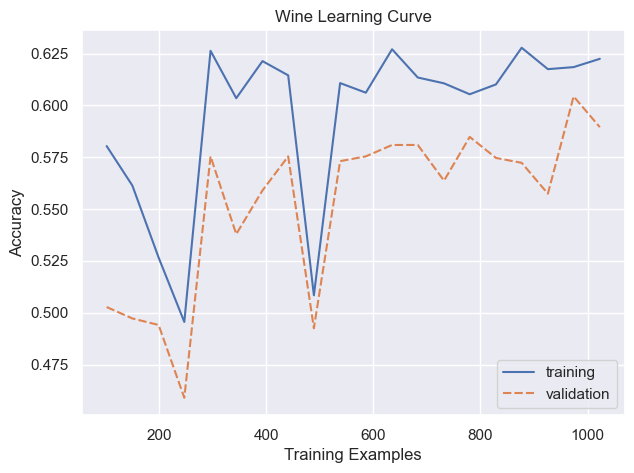

In [77]:
plot_df = pd.DataFrame()
plot_df.index = train_sizes
plot_df['training'] = train_scores.mean(axis=1)
plot_df['validation'] = cv_scores.mean(axis=1)

plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Training Examples', ylabel='Accuracy', title='Wine Learning Curve');
plt.savefig('wine_nn_learning_curve.png')

In [78]:
from time import time

In [79]:
start = time()
clf = KerasClassifier(build_fn=build_fn, epochs=400, batch_size=256)
results = clf.fit(X_train, y_train, validation_split=.2)
print(time() - start)

Epoch 1/400


C:\Users\legen\AppData\Local\Temp\ipykernel_20456\1993334744.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=build_fn, epochs=400, batch_size=256)


4/4 [==============================] - 0s 35ms/step - loss: 1.8635 - accuracy: 0.0508 - val_loss: 1.8299 - val_accuracy: 0.1016
Epoch 2/400
4/4 [==============================] - 0s 10ms/step - loss: 1.8361 - accuracy: 0.0978 - val_loss: 1.8082 - val_accuracy: 0.1211
Epoch 3/400
4/4 [==============================] - 0s 9ms/step - loss: 1.8142 - accuracy: 0.1652 - val_loss: 1.7918 - val_accuracy: 0.1875
Epoch 4/400
4/4 [==============================] - 0s 11ms/step - loss: 1.7976 - accuracy: 0.2317 - val_loss: 1.7796 - val_accuracy: 0.2773
Epoch 5/400
4/4 [==============================] - 0s 10ms/step - loss: 1.7840 - accuracy: 0.3157 - val_loss: 1.7697 - val_accuracy: 0.3320
Epoch 6/400
4/4 [==============================] - 0s 10ms/step - loss: 1.7735 - accuracy: 0.3587 - val_loss: 1.7614 - val_accuracy: 0.3398
Epoch 7/400
4/4 [==============================] - 0s 12ms/step - loss: 1.7646 - accuracy: 0.3705 - val_loss: 1.7540 - val_accuracy: 0.3711
Epoch 8/400
4/4 [================

4/4 [==============================] - 0s 10ms/step - loss: 1.0197 - accuracy: 0.5982 - val_loss: 1.1276 - val_accuracy: 0.5469
Epoch 118/400
4/4 [==============================] - 0s 10ms/step - loss: 1.0163 - accuracy: 0.6080 - val_loss: 1.1266 - val_accuracy: 0.5430
Epoch 119/400
4/4 [==============================] - 0s 10ms/step - loss: 1.0123 - accuracy: 0.6109 - val_loss: 1.1253 - val_accuracy: 0.5469
Epoch 120/400
4/4 [==============================] - 0s 9ms/step - loss: 1.0090 - accuracy: 0.6109 - val_loss: 1.1230 - val_accuracy: 0.5547
Epoch 121/400
4/4 [==============================] - 0s 10ms/step - loss: 1.0049 - accuracy: 0.6119 - val_loss: 1.1214 - val_accuracy: 0.5508
Epoch 122/400
4/4 [==============================] - 0s 9ms/step - loss: 1.0011 - accuracy: 0.6139 - val_loss: 1.1194 - val_accuracy: 0.5430
Epoch 123/400
4/4 [==============================] - 0s 12ms/step - loss: 0.9969 - accuracy: 0.6119 - val_loss: 1.1168 - val_accuracy: 0.5391
Epoch 124/400
4/4 [===

Epoch 175/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8914 - accuracy: 0.6315 - val_loss: 1.0839 - val_accuracy: 0.5664
Epoch 176/400
4/4 [==============================] - 0s 11ms/step - loss: 0.8903 - accuracy: 0.6285 - val_loss: 1.0804 - val_accuracy: 0.5664
Epoch 177/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8892 - accuracy: 0.6373 - val_loss: 1.0811 - val_accuracy: 0.5547
Epoch 178/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8883 - accuracy: 0.6393 - val_loss: 1.0817 - val_accuracy: 0.5586
Epoch 179/400
4/4 [==============================] - 0s 9ms/step - loss: 0.8878 - accuracy: 0.6334 - val_loss: 1.0818 - val_accuracy: 0.5625
Epoch 180/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8862 - accuracy: 0.6315 - val_loss: 1.0781 - val_accuracy: 0.5742
Epoch 181/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8864 - accuracy: 0.6315 - val_loss: 1.0767 - val_accuracy: 0.5625
Epoch 1

Epoch 233/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8485 - accuracy: 0.6305 - val_loss: 1.0677 - val_accuracy: 0.5586
Epoch 234/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8477 - accuracy: 0.6276 - val_loss: 1.0688 - val_accuracy: 0.5547
Epoch 235/400
4/4 [==============================] - 0s 11ms/step - loss: 0.8470 - accuracy: 0.6315 - val_loss: 1.0704 - val_accuracy: 0.5547
Epoch 236/400
4/4 [==============================] - 0s 9ms/step - loss: 0.8466 - accuracy: 0.6315 - val_loss: 1.0697 - val_accuracy: 0.5547
Epoch 237/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8462 - accuracy: 0.6315 - val_loss: 1.0689 - val_accuracy: 0.5547
Epoch 238/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8455 - accuracy: 0.6325 - val_loss: 1.0698 - val_accuracy: 0.5547
Epoch 239/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8447 - accuracy: 0.6315 - val_loss: 1.0698 - val_accuracy: 0.5547
Epoch 2

Epoch 291/400
4/4 [==============================] - 0s 9ms/step - loss: 0.8201 - accuracy: 0.6393 - val_loss: 1.0646 - val_accuracy: 0.5547
Epoch 292/400
4/4 [==============================] - 0s 9ms/step - loss: 0.8187 - accuracy: 0.6413 - val_loss: 1.0654 - val_accuracy: 0.5508
Epoch 293/400
4/4 [==============================] - 0s 11ms/step - loss: 0.8186 - accuracy: 0.6383 - val_loss: 1.0655 - val_accuracy: 0.5547
Epoch 294/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8179 - accuracy: 0.6403 - val_loss: 1.0662 - val_accuracy: 0.5547
Epoch 295/400
4/4 [==============================] - 0s 9ms/step - loss: 0.8178 - accuracy: 0.6393 - val_loss: 1.0648 - val_accuracy: 0.5508
Epoch 296/400
4/4 [==============================] - 0s 11ms/step - loss: 0.8170 - accuracy: 0.6393 - val_loss: 1.0667 - val_accuracy: 0.5586
Epoch 297/400
4/4 [==============================] - 0s 10ms/step - loss: 0.8163 - accuracy: 0.6393 - val_loss: 1.0656 - val_accuracy: 0.5469
Epoch 298

Epoch 349/400
4/4 [==============================] - 0s 10ms/step - loss: 0.7951 - accuracy: 0.6471 - val_loss: 1.0683 - val_accuracy: 0.5586
Epoch 350/400
4/4 [==============================] - 0s 9ms/step - loss: 0.7946 - accuracy: 0.6403 - val_loss: 1.0692 - val_accuracy: 0.5586
Epoch 351/400
4/4 [==============================] - 0s 11ms/step - loss: 0.7947 - accuracy: 0.6471 - val_loss: 1.0693 - val_accuracy: 0.5625
Epoch 352/400
4/4 [==============================] - 0s 10ms/step - loss: 0.7934 - accuracy: 0.6422 - val_loss: 1.0676 - val_accuracy: 0.5625
Epoch 353/400
4/4 [==============================] - 0s 9ms/step - loss: 0.7932 - accuracy: 0.6461 - val_loss: 1.0670 - val_accuracy: 0.5586
Epoch 354/400
4/4 [==============================] - 0s 11ms/step - loss: 0.7934 - accuracy: 0.6471 - val_loss: 1.0689 - val_accuracy: 0.5586
Epoch 355/400
4/4 [==============================] - 0s 10ms/step - loss: 0.7928 - accuracy: 0.6461 - val_loss: 1.0694 - val_accuracy: 0.5625
Epoch 35

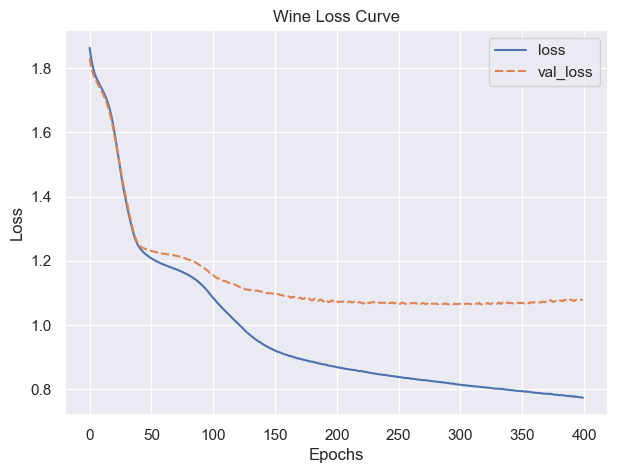

In [80]:
plot_df = pd.DataFrame()
plot_df.index = range(400)
plot_df['loss'] = results.history['loss']
plot_df['val_loss'] = results.history['val_loss']

plot = sb.lineplot(data=plot_df)
plot.set(xlabel='Epochs', ylabel='Loss', title='Wine Loss Curve');
plt.savefig('wine_nn_loss_curve.png')

In [81]:
clf = KerasClassifier(build_fn=build_fn, epochs=100, batch_size=256)
results = clf.fit(X_train, y_train, validation_split=.2)
print(results.history['accuracy'][-1])
print(clf.score(X_test, y_test))

Epoch 1/100


C:\Users\legen\AppData\Local\Temp\ipykernel_20456\3389583443.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=build_fn, epochs=100, batch_size=256)


4/4 [==============================] - 1s 35ms/step - loss: 1.8488 - accuracy: 0.2063 - val_loss: 1.8045 - val_accuracy: 0.3516
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 1.8104 - accuracy: 0.3871 - val_loss: 1.7754 - val_accuracy: 0.4531
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 1.7778 - accuracy: 0.4301 - val_loss: 1.7511 - val_accuracy: 0.4570
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 1.7516 - accuracy: 0.4457 - val_loss: 1.7312 - val_accuracy: 0.4492
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 1.7297 - accuracy: 0.4516 - val_loss: 1.7149 - val_accuracy: 0.4492
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 1.7111 - accuracy: 0.4545 - val_loss: 1.7004 - val_accuracy: 0.4570
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 1.6943 - accuracy: 0.4585 - val_loss: 1.6854 - val_accuracy: 0.4688
Epoch 8/100
4/4 [================